In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import warnings

file_path = 'limelight-data/limelight-psms-searches-6044-6046-6048-6050-6068-6069-6070-6071-6052-6053-6055-6056-6057-6058-6059-6061-6077-6078-6080-6082-2024-05-30.txt'


In [2]:
def load_peptide_search_results(file_path):
    """
    Load tab-delimited peptide search results from a file.

    Args:
        file_path (str): The path to the tab-delimited file containing the peptide search results.

    Returns:
        pd.DataFrame: A DataFrame containing the peptide search results, with the first row as the header.
    """
    try:
        # Read the tab-delimited file using pandas
        data = pd.read_csv(file_path, sep='\t', low_memory=False)
        
        return data
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the file: {str(e)}")
        return None

In [3]:
peptide_data = load_peptide_search_results(file_path)

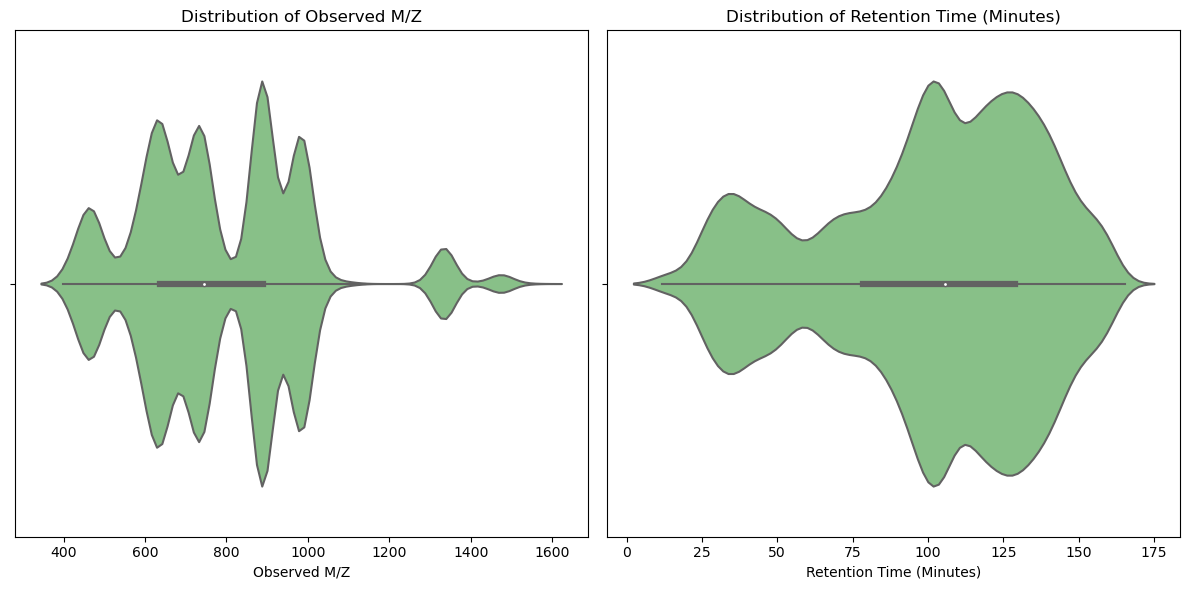

In [4]:
if peptide_data is not None:
    # Set the color palette to a pastel color scheme
    sns.set_palette('Accent')

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Create a violin plot for the "OBSERVED M/Z" column
    sns.violinplot(x=peptide_data['OBSERVED M/Z'], ax=ax1)
    ax1.set_title('Distribution of Observed M/Z')
    ax1.set_xlabel('Observed M/Z')

    # Create a violin plot for the "RETENTION TIME (MINUTES)" column
    sns.violinplot(x=peptide_data['RETENTION TIME (MINUTES)'], ax=ax2)
    ax2.set_title('Distribution of Retention Time (Minutes)')
    ax2.set_xlabel('Retention Time (Minutes)')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plots
    plt.show()

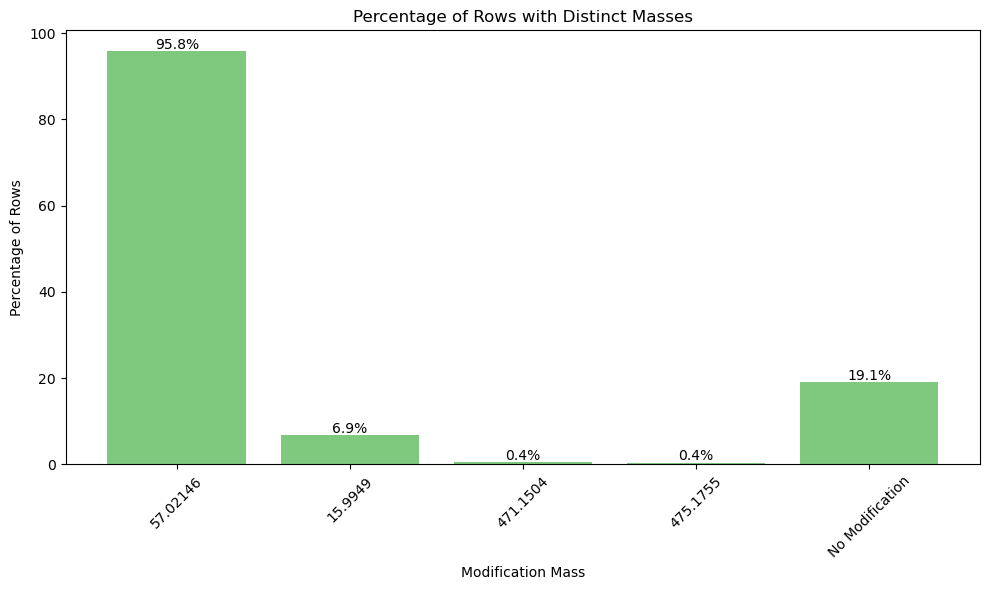

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Extract the distinct masses from the "MODS" column
masses = peptide_data['MODS'].str.extractall(r'(\d+\.\d+)').unstack()
masses = masses.apply(pd.Series).stack().reset_index(drop=True)

# Count the occurrences of each distinct mass
mass_counts = masses.value_counts()

# Calculate the percentage of rows that have each mass
mass_percentages = (mass_counts / len(peptide_data)) * 100

# Calculate the percentage of rows with no modifications
no_mod_count = peptide_data['MODS'].apply(lambda x: not bool(re.search(r'\d+\.\d+', str(x)))).sum()
no_mod_percentage = (no_mod_count / len(peptide_data)) * 100

# Combine the mass percentages and no modification percentage
percentages = pd.concat([mass_percentages, pd.Series([no_mod_percentage], index=['No Modification'])])

# Format the labels to remove parentheses, single quotes, and comma
labels = [re.sub(r"[(')\,]", '', str(label)) for label in percentages.index]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages)
plt.xlabel('Modification Mass')
plt.ylabel('Percentage of Rows')
plt.title('Percentage of Rows with Distinct Masses')
plt.xticks(rotation=45)

# Add percentage labels on top of each bar
for i, v in enumerate(percentages):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Display the plot
plt.tight_layout()
plt.show()

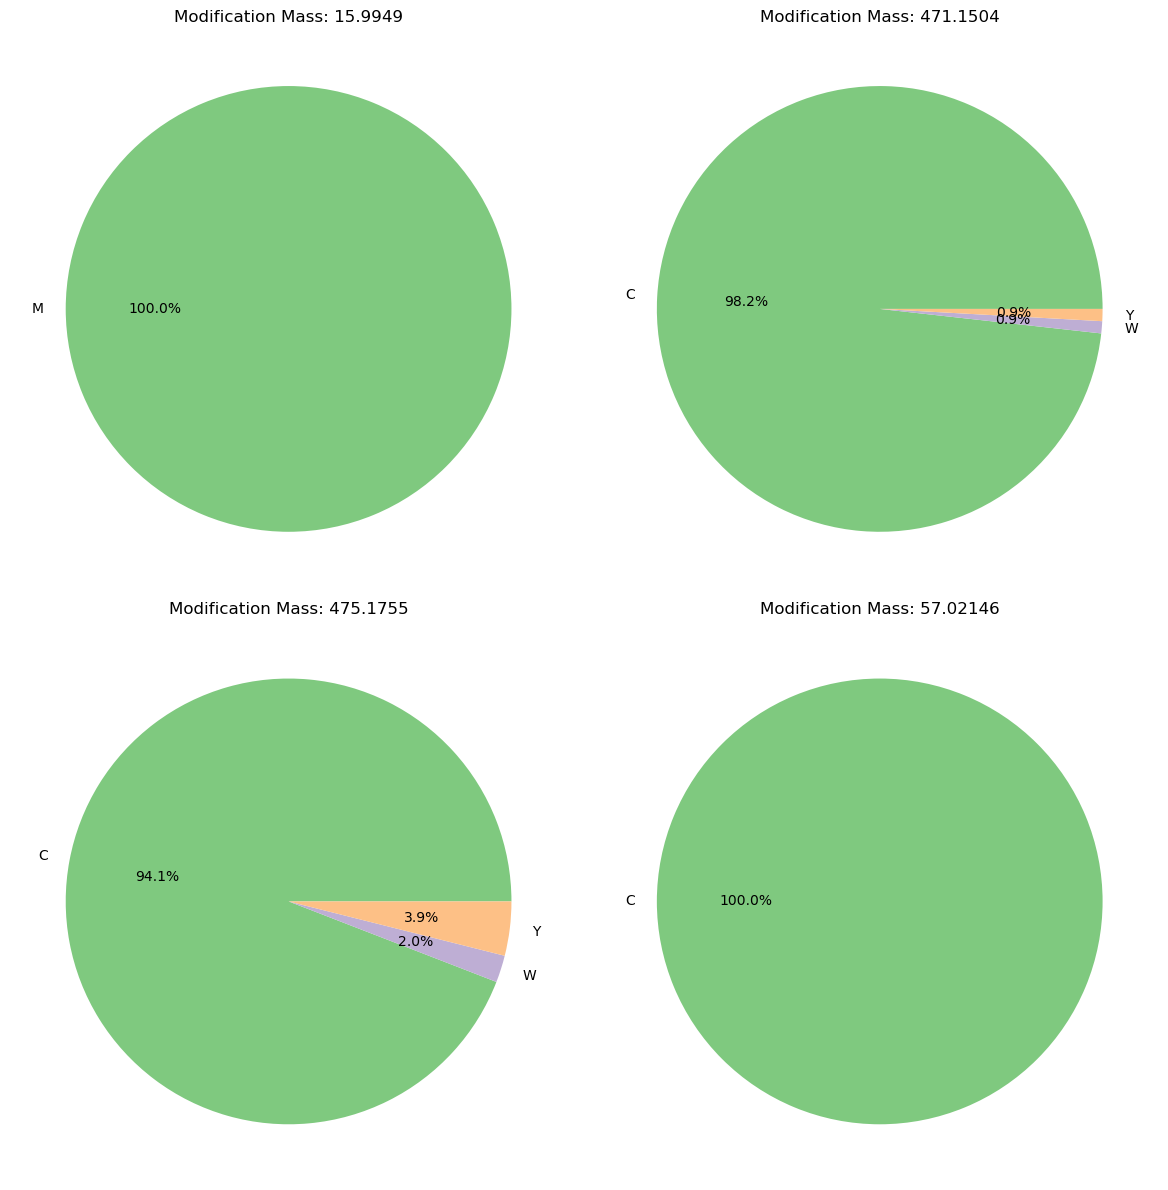

In [6]:
# Extract the distinct masses and positions from the "MODS" column
mods_data = peptide_data['MODS'].str.extractall(r'(\d+)\((\d+\.\d+)\)').reset_index(level=1, drop=True)
mods_data.columns = ['Position', 'Mass']
mods_data['Position'] = mods_data['Position'].astype(int)

# Merge the modifications data with the peptide sequences
merged_data = mods_data.merge(peptide_data['PEPTIDE'], left_index=True, right_index=True)

# Function to extract the amino acid at a given position in the peptide sequence
def get_amino_acid(row):
    peptide = row['PEPTIDE']
    position = row['Position'] - 1
    if 0 <= position < len(peptide):
        return peptide[position]
    else:
        return 'Unknown'

# Apply the function to extract the amino acid for each modification
merged_data['Amino Acid'] = merged_data.apply(get_amino_acid, axis=1)

# Group the data by modification mass and amino acid, and count the occurrences
grouped_data = merged_data.groupby(['Mass', 'Amino Acid']).size().reset_index(name='Count')

# Get the list of distinct modification masses
mod_masses = grouped_data['Mass'].unique()

# Create subplots for each modification mass
num_masses = len(mod_masses)
num_cols = 2
num_rows = (num_masses + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

for i, mass in enumerate(mod_masses):
    # Filter the data for the current modification mass
    mass_data = grouped_data[grouped_data['Mass'] == mass].copy()
    
    # Calculate the fraction of occurrences for each amino acid
    mass_data.loc[:, 'Fraction'] = mass_data['Count'] / mass_data['Count'].sum()
    
    # Create a pie chart in the corresponding subplot
    ax = axes[i // num_cols, i % num_cols]
    ax.pie(mass_data['Fraction'], labels=mass_data['Amino Acid'], autopct='%1.1f%%')
    ax.set_title(f'Modification Mass: {mass}')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [7]:
# Extract the distinct masses and positions from the "MODS" column
mods_data = peptide_data['MODS'].str.extractall(r'(\d+)\((\d+\.\d+)\)').reset_index(level=1, drop=True)
mods_data.columns = ['Position', 'Mass']
mods_data['Mass'] = mods_data['Mass'].astype(float).round().astype(int)

# Count rows with 471 modification mass
count_471 = mods_data[mods_data['Mass'] == 471].groupby(level=0).size().sum()

# Count rows with 475 modification mass
count_475 = mods_data[mods_data['Mass'] == 475].groupby(level=0).size().sum()

# Count rows with both 471 and 475 modification masses
mods_data['Has_471'] = mods_data['Mass'] == 471
mods_data['Has_475'] = mods_data['Mass'] == 475
count_both = (mods_data.groupby(level=0)
                       .agg({'Has_471': 'any', 'Has_475': 'any'})
                       .all(axis=1)
                       .sum())

# Print the counts
print(f"Number of rows with 471 modification mass: {count_471}")
print(f"Number of rows with 475 modification mass: {count_475}")
print(f"Number of rows with both 471 and 475 modification masses: {count_both}")

Number of rows with 471 modification mass: 114
Number of rows with 475 modification mass: 102
Number of rows with both 471 and 475 modification masses: 0


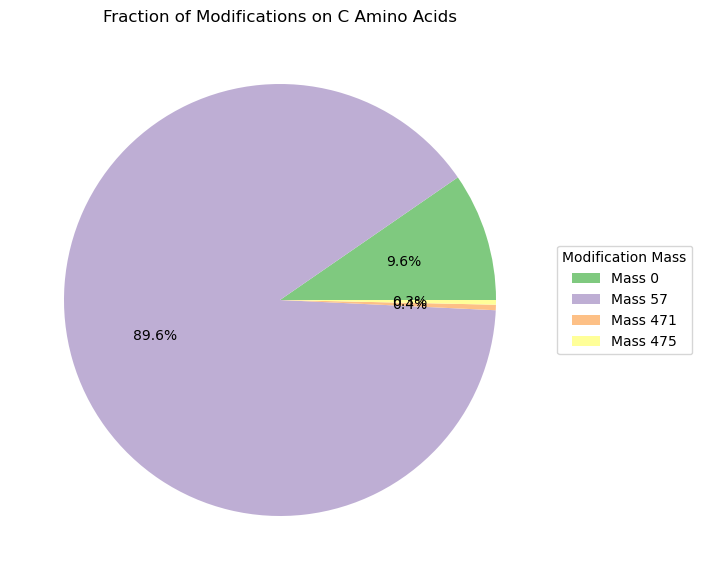

In [8]:
# Convert the 'MODS' column to a string
peptide_data['MODS'] = peptide_data['MODS'].astype(str)

# Initialize a dictionary to store the modification mass counts
mod_mass_counts = {}

# Iterate over each row in the DataFrame
for _, row in peptide_data.iterrows():
    peptide = row['PEPTIDE']
    mods = row['MODS']
    
    # Extract the modification positions and masses from the "MODS" column
    mod_positions = [int(pos) for pos, _ in re.findall(r'(\d+)\((\d+\.\d+)\)', mods)]
    mod_masses = [float(mass) for _, mass in re.findall(r'(\d+)\((\d+\.\d+)\)', mods)]
    
    # Iterate over each amino acid in the peptide sequence
    for i, aa in enumerate(peptide, start=1):
        if aa == 'C':
            if i in mod_positions:
                # C amino acid has a modification
                mod_mass = int(mod_masses[mod_positions.index(i)])
                mod_mass_counts[mod_mass] = mod_mass_counts.get(mod_mass, 0) + 1
            else:
                # C amino acid has no modification
                mod_mass_counts[0] = mod_mass_counts.get(0, 0) + 1

# Calculate the total count of C amino acids
total_c_count = sum(mod_mass_counts.values())

# Calculate the fraction of C amino acids with each modification mass
mod_mass_fractions = {mass: count / total_c_count for mass, count in mod_mass_counts.items()}

# Create a pie chart
plt.figure(figsize=(8, 8))
_, _, autotexts = plt.pie(mod_mass_fractions.values(), labels=None, autopct='%1.1f%%')
plt.title('Fraction of Modifications on C Amino Acids')

# Create a legend outside the pie chart
labels = [f"Mass {mass}" for mass in mod_mass_fractions.keys()]
plt.legend(labels, title="Modification Mass", loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust the spacing between the pie chart and the legend
plt.subplots_adjust(right=0.8)

# Display the plot
plt.show()

In [9]:
def add_mod_masses(row):
    peptide = row['PEPTIDE']
    mods = row['MODS']
    
    if not mods:
        return peptide
    
    mod_positions = re.findall(r'(\d+)\((\d+\.\d+)\)', mods)
    mod_positions = [(int(pos), mass) for pos, mass in mod_positions]
    
    mod_peptide = ''
    for i, aa in enumerate(peptide, start=1):
        mod_peptide += aa
        for pos, mass in mod_positions:
            if pos == i:
                mod_peptide += f'[{mass}]'
    
    return mod_peptide

peptide_data['mod_peptide'] = peptide_data.apply(add_mod_masses, axis=1)

print(peptide_data[['PEPTIDE', 'MODS', 'mod_peptide']].head(10))

        PEPTIDE MODS   mod_peptide
0  SLHTLFGDELCK  nan  SLHTLFGDELCK
1  EVGETLLYYGCR  nan  EVGETLLYYGCR
2  EVGETLLYYGCR  nan  EVGETLLYYGCR
3  EVGETLLYYGCR  nan  EVGETLLYYGCR
4  EVGETLLYYGCR  nan  EVGETLLYYGCR
5  EVGETLLYYGCR  nan  EVGETLLYYGCR
6  EVGETLLYYGCR  nan  EVGETLLYYGCR
7   VLQNFSFKPCK  nan   VLQNFSFKPCK
8   VLQNFSFKPCK  nan   VLQNFSFKPCK
9   VLQNFSFKPCK  nan   VLQNFSFKPCK


In [10]:
def add_mod_masses(row):
    peptide = row['PEPTIDE']
    mods = row['MODS']
    
    if not mods:
        return peptide
    
    mod_positions = re.findall(r'(\d+)\((\d+\.\d+)\)', mods)
    mod_positions = [(int(pos), mass) for pos, mass in mod_positions]
    
    mod_peptide = ''
    for i, aa in enumerate(peptide, start=1):
        mod_peptide += aa
        for pos, mass in mod_positions:
            if pos == i:
                mod_peptide += f'[{mass}]'
    
    return mod_peptide

def replace_mod_masses(mod_peptide):
    return re.sub(r'\[(?:471\.1504|475\.1755)\]', '*', mod_peptide)

peptide_data['mod_peptide'] = peptide_data.apply(add_mod_masses, axis=1)
peptide_data['star_mod_peptide'] = peptide_data['mod_peptide'].apply(replace_mod_masses)

print(peptide_data[peptide_data['MODS'].str.contains('471\.1504|475\.1755')][['mod_peptide', 'star_mod_peptide']].head(5))

                mod_peptide star_mod_peptide
2584  VLQNFSFKPC[471.1504]K     VLQNFSFKPC*K
2585  VLQNFSFKPC[471.1504]K     VLQNFSFKPC*K
2586  VLQNFSFKPC[471.1504]K     VLQNFSFKPC*K
2587  VLQNFSFKPC[471.1504]K     VLQNFSFKPC*K
2588    EC[471.1504]YSVFTNR       EC*YSVFTNR


In [11]:
# Create a dictionary to store the collected rows
collected_rows = {}

# Iterate over each row in the DataFrame
for _, row in peptide_data.iterrows():
    star_mod_peptide = row['star_mod_peptide']
    mods = row['MODS']
    
    if '471.1504' in mods or '475.1755' in mods:
        if star_mod_peptide not in collected_rows:
            collected_rows[star_mod_peptide] = {'471.1504': [], '475.1755': []}
        
        if '471.1504' in mods:
            collected_rows[star_mod_peptide]['471.1504'].append(row)
        
        if '475.1755' in mods:
            collected_rows[star_mod_peptide]['475.1755'].append(row)

# check that we have the expected number of peptides containing either 471 or 475
filtered_df = peptide_data[peptide_data['mod_peptide'].str.contains('471.1504|475.1755')]
num_distinct_values = filtered_df['mod_peptide'].nunique()
print(num_distinct_values)

# how many entries our in our dict when 471 and 475 are subbed with a *
len(collected_rows)

76


48

In [12]:
# Iterate over each star_mod_peptide in collected_rows
for star_mod_peptide, mod_dict in collected_rows.items():
    # Find the position of the * in the star_mod_peptide
    star_pos = star_mod_peptide.find('*')
    
    if star_pos != -1:
        if star_pos == 0 or star_mod_peptide[star_pos - 1] == 'C':
            # If the * comes after a C or is at the beginning, find rows with [57.02146] at that position
            nomod_peptide = star_mod_peptide[:star_pos] + '[57.02146]' + star_mod_peptide[star_pos + 1:]
            nomod_rows = peptide_data[peptide_data['mod_peptide'] == nomod_peptide]
        else:
            # If the * does not come after a C, find rows with no modification at that position
            nomod_peptide = star_mod_peptide.replace('*', '')
            nomod_rows = peptide_data[peptide_data['mod_peptide'] == nomod_peptide]
        
        # Initialize the "nomod" key as an empty list if it doesn't exist
        if 'nomod' not in mod_dict:
            mod_dict['nomod'] = []
        
        # Append each row from nomod_rows to the "nomod" list as a Series
        for _, row in nomod_rows.iterrows():
            mod_dict['nomod'].append(row)

# check that we have the expected number of peptides containing either 471 or 475
filtered_df = peptide_data[peptide_data['mod_peptide'].str.contains('471.1504|475.1755')]
num_distinct_values = filtered_df['mod_peptide'].nunique()
print(num_distinct_values)

# how many entries our in our dict when 471 and 475 are subbed with a *
len(collected_rows)

76


48

In [13]:
# Print the collected rows
#for star_mod_peptide, mod_dict in collected_rows.items():
#    print(f"star_mod_peptide: {star_mod_peptide}")
#    print("Rows with 471.1504:")
#    for row in mod_dict['471.1504']:
#        print(row[['PEPTIDE', 'MODS', 'mod_peptide', 'star_mod_peptide']])
#    print("Rows with 475.1755:")
#    for row in mod_dict['475.1755']:
#        print(row[['PEPTIDE', 'MODS', 'mod_peptide', 'star_mod_peptide']])
#    print("Rows with nomod:")
#    for row in mod_dict['nomod']:
#        print(row[['PEPTIDE', 'MODS', 'mod_peptide', 'star_mod_peptide']])
#    print()

In [14]:
print(type(collected_rows['GLC*AIAQAESLR']['471.1504'])[0])
print(type(collected_rows['GLC*AIAQAESLR']['475.1755'][0]))
print(type(collected_rows['GLC*AIAQAESLR']['nomod'][0]))

list[0]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


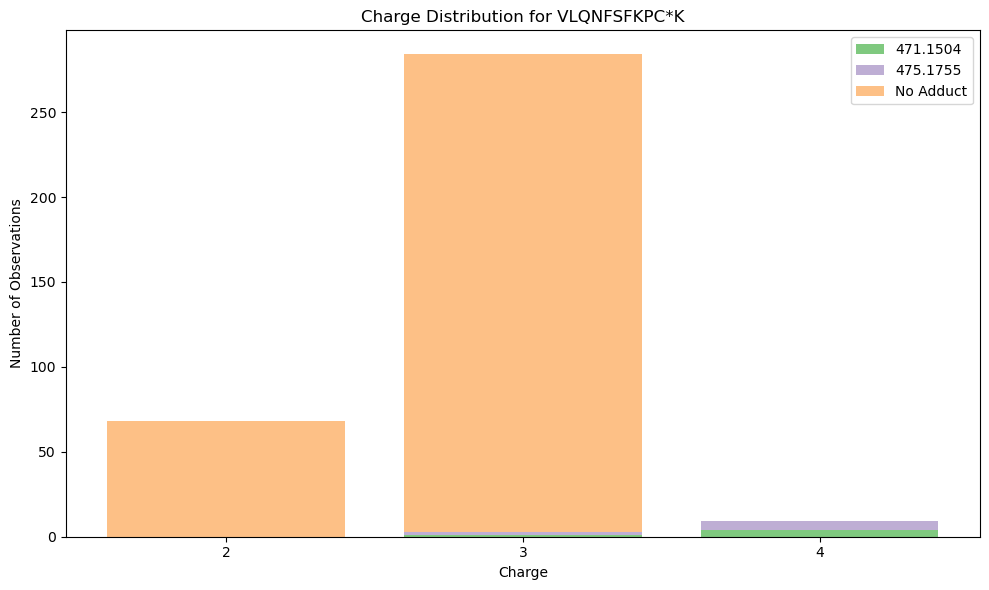

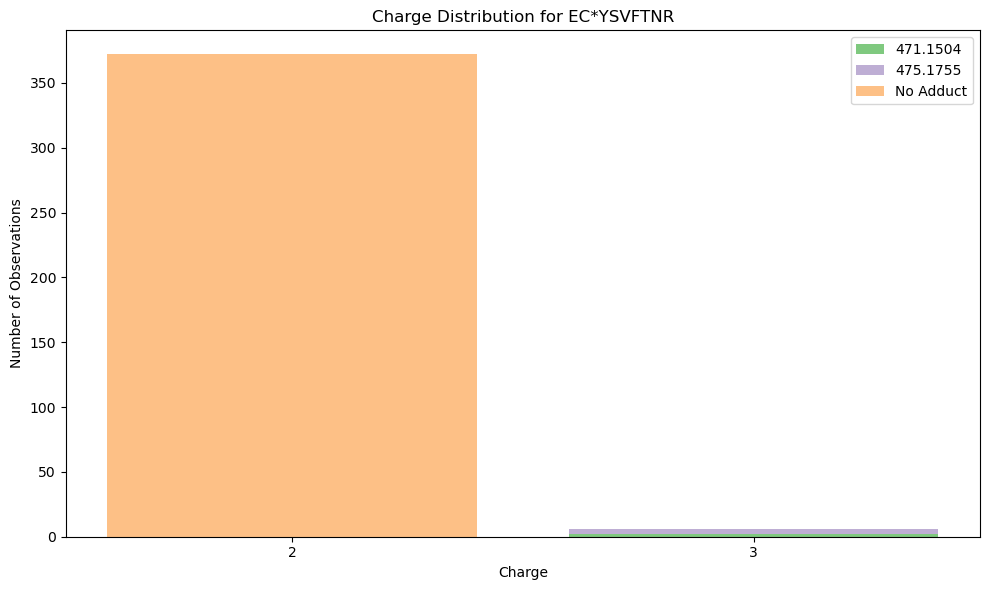

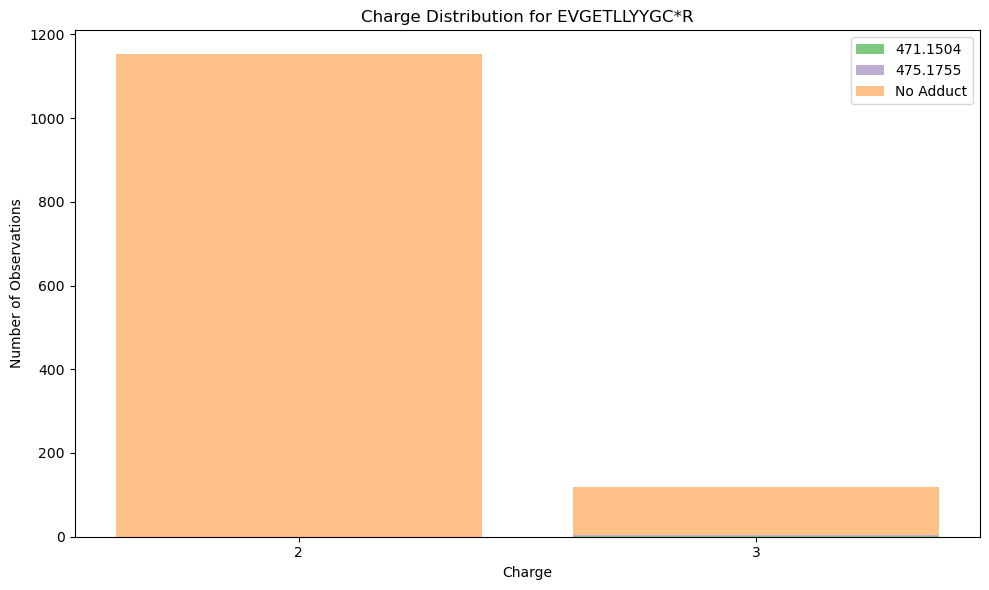

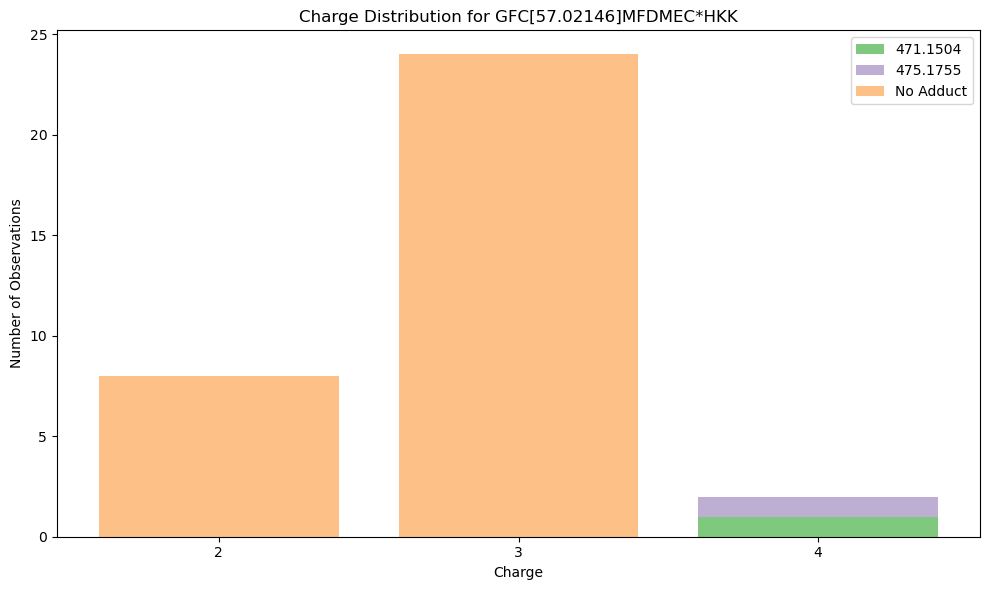

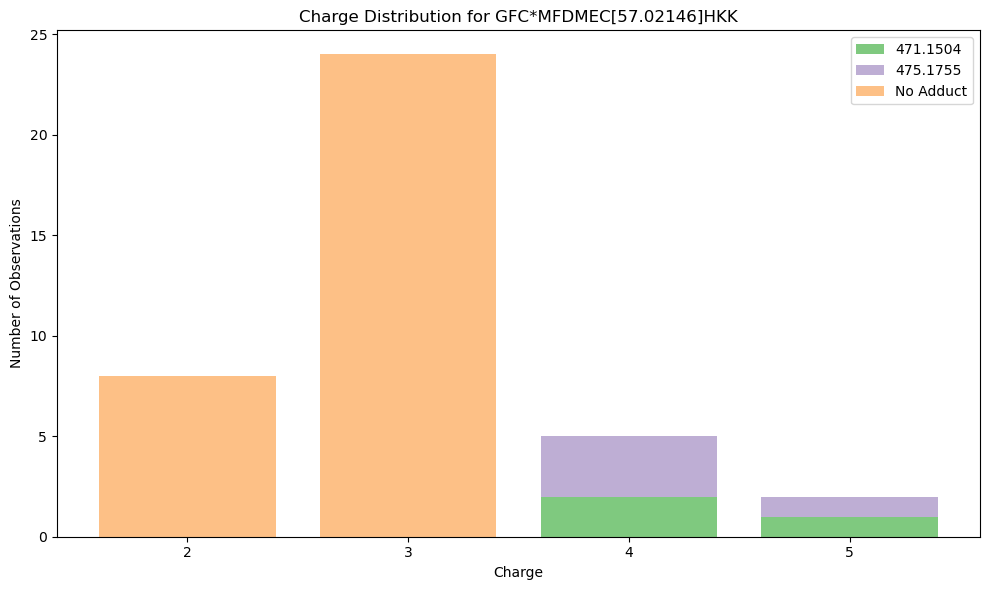

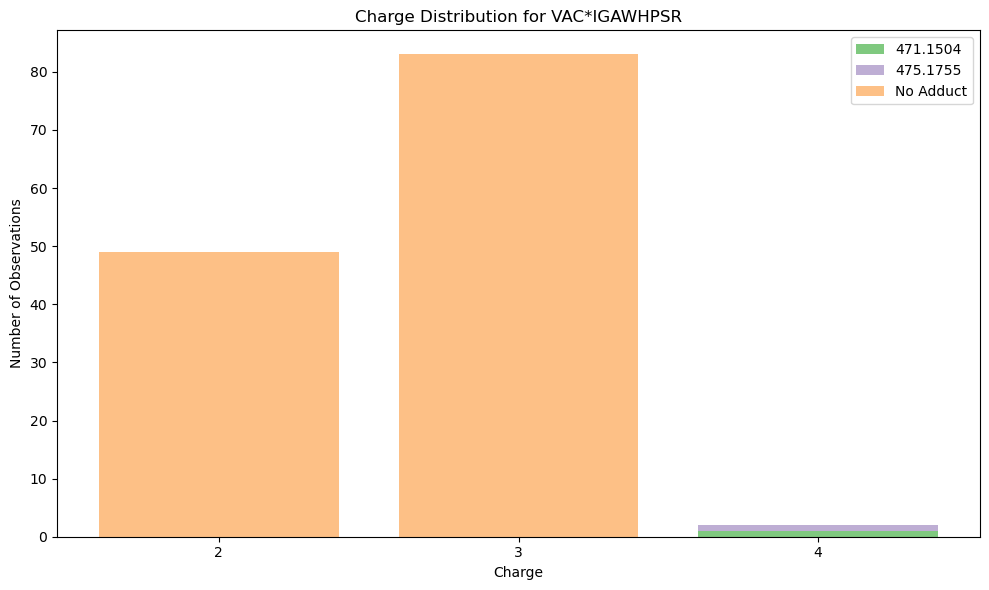

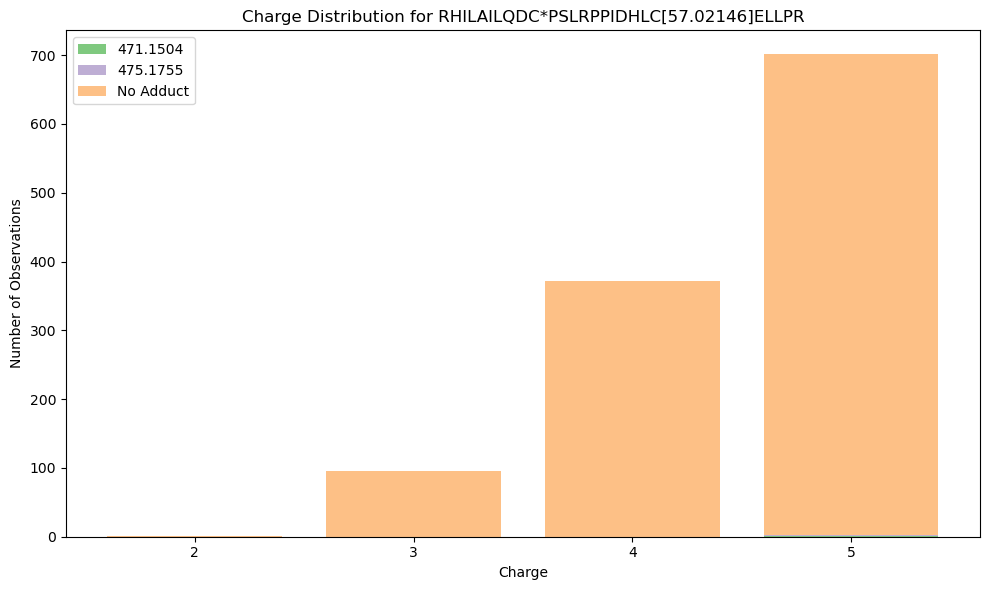

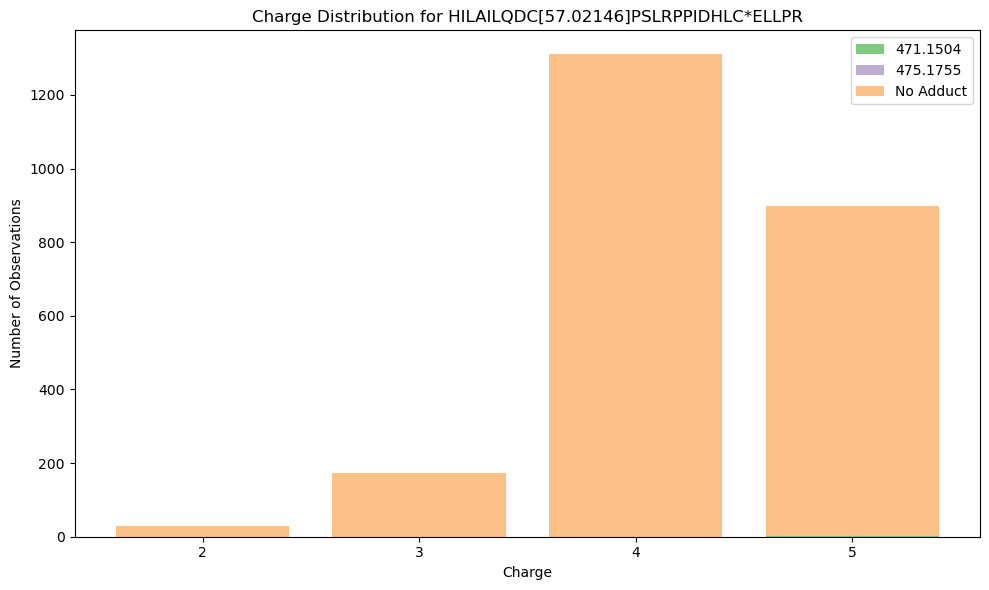

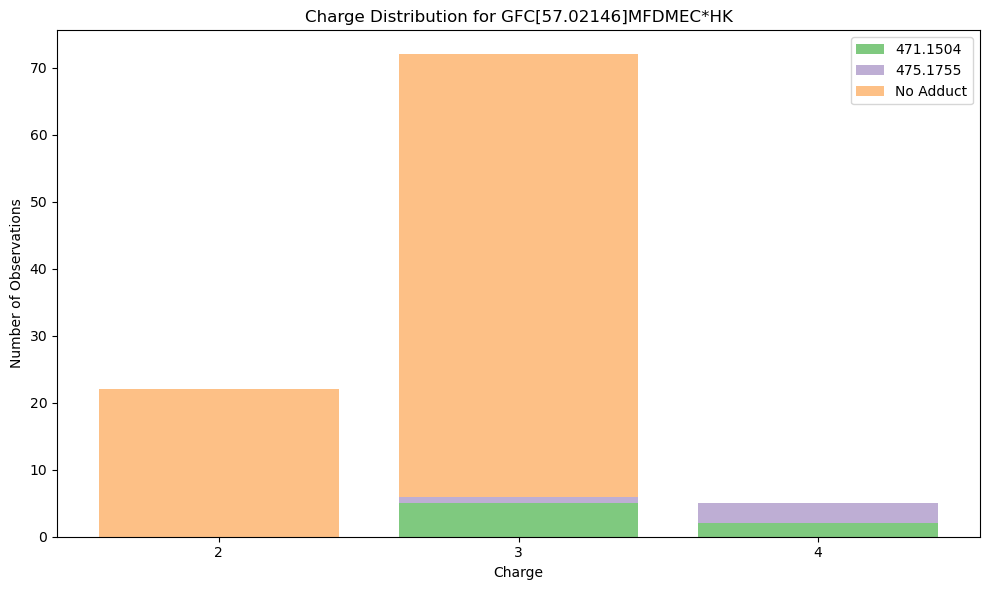

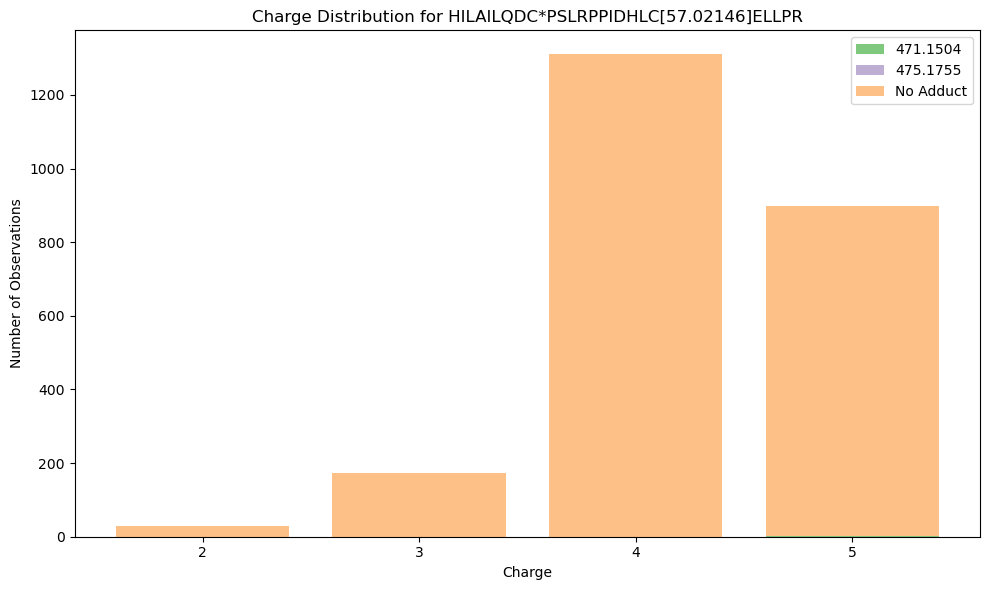

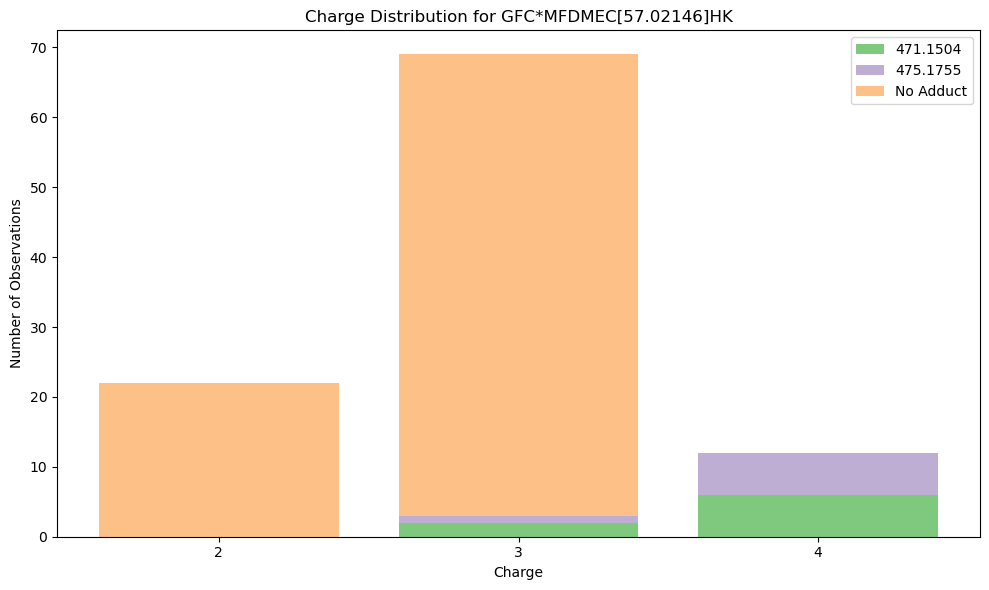

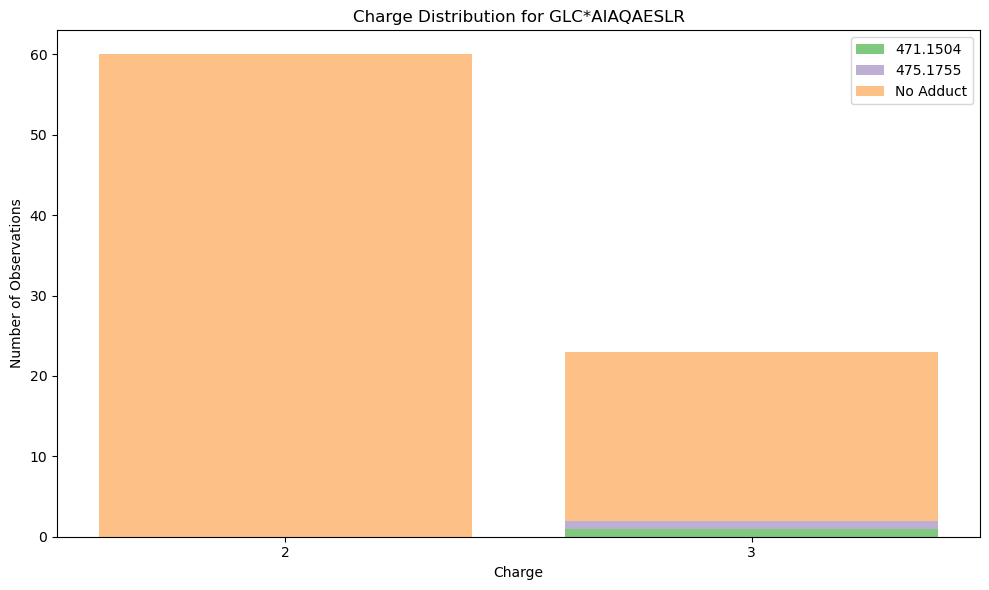

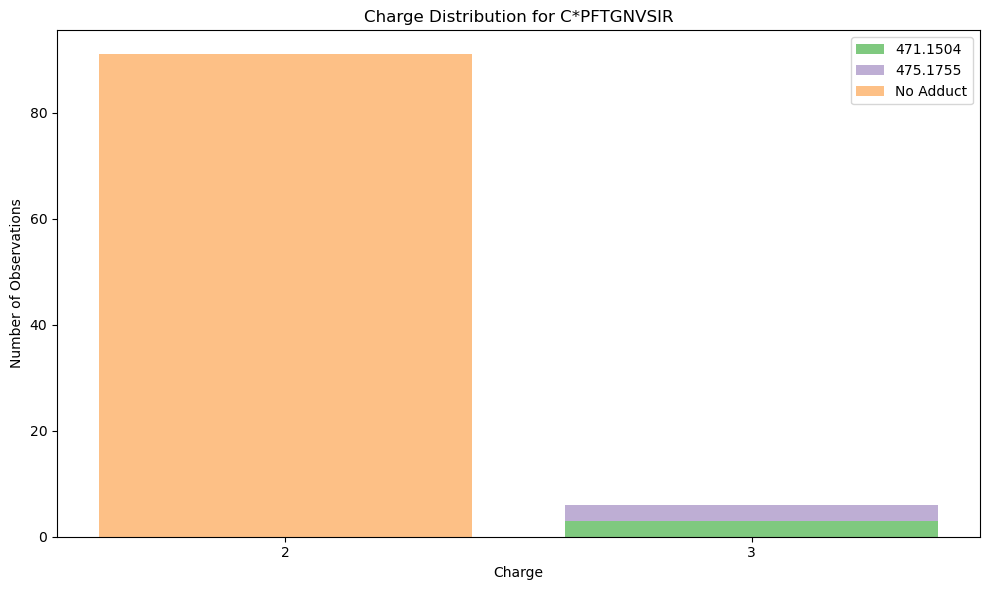

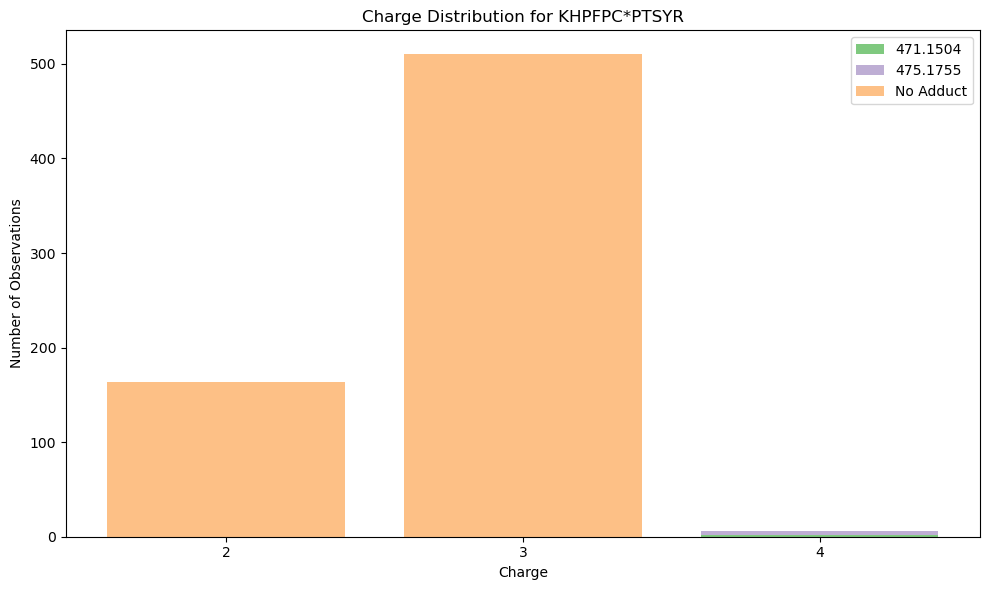

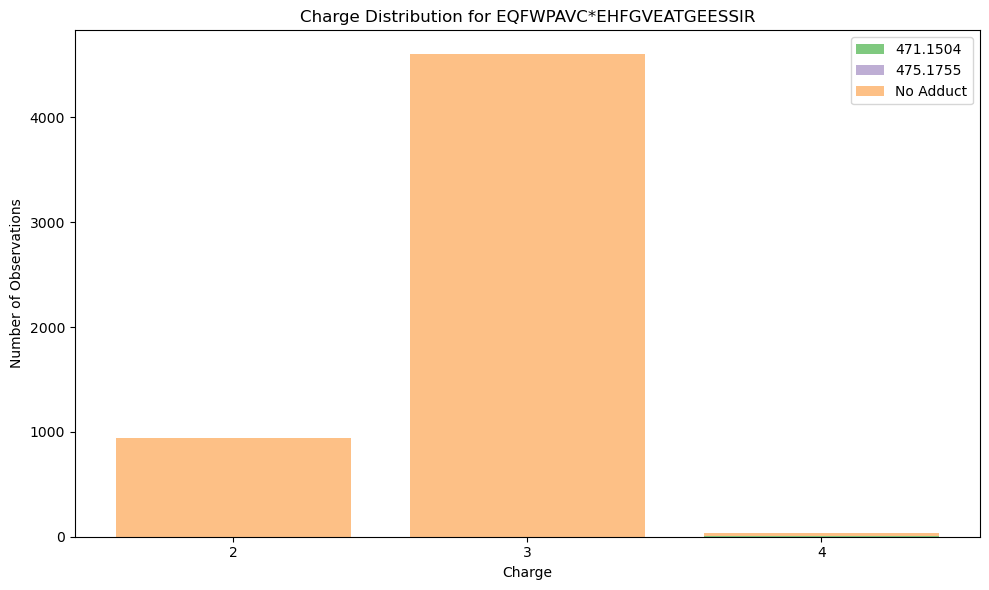

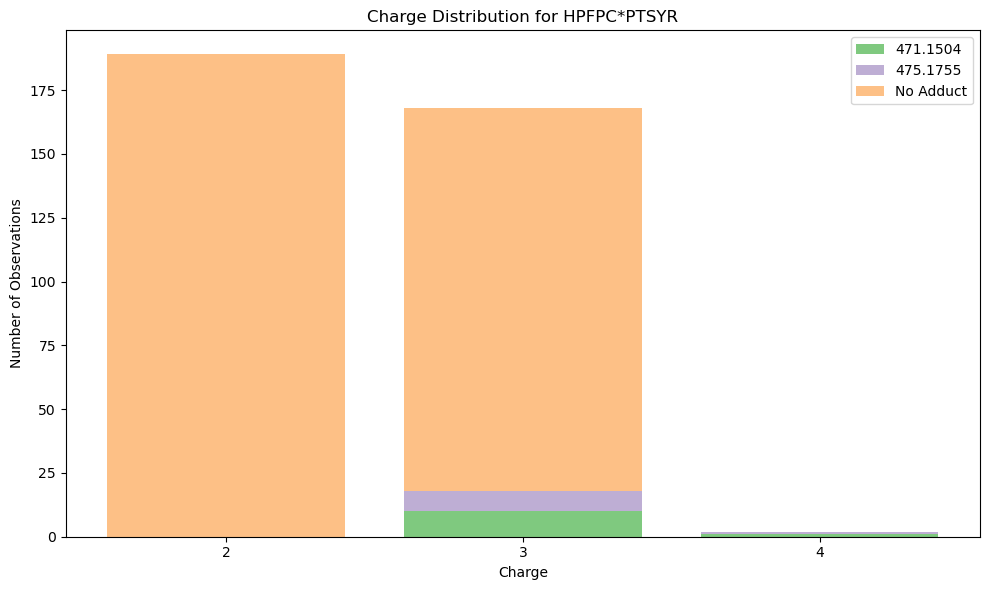

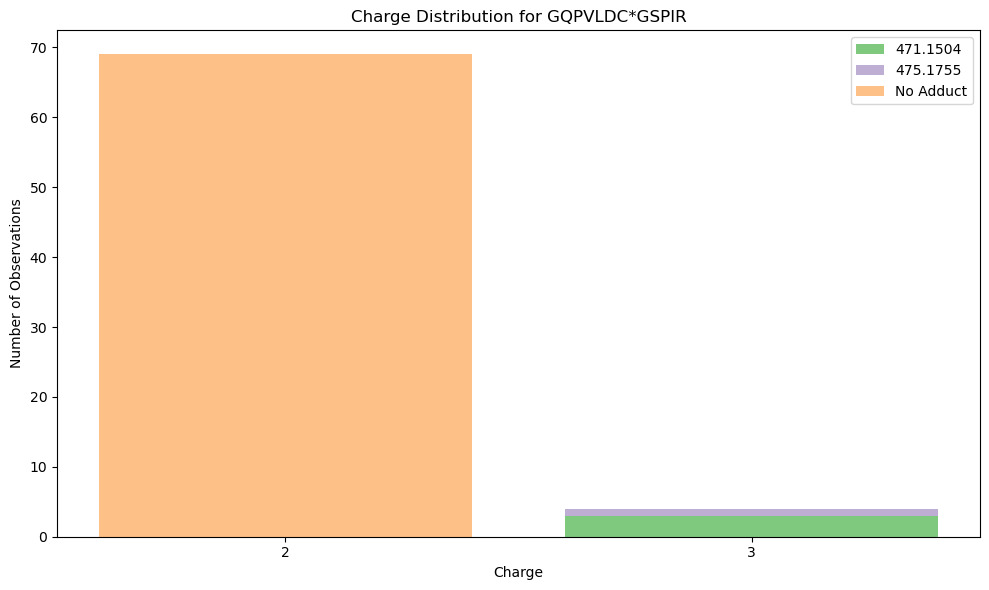

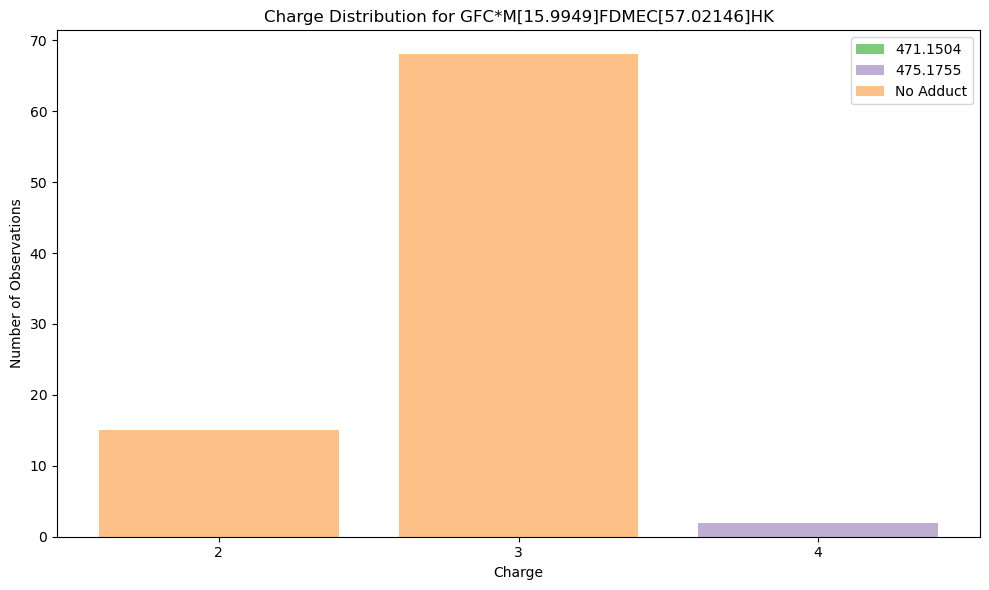

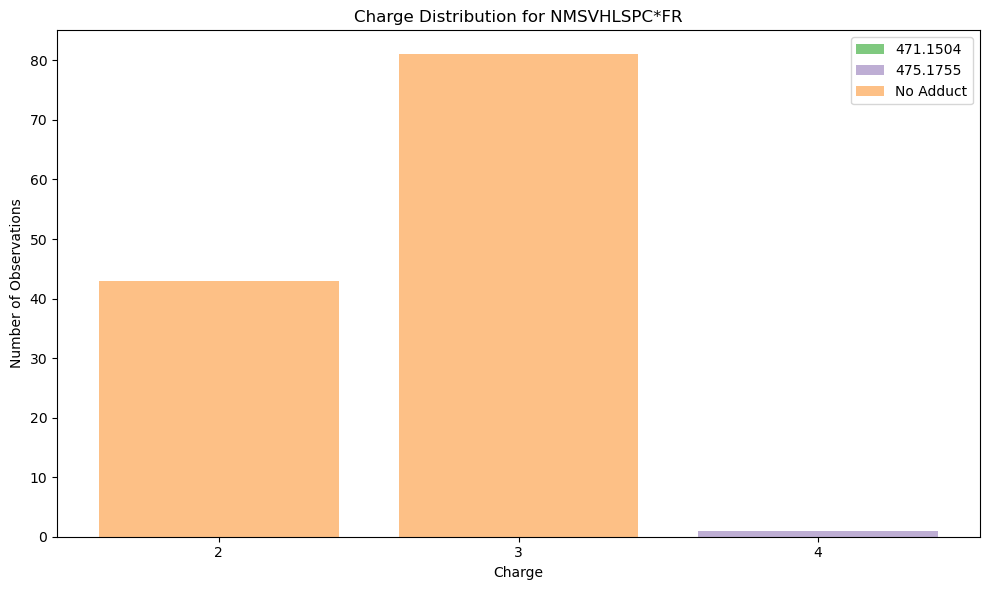

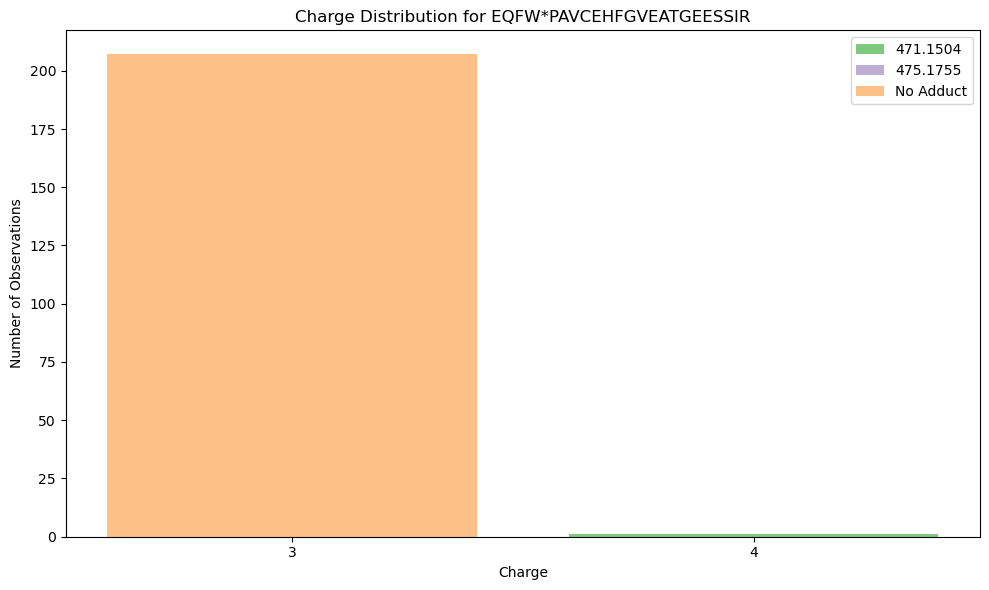

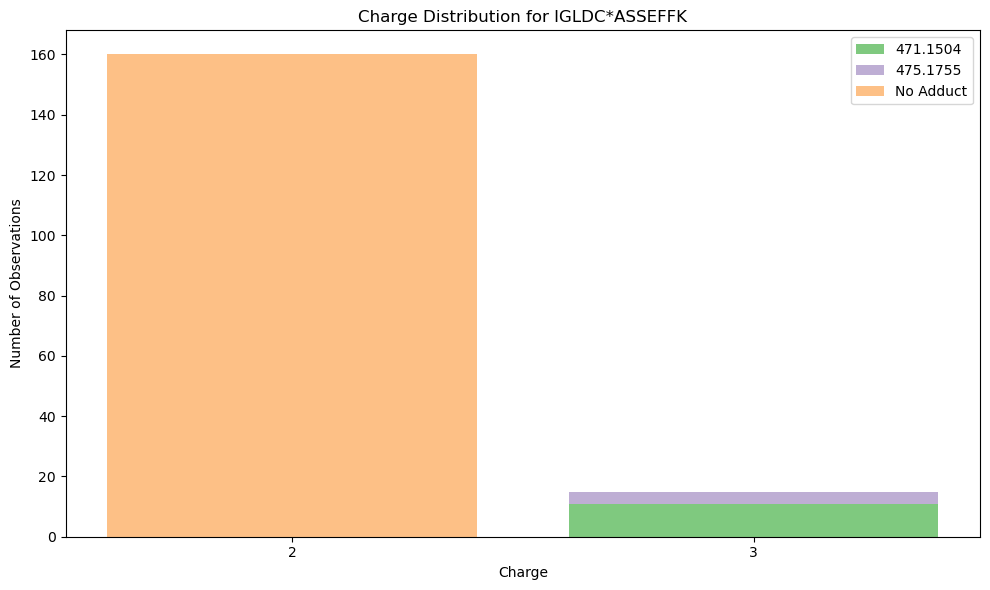

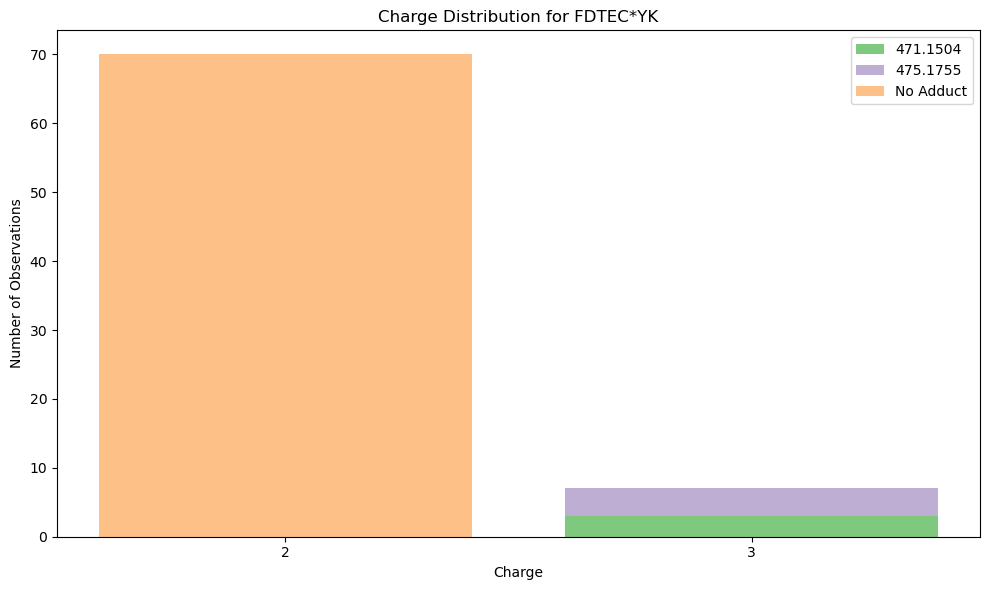

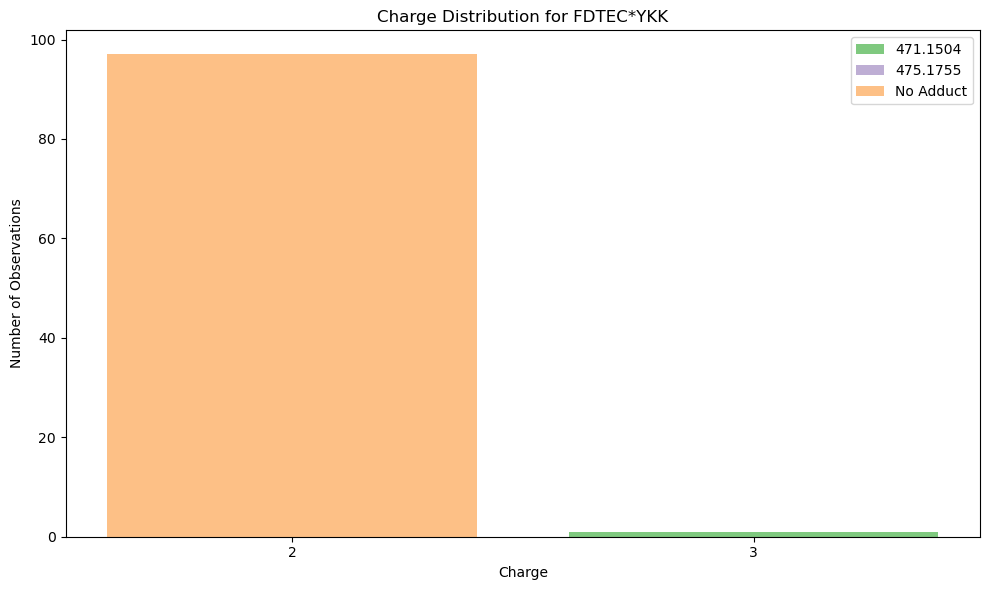

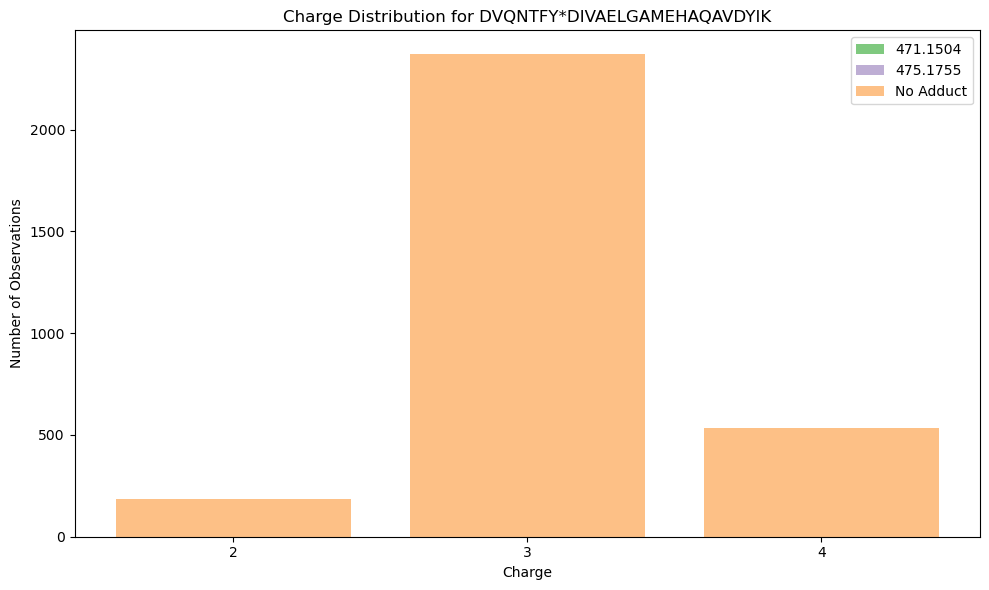

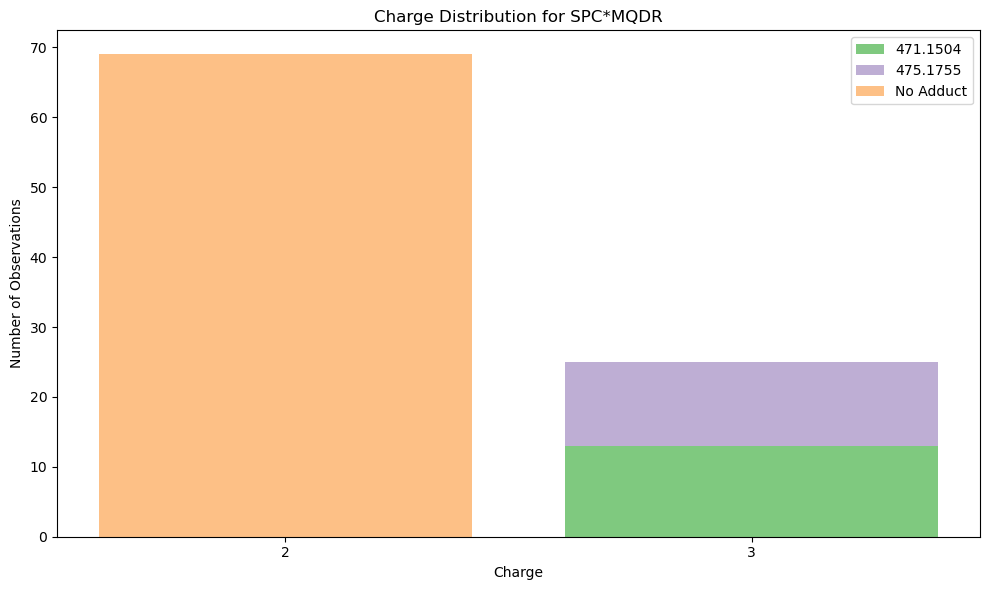

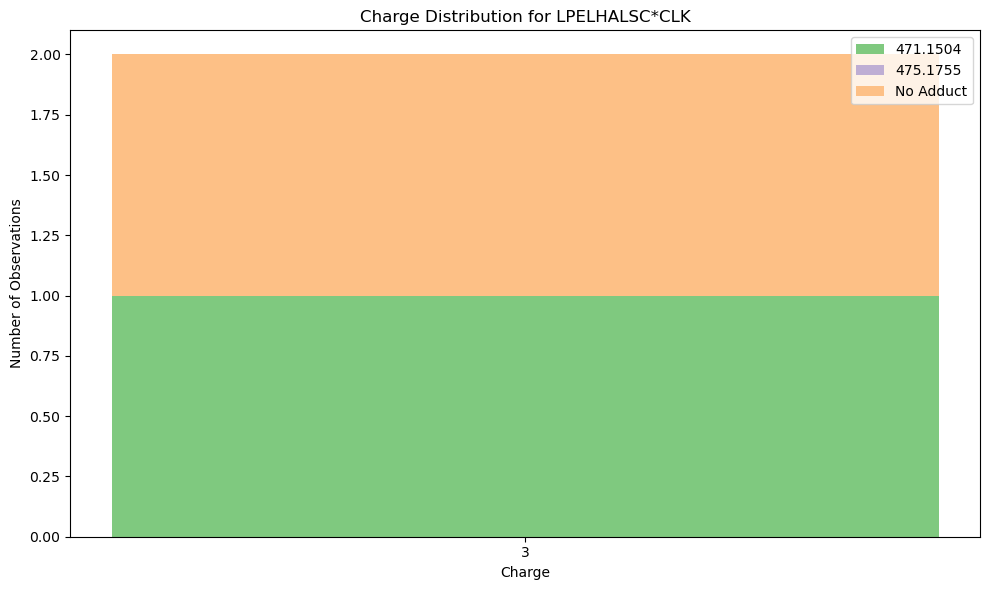

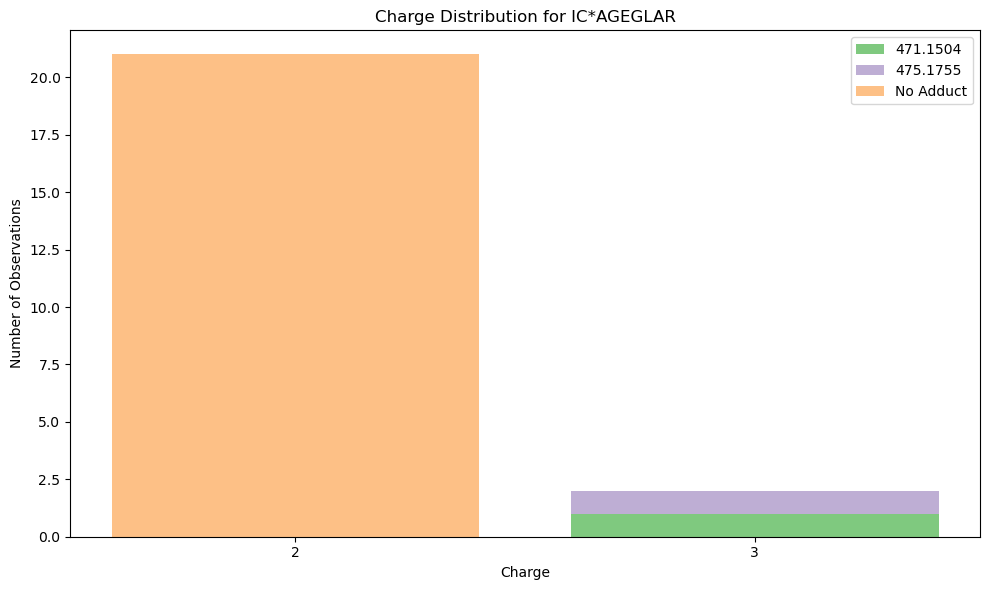

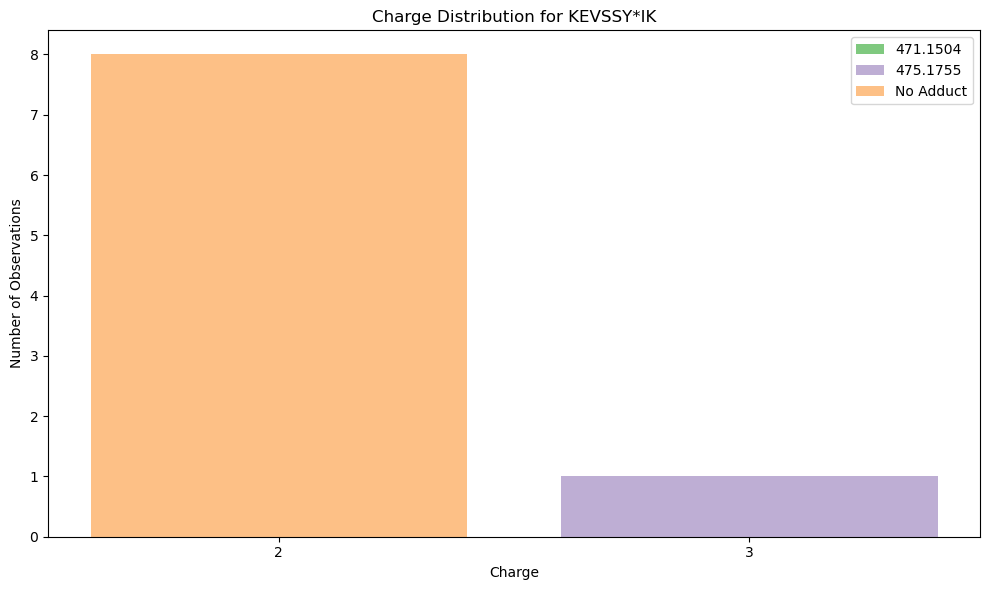

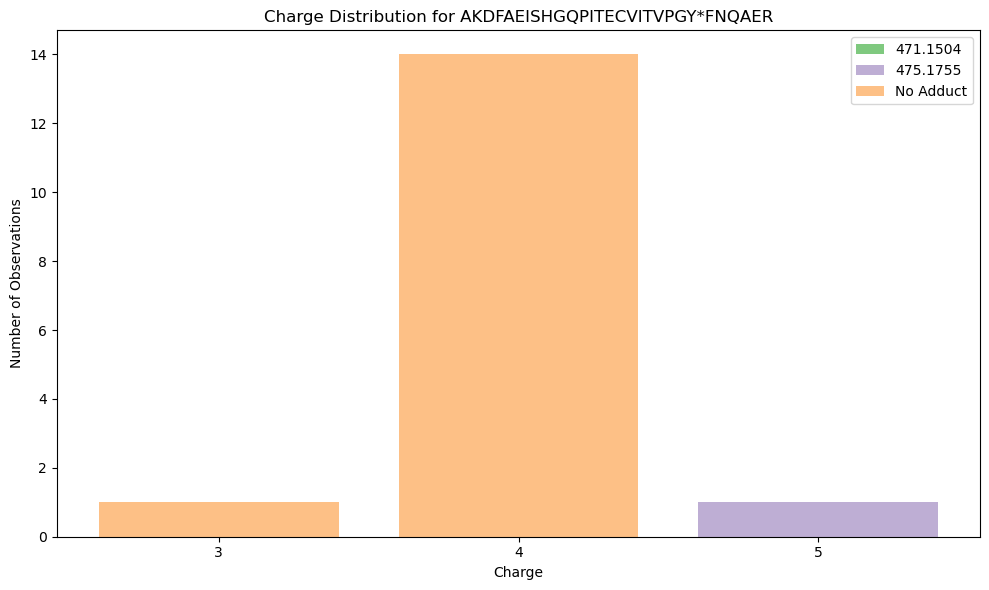

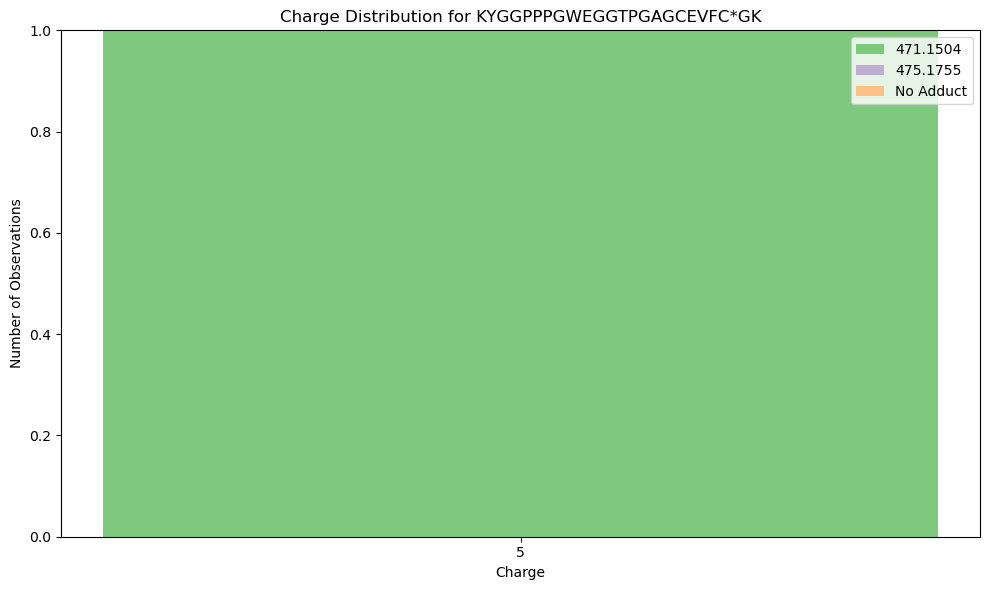

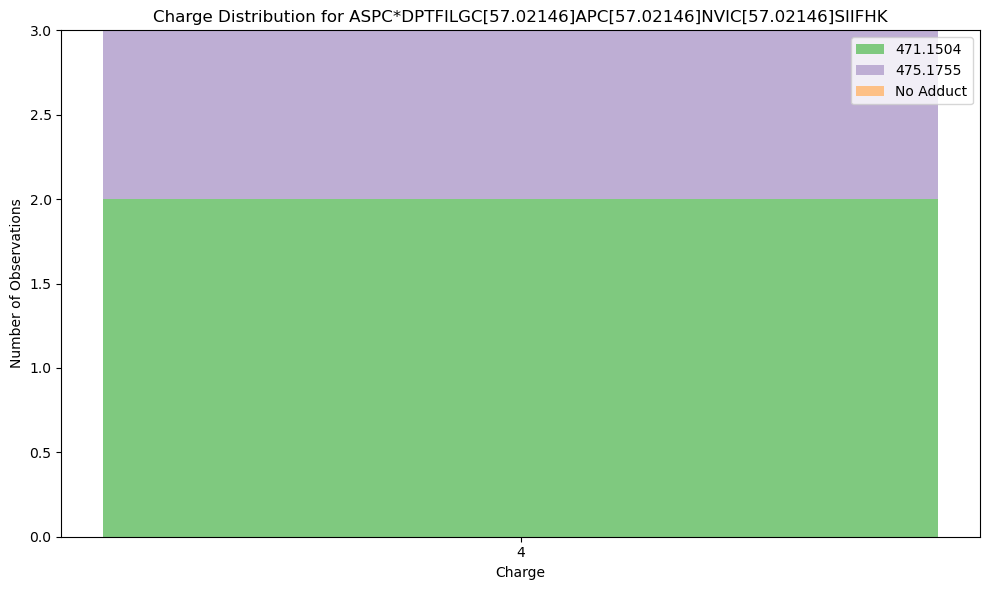

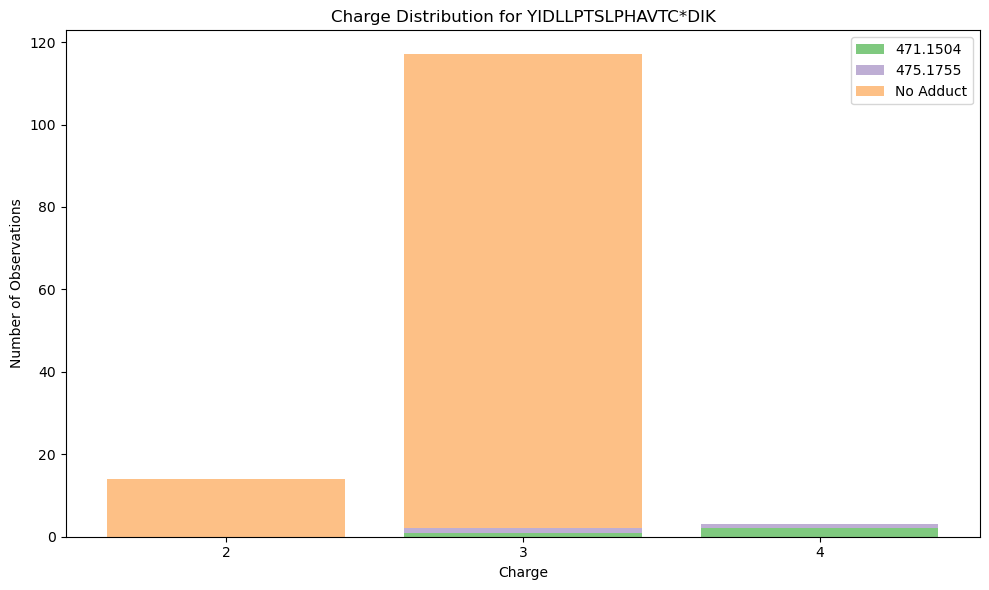

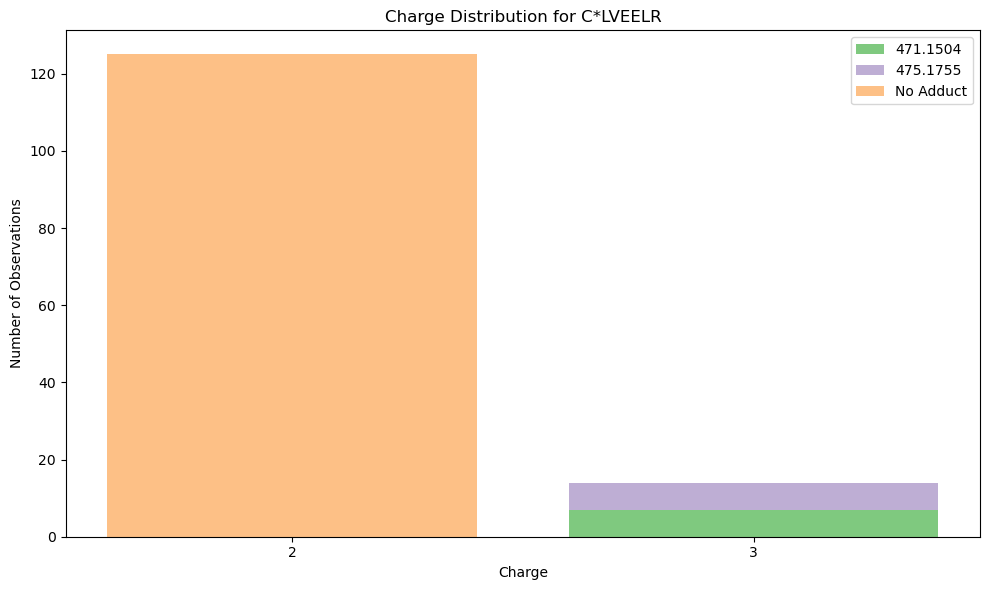

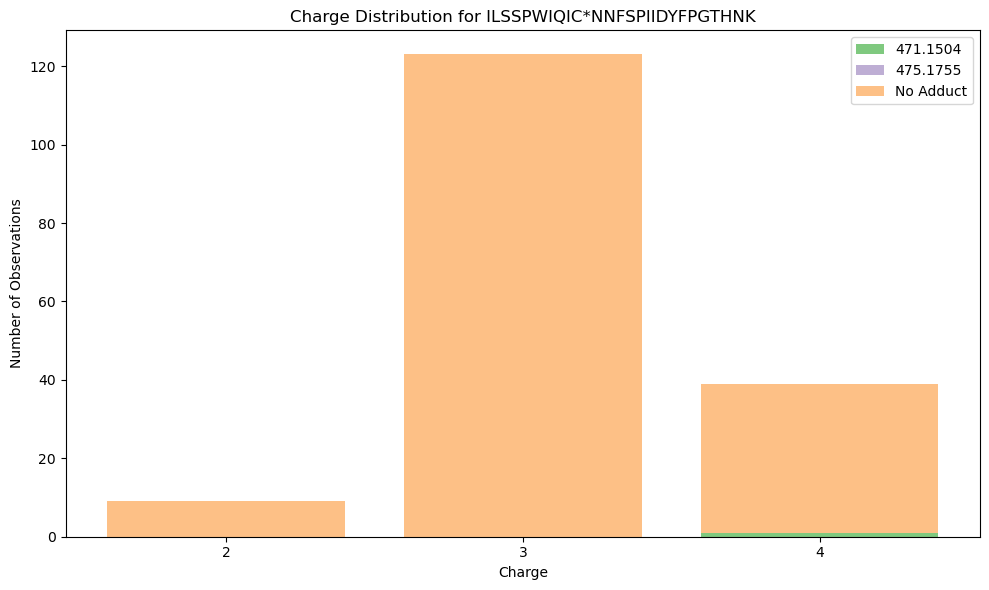

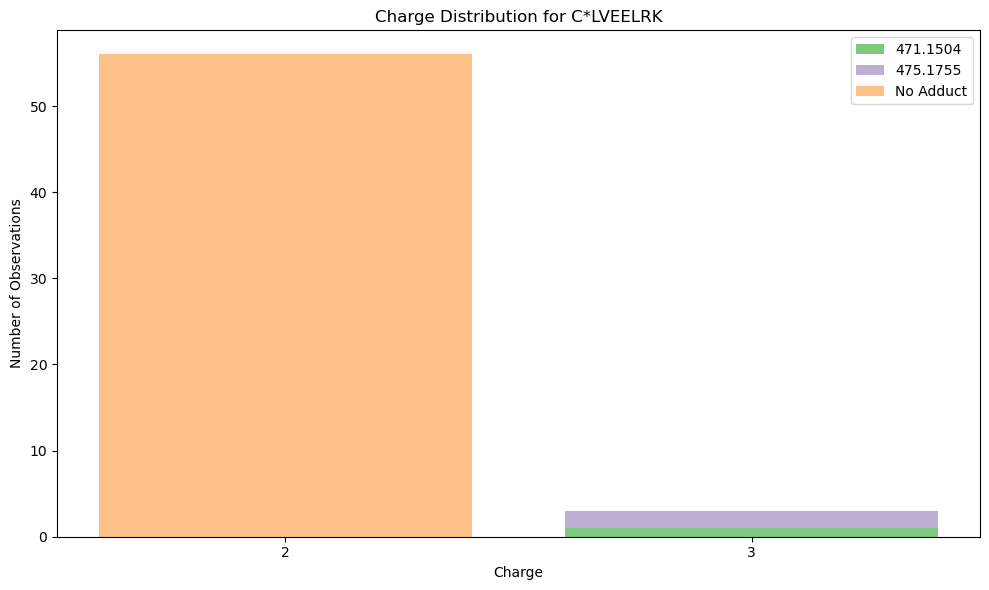

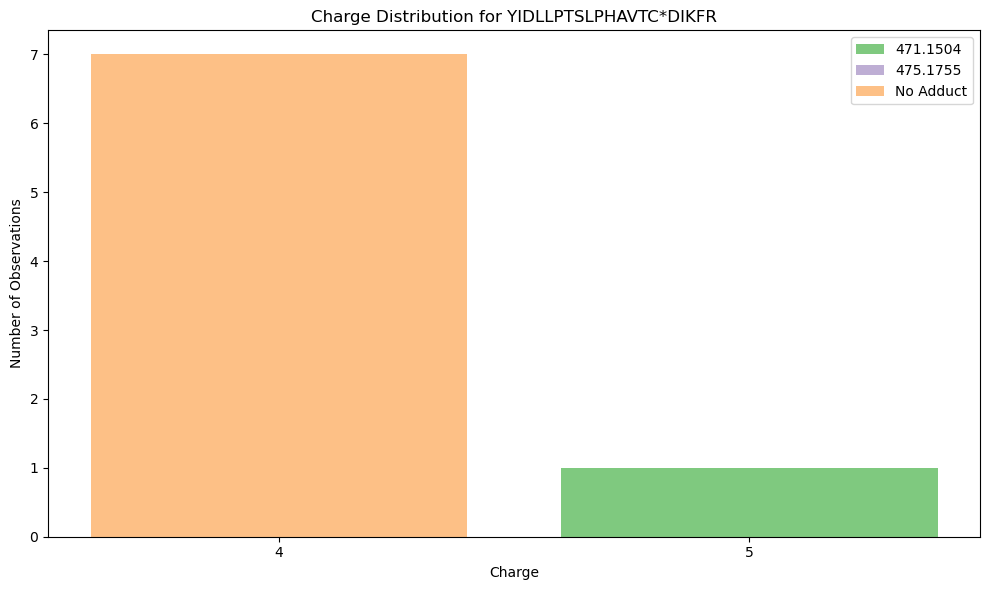

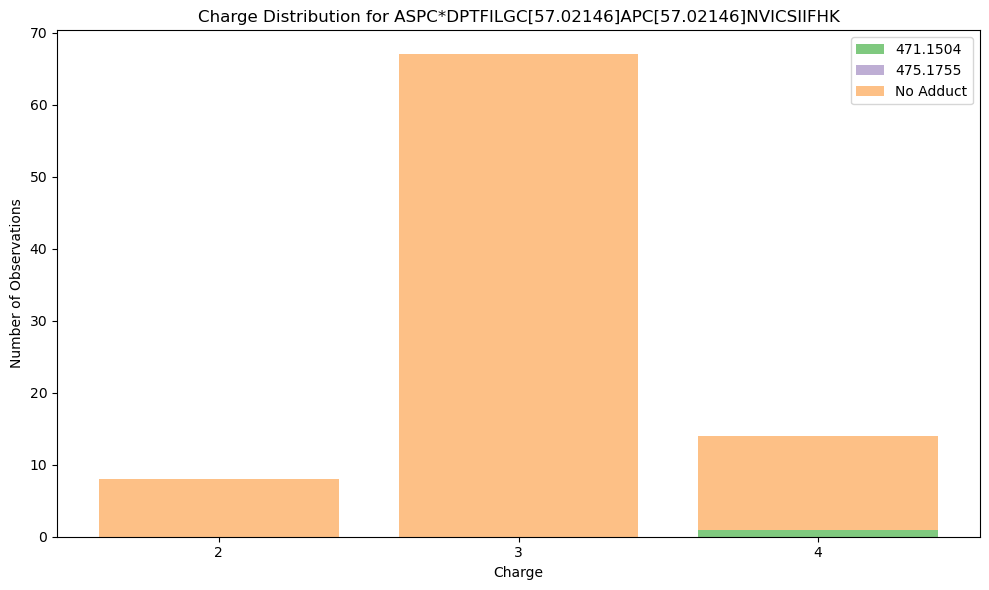

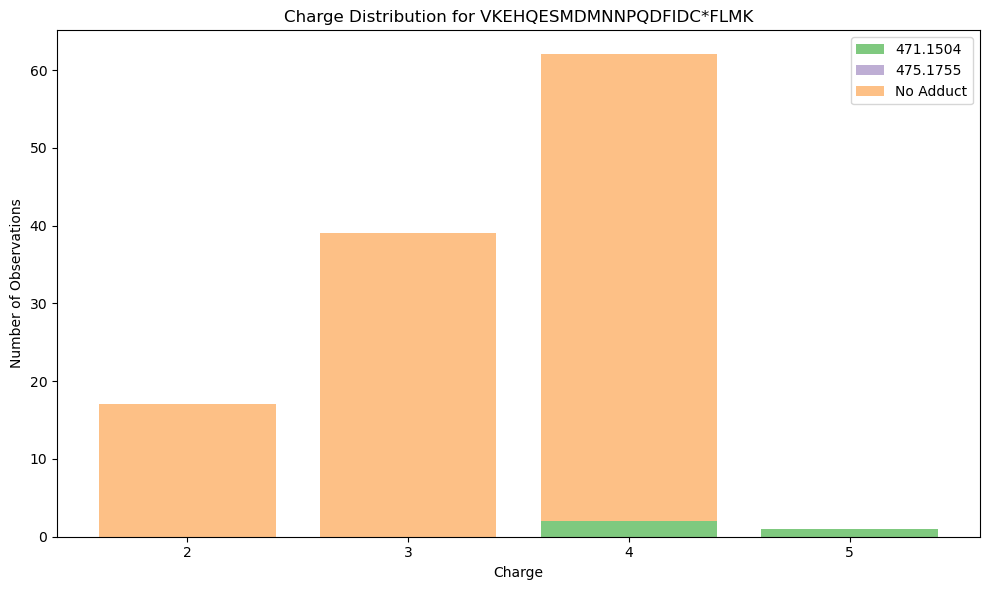

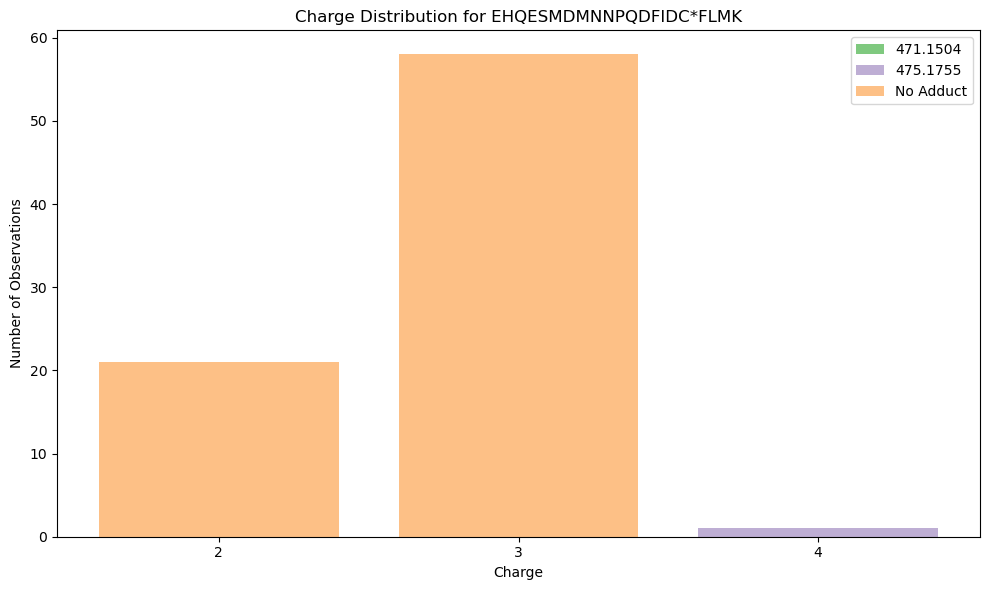

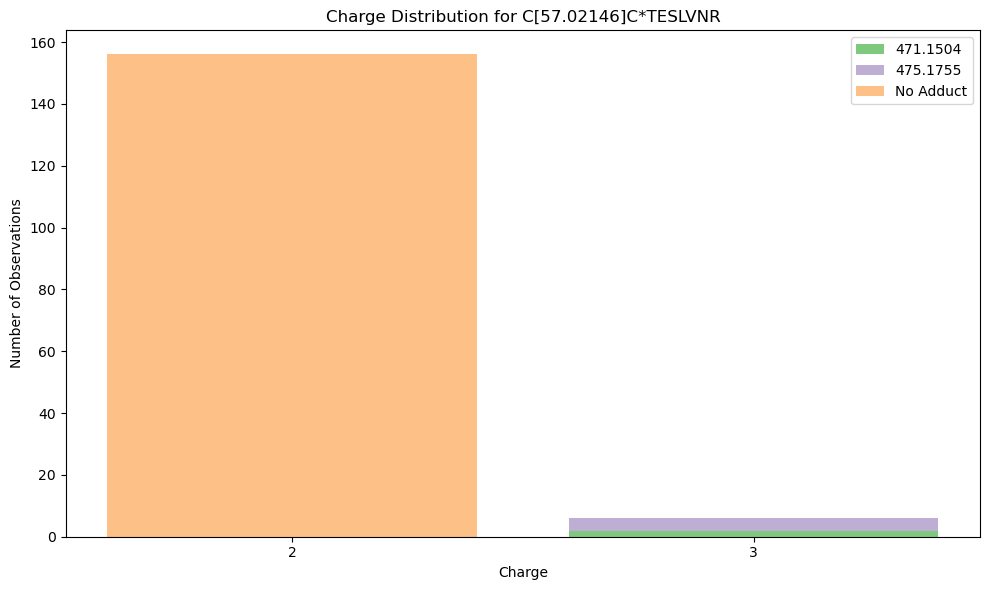

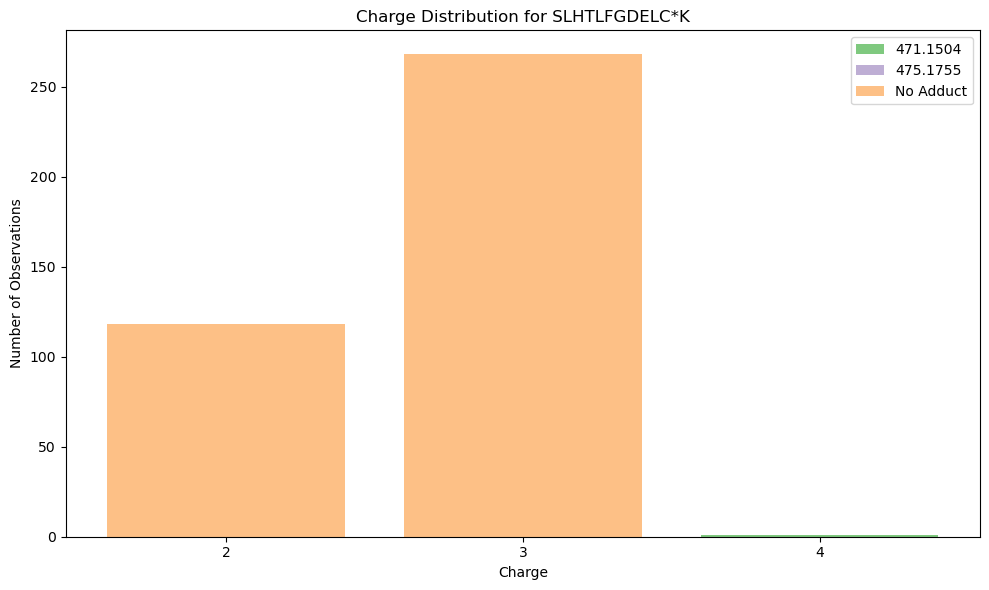

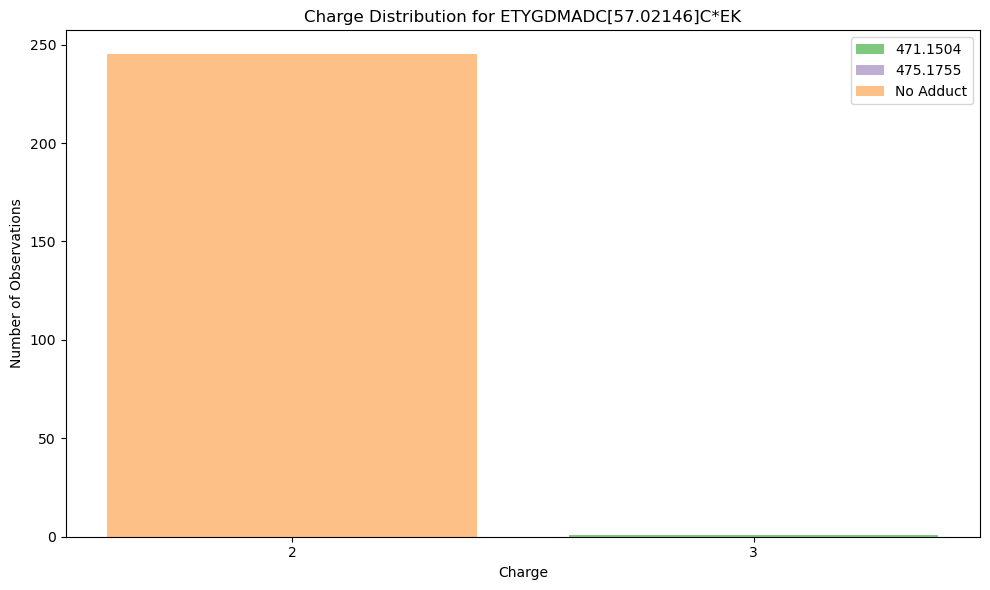

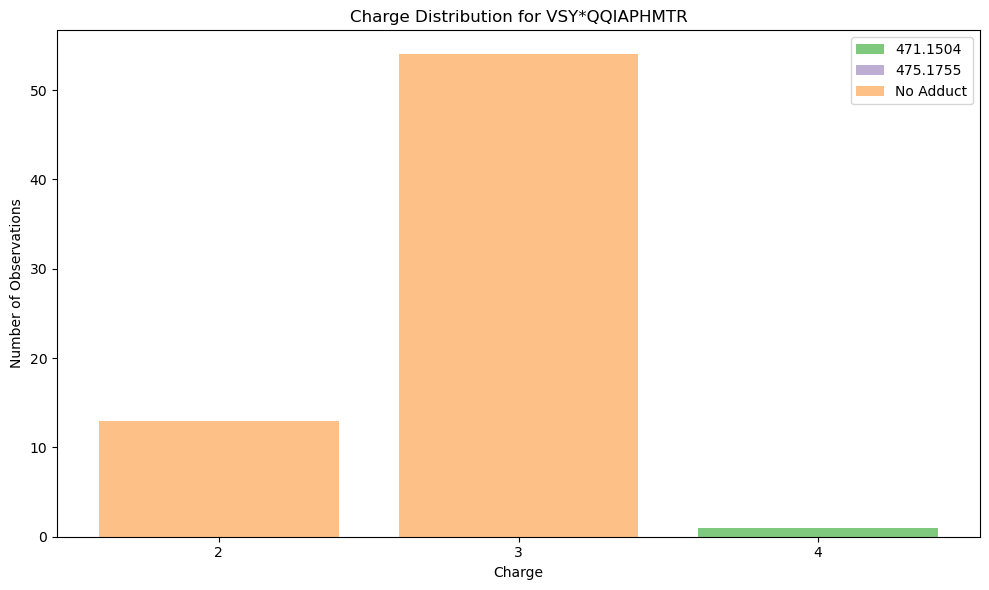

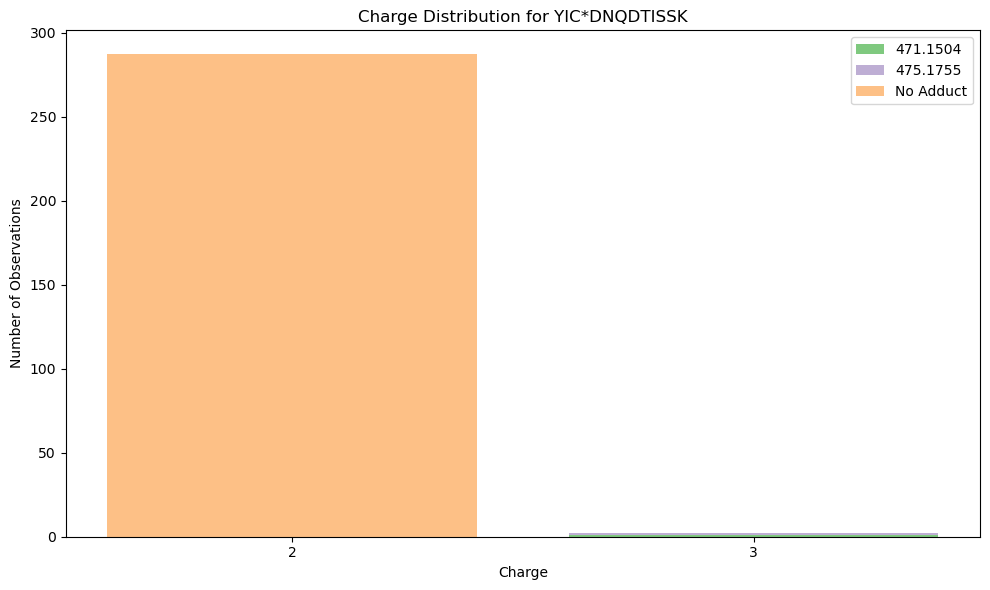

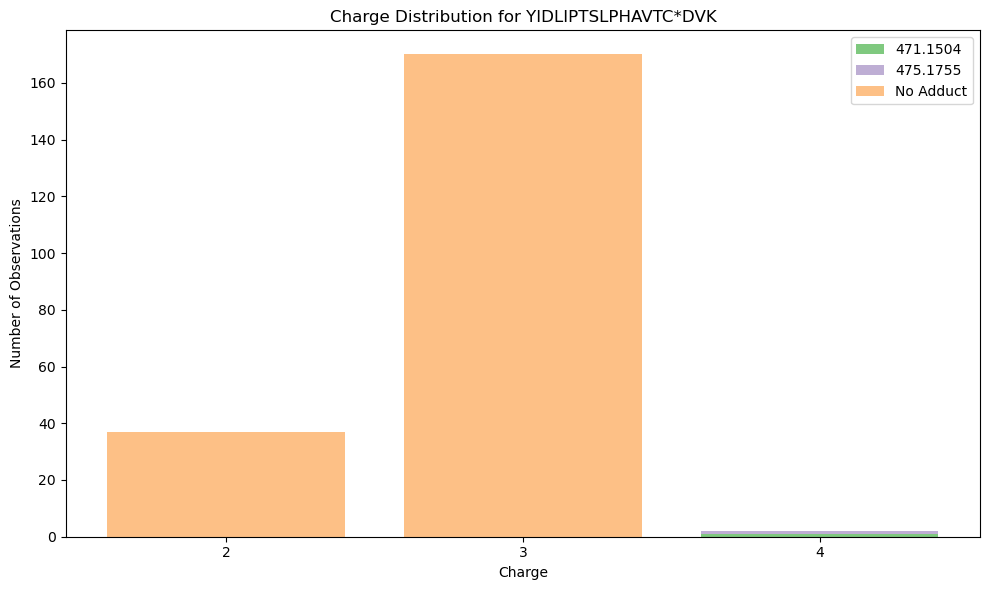

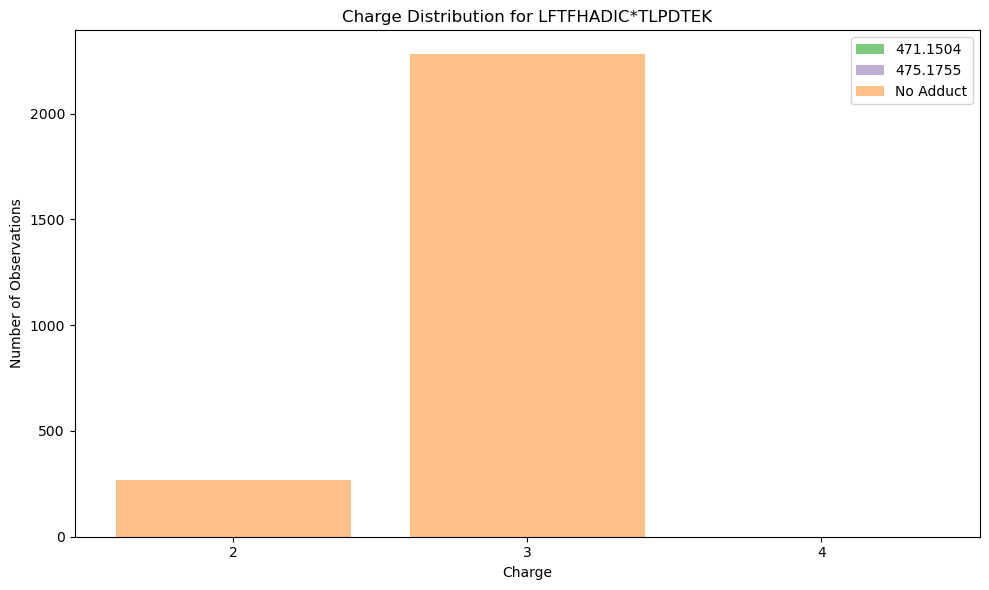

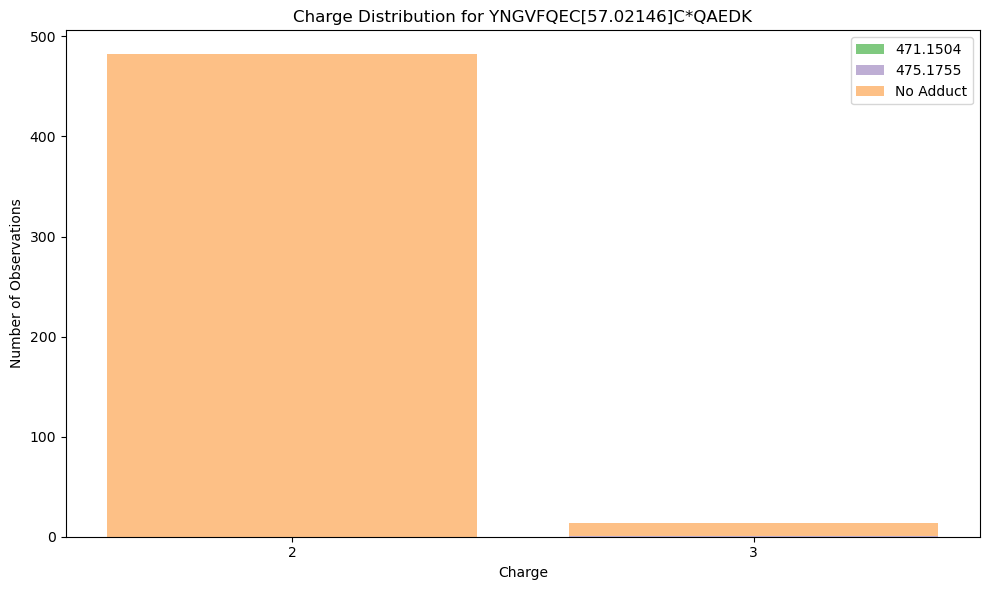

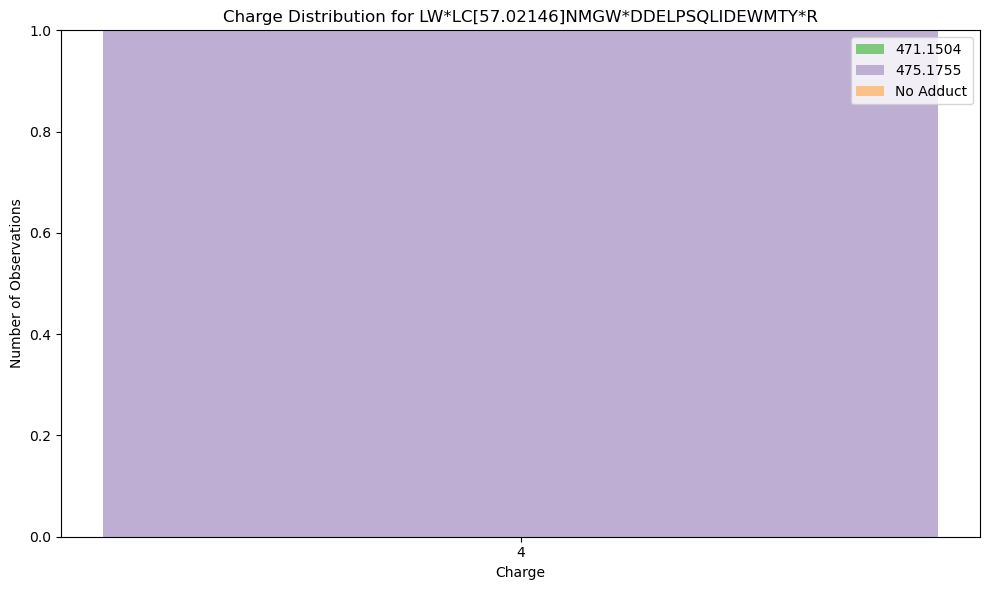

In [15]:
# Iterate over each star_mod_peptide in collected_rows
for star_mod_peptide, mod_dict in collected_rows.items():
    # Initialize empty DataFrames for each modification
    df_471 = pd.DataFrame()
    df_475 = pd.DataFrame()
    df_nomod = pd.DataFrame()
    
    # Check if each modification key exists and assign the corresponding DataFrame
    if '471.1504' in mod_dict:
        df_471 = pd.DataFrame(mod_dict['471.1504'])
    if '475.1755' in mod_dict:
        df_475 = pd.DataFrame(mod_dict['475.1755'])
    if 'nomod' in mod_dict:
        df_nomod = pd.DataFrame(mod_dict['nomod'])
    
    # Extract the charge values and counts for each modification
    charges_471 = df_471['CHARGE'].value_counts() if not df_471.empty else pd.Series()
    charges_475 = df_475['CHARGE'].value_counts() if not df_475.empty else pd.Series()
    charges_nomod = df_nomod['CHARGE'].value_counts() if not df_nomod.empty else pd.Series()
    
    # Get the unique charge values across all modifications
    unique_charges = sorted(set(charges_471.index) | set(charges_475.index) | set(charges_nomod.index))
    
    # Create lists to store the counts for each modification and charge value
    counts_471 = [charges_471.get(charge, 0) for charge in unique_charges]
    counts_475 = [charges_475.get(charge, 0) for charge in unique_charges]
    counts_nomod = [charges_nomod.get(charge, 0) for charge in unique_charges]
    
    # Create the stacked bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(unique_charges, counts_471, label='471.1504')
    plt.bar(unique_charges, counts_475, bottom=counts_471, label='475.1755')
    plt.bar(unique_charges, counts_nomod, bottom=[sum(x) for x in zip(counts_471, counts_475)], label='No Adduct')
    
    # Add labels and title
    plt.xlabel('Charge')
    plt.ylabel('Number of Observations')
    plt.title(f'Charge Distribution for {star_mod_peptide}')
    plt.xticks(unique_charges)
    plt.legend()
    
    # Display the plot
    plt.tight_layout()
    plt.show()

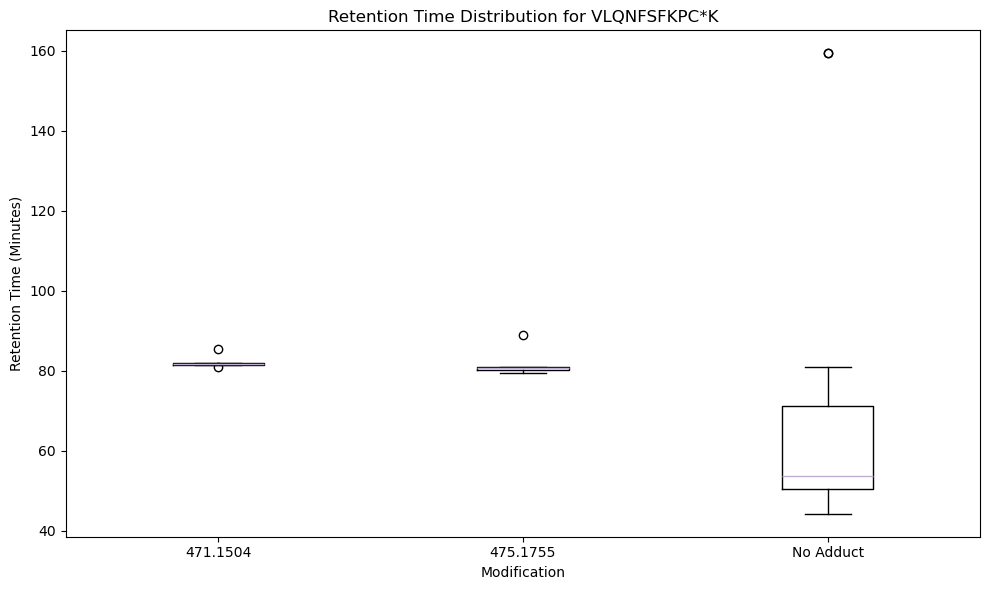

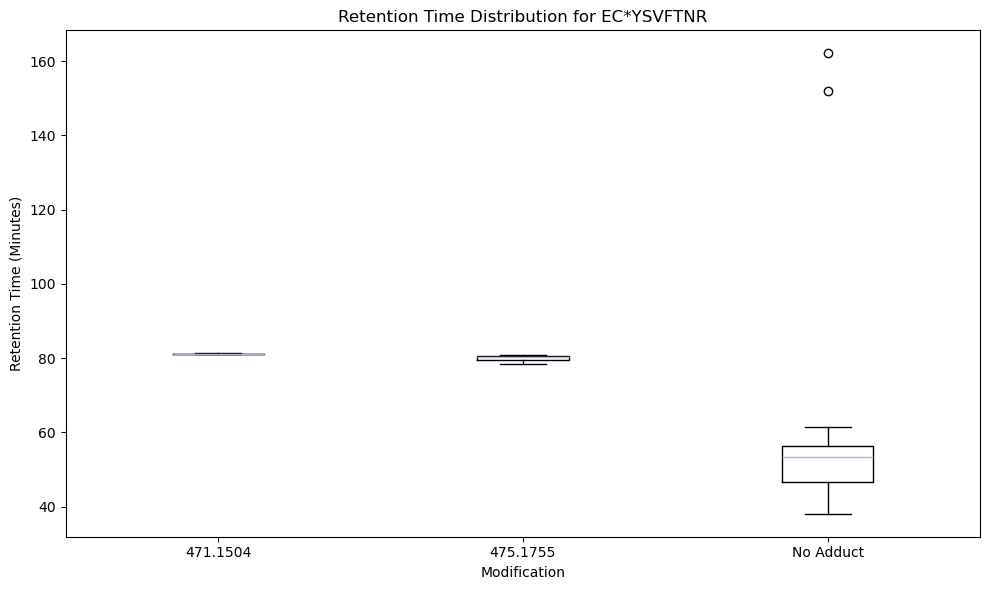

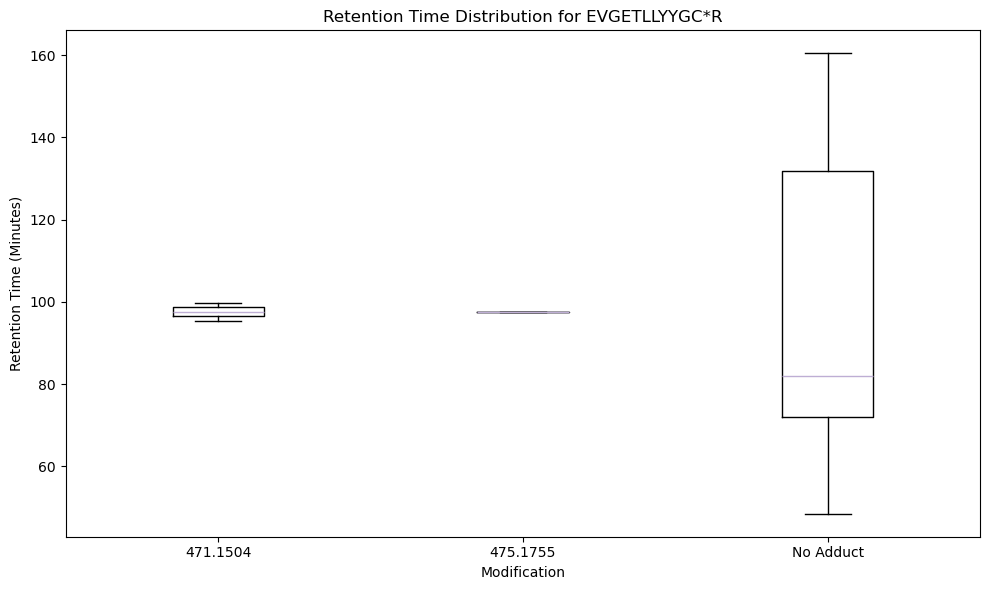

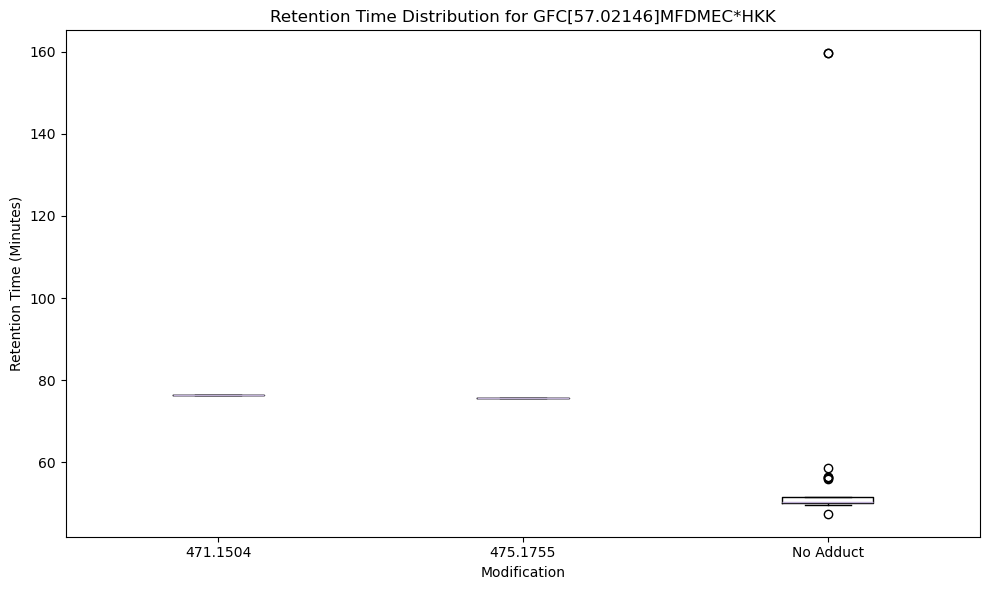

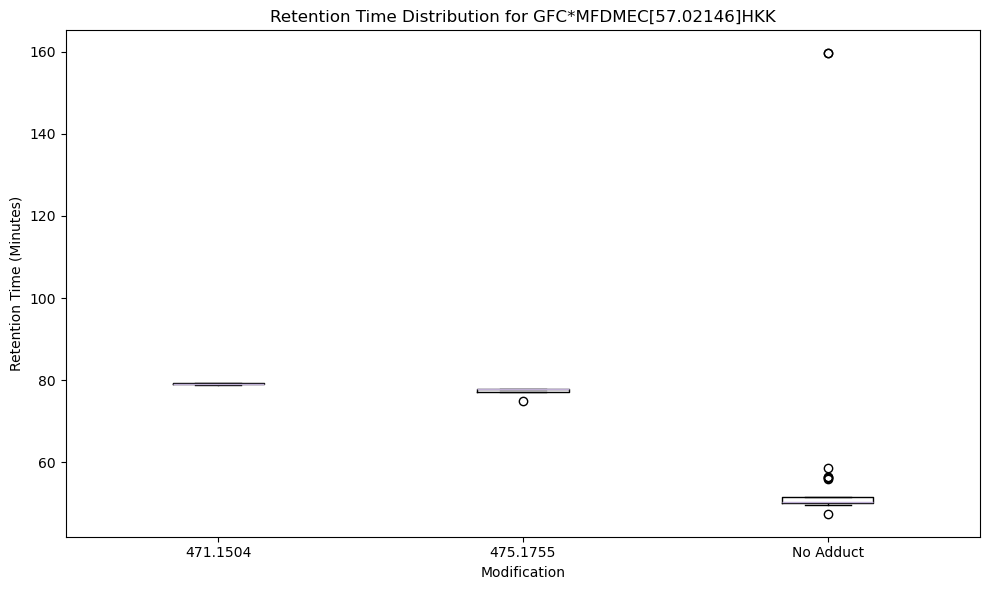

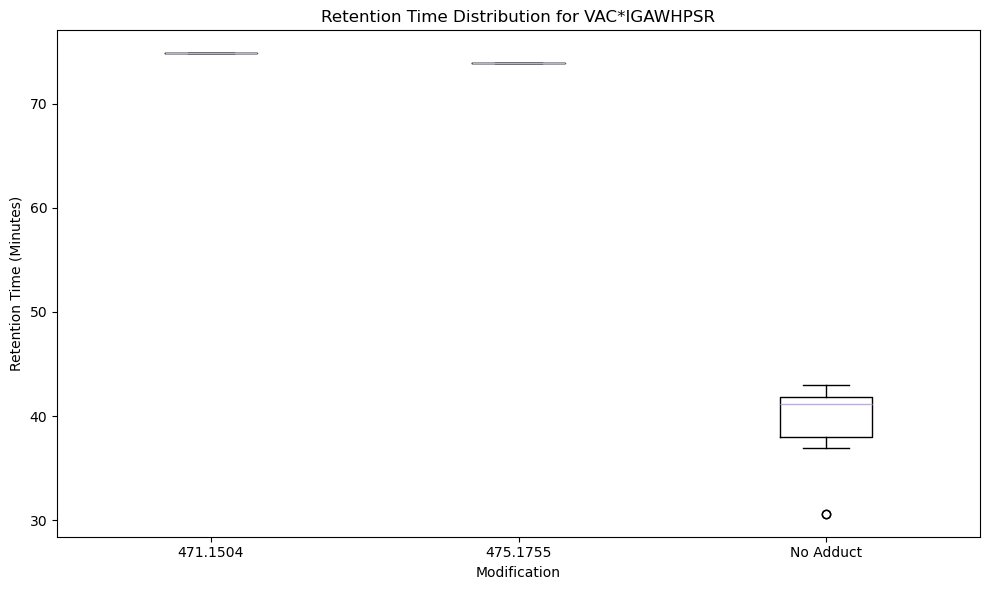

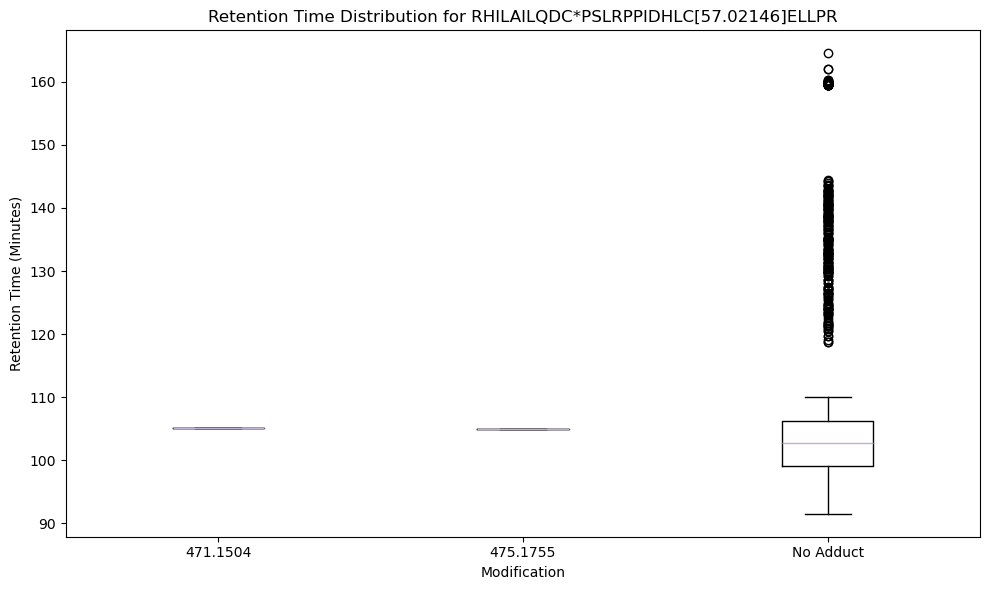

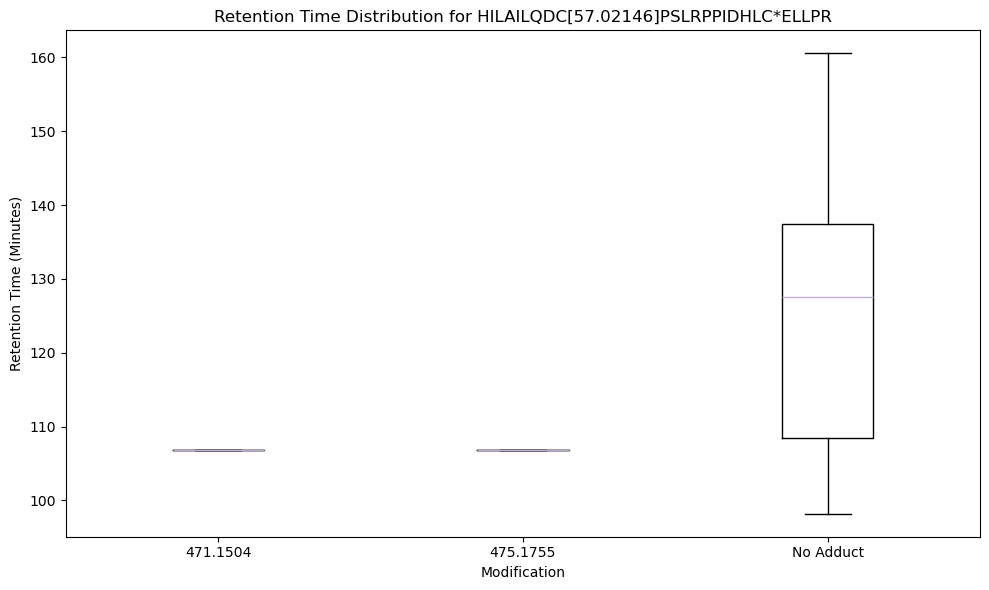

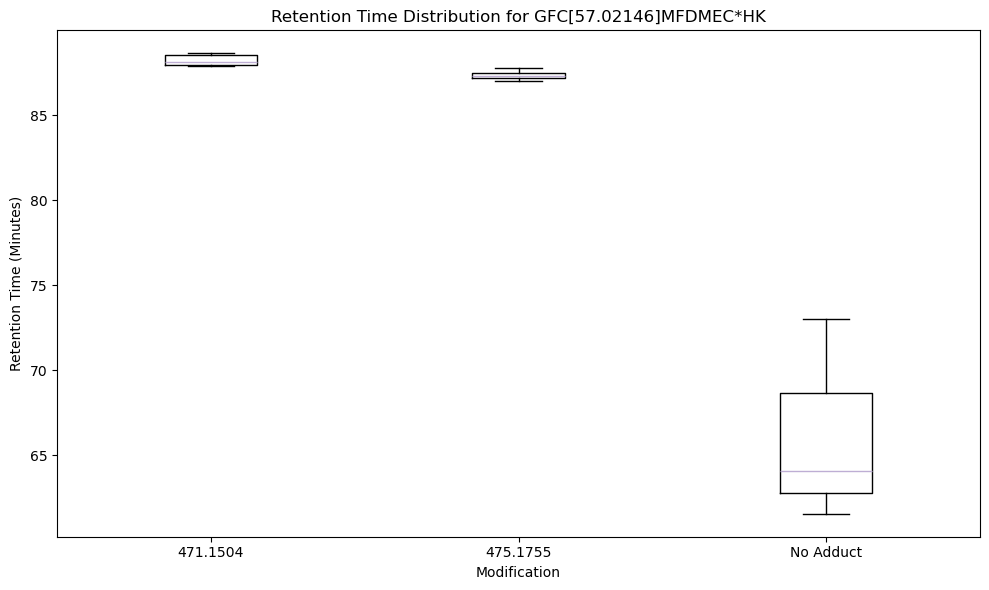

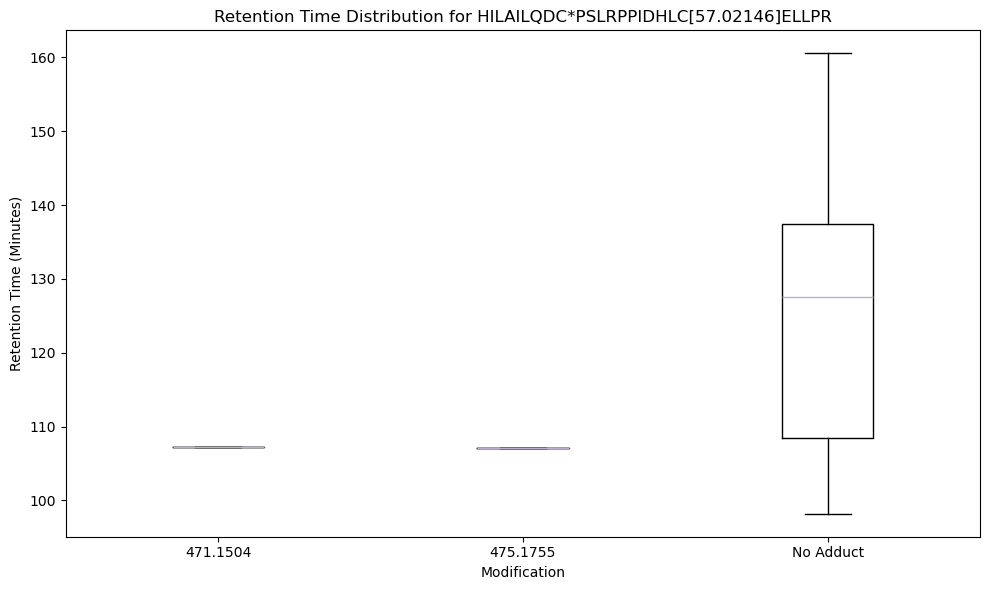

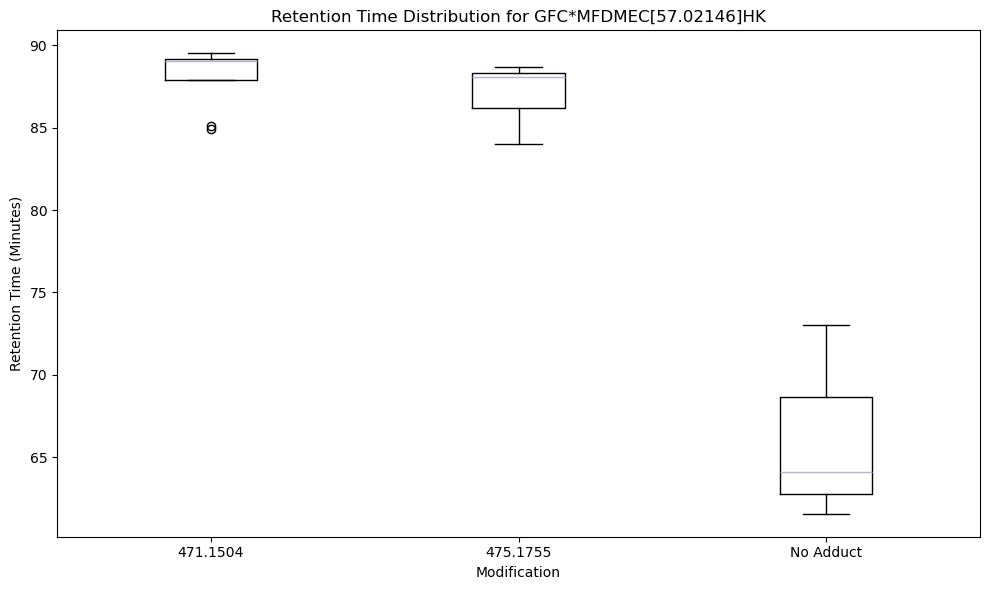

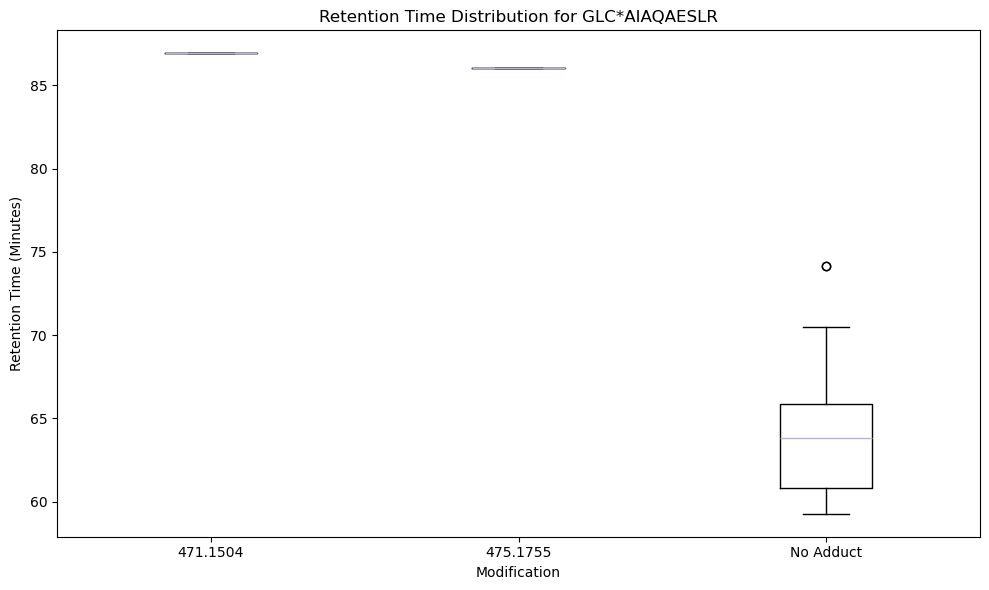

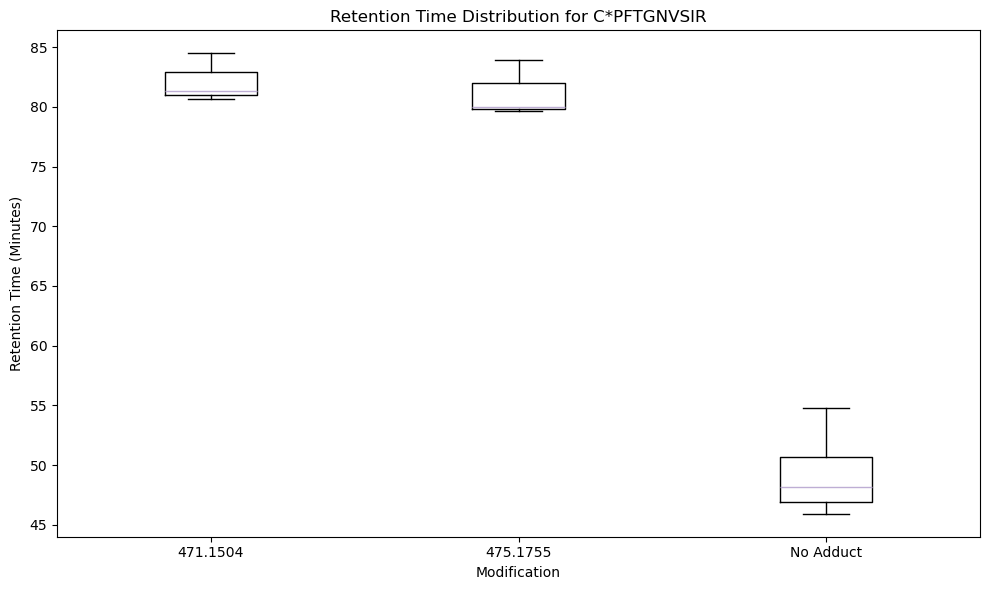

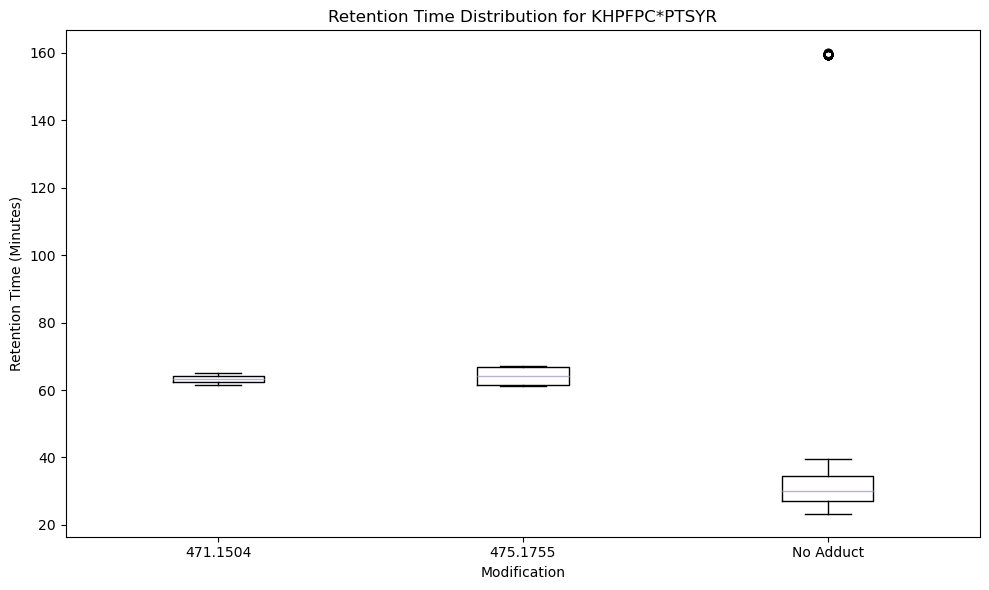

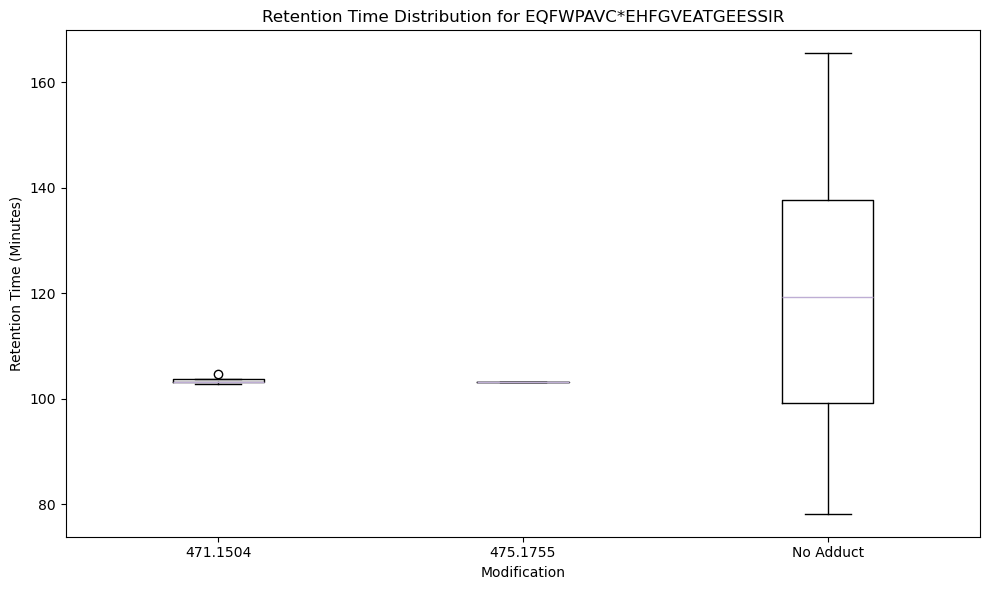

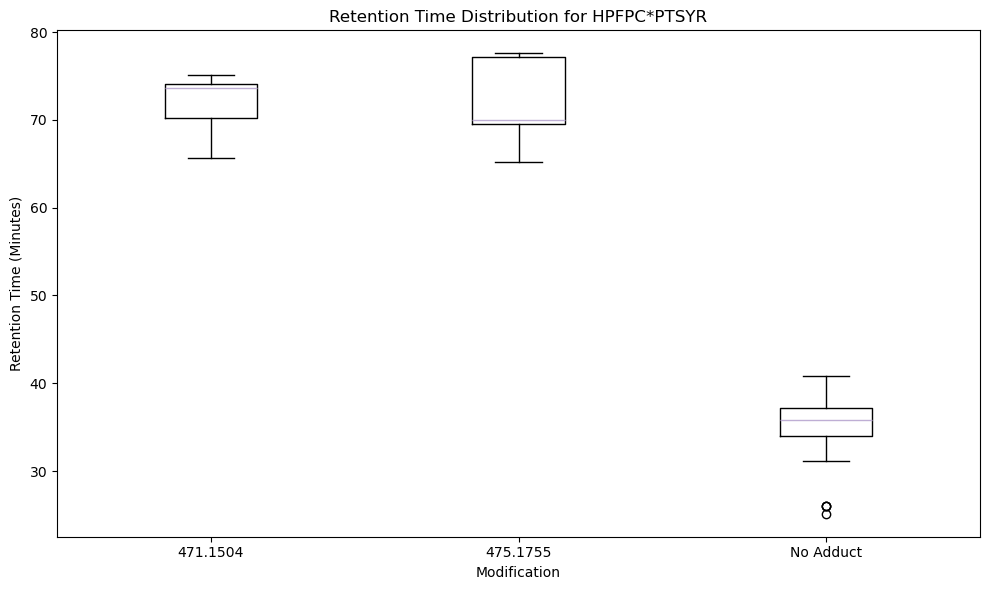

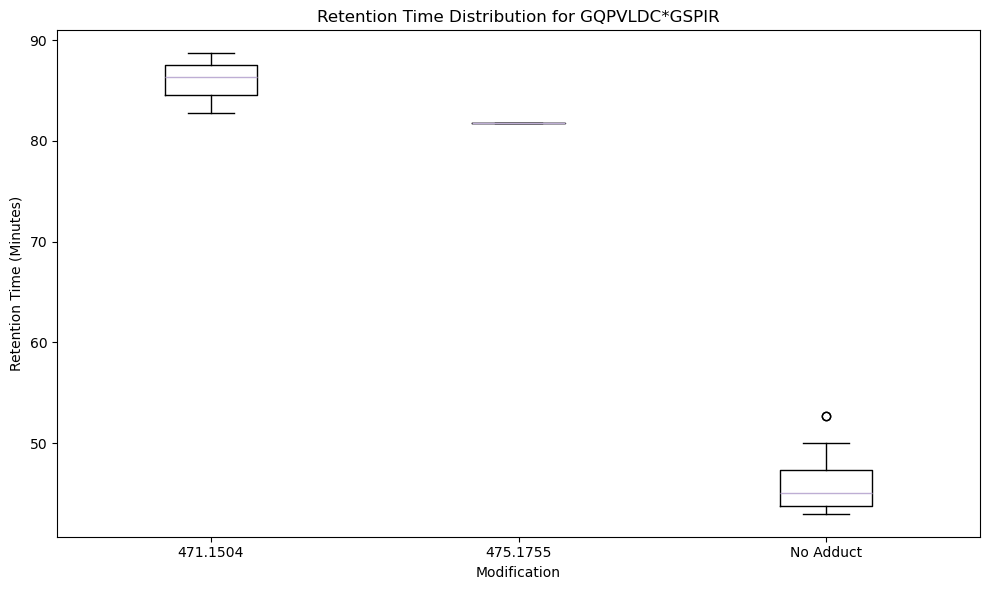

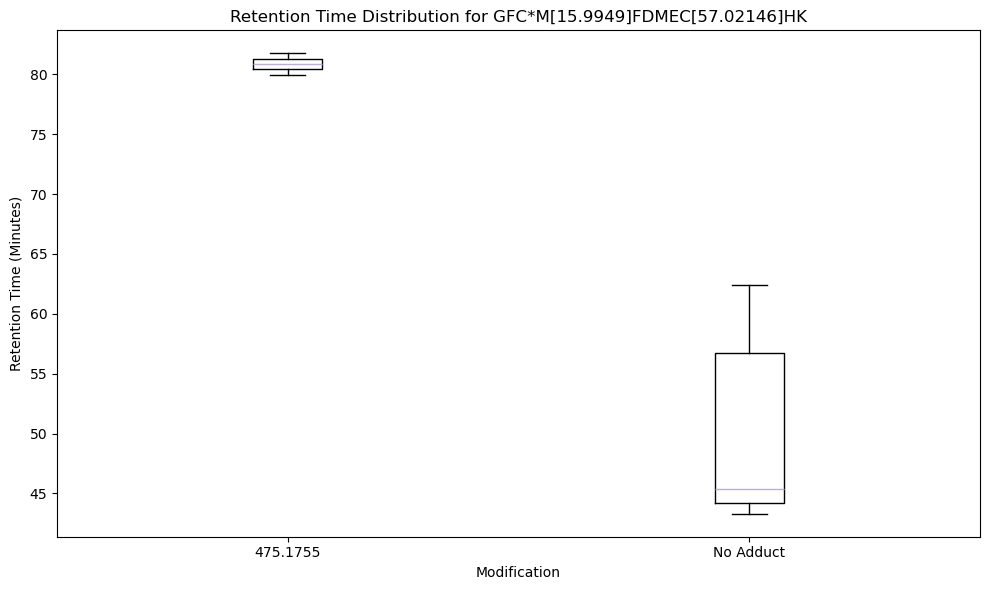

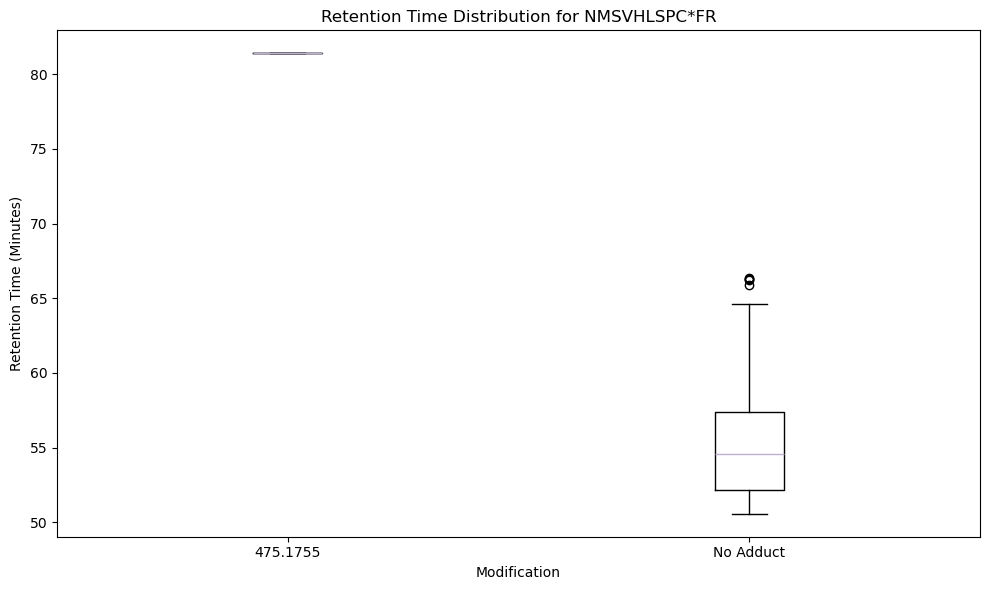

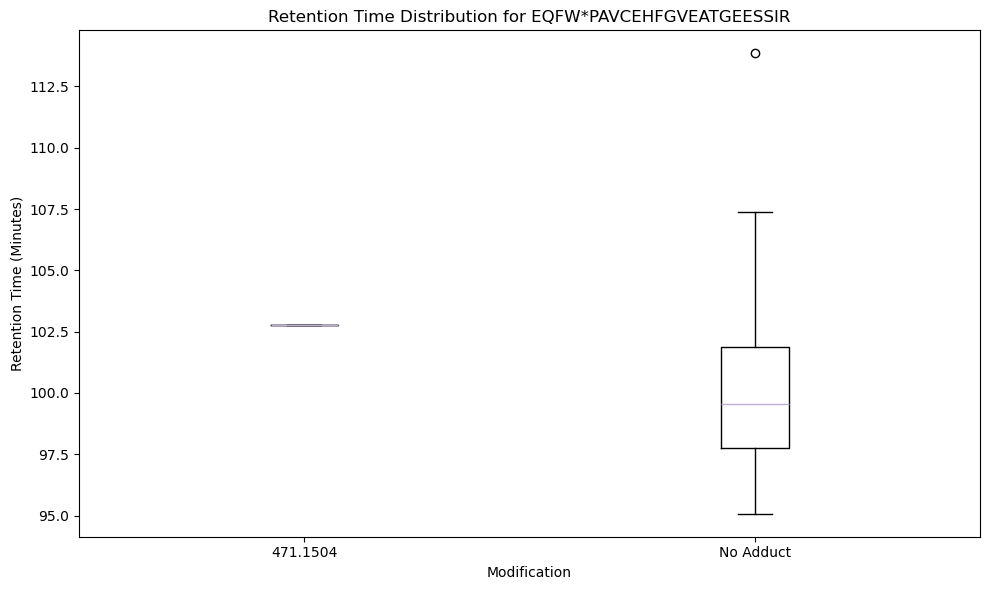

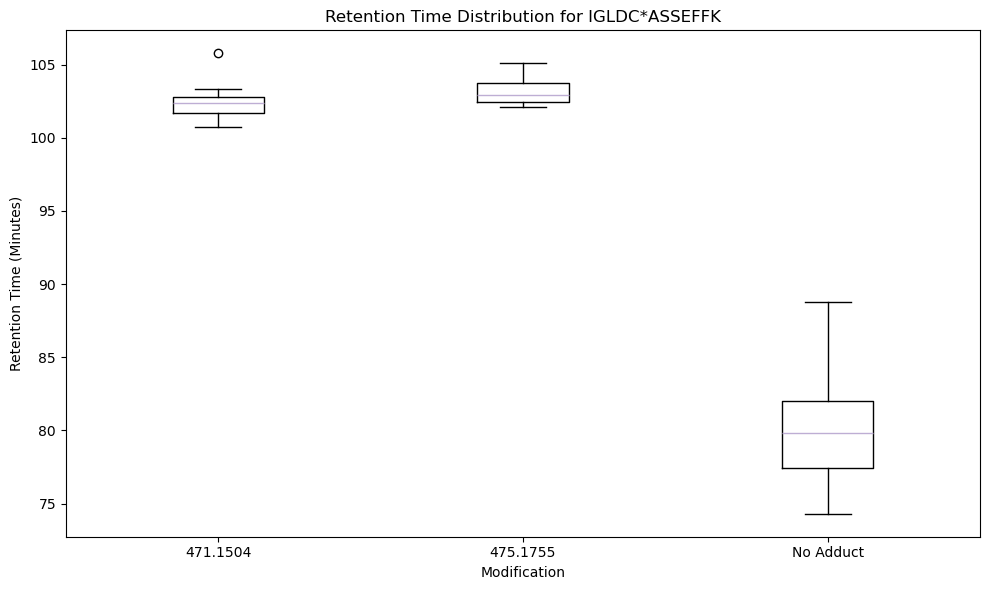

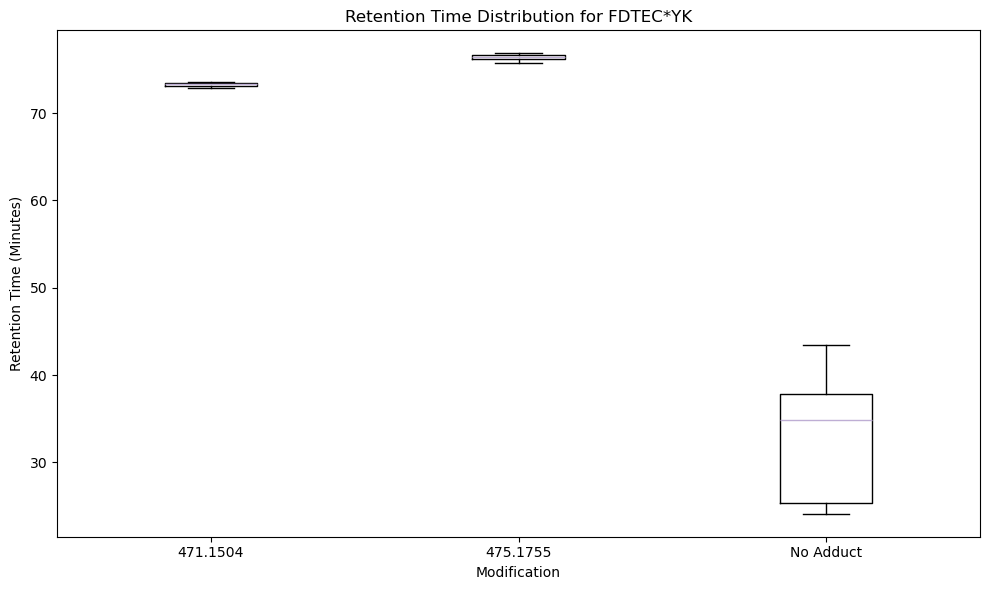

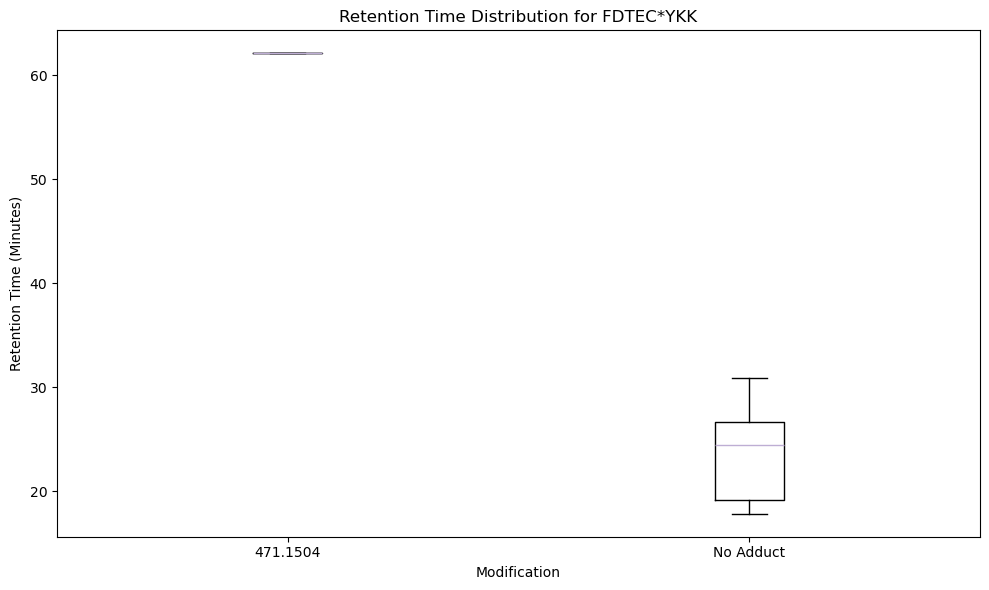

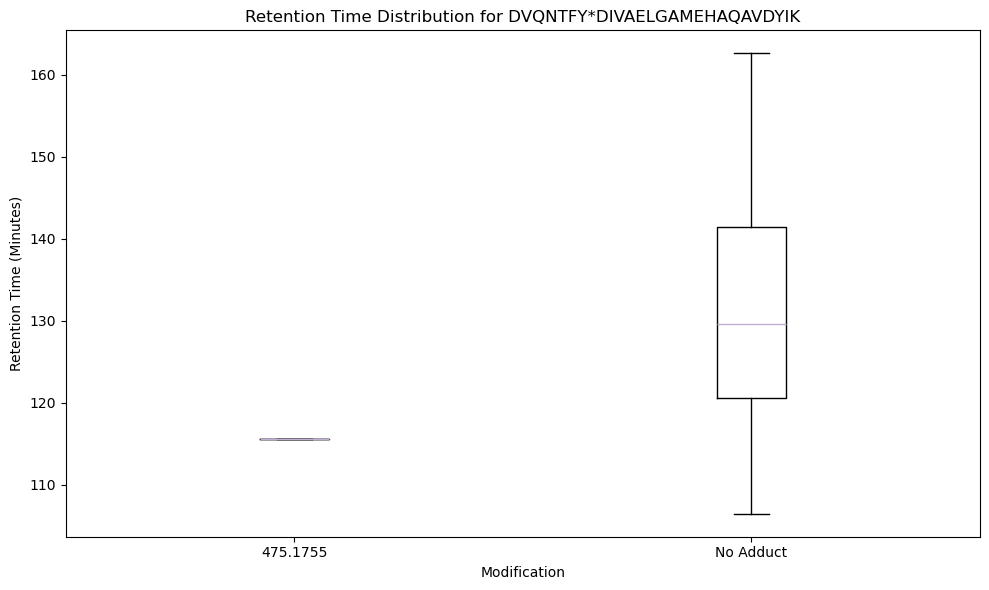

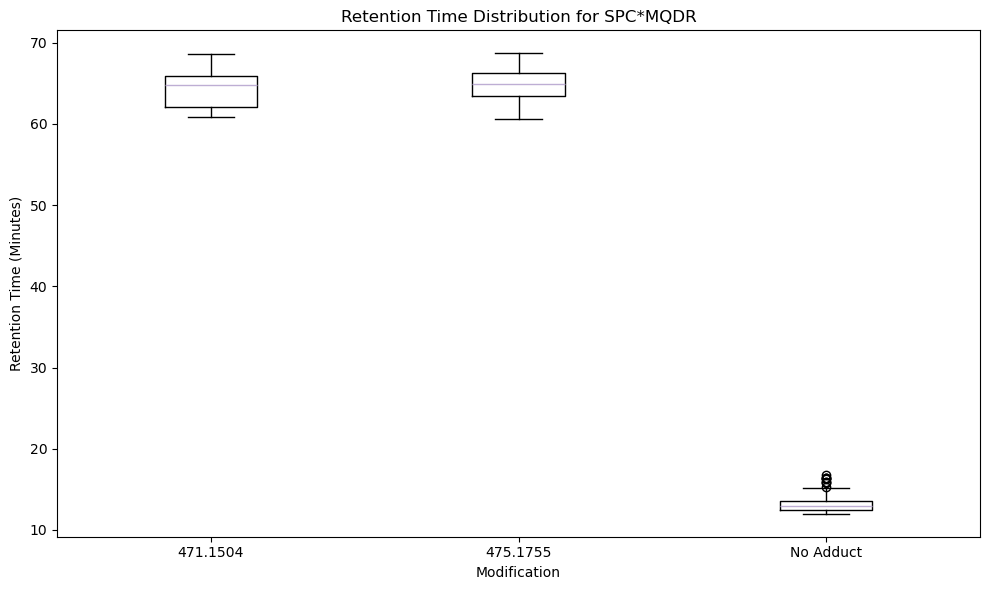

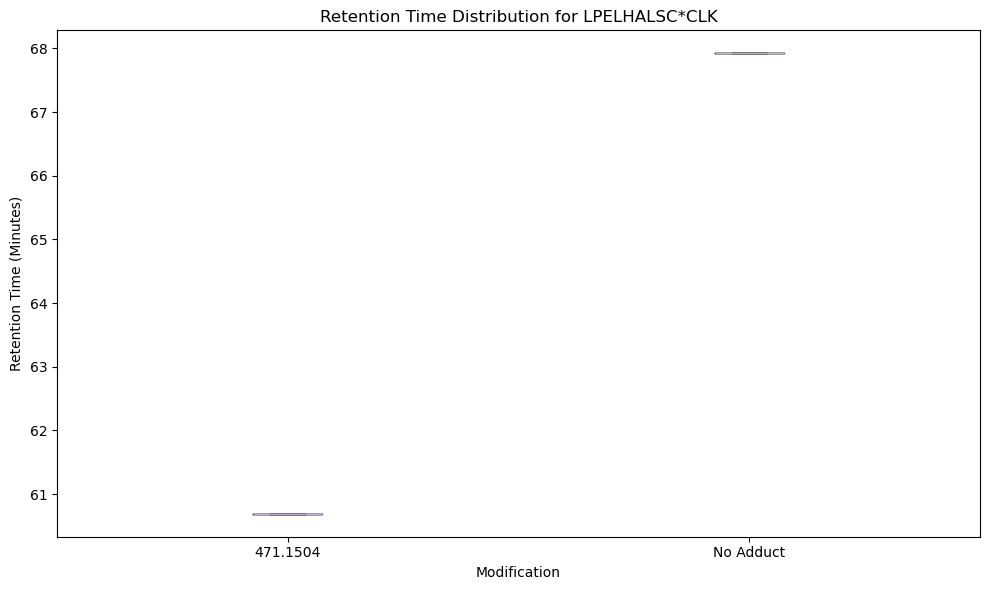

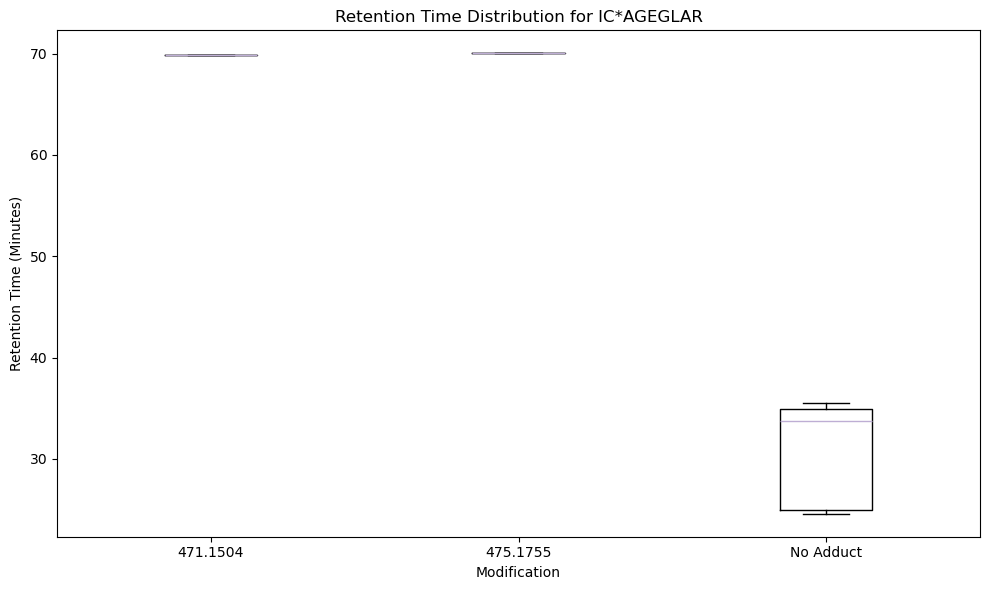

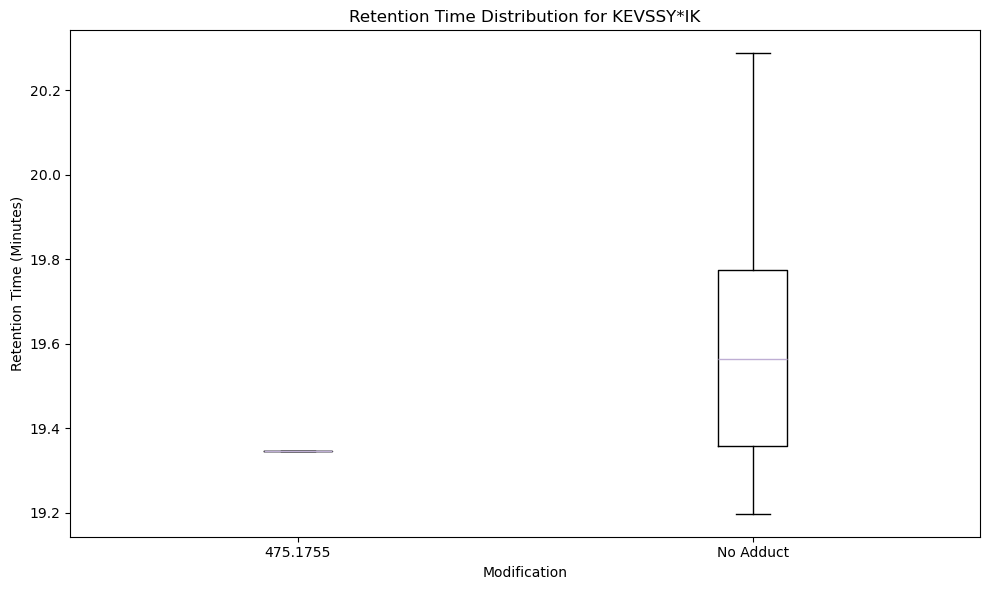

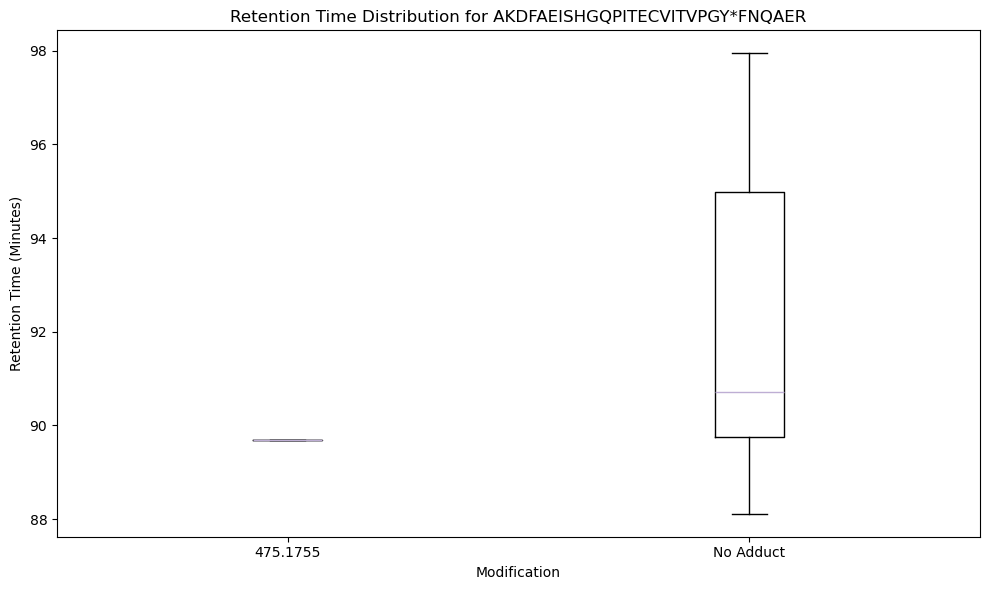

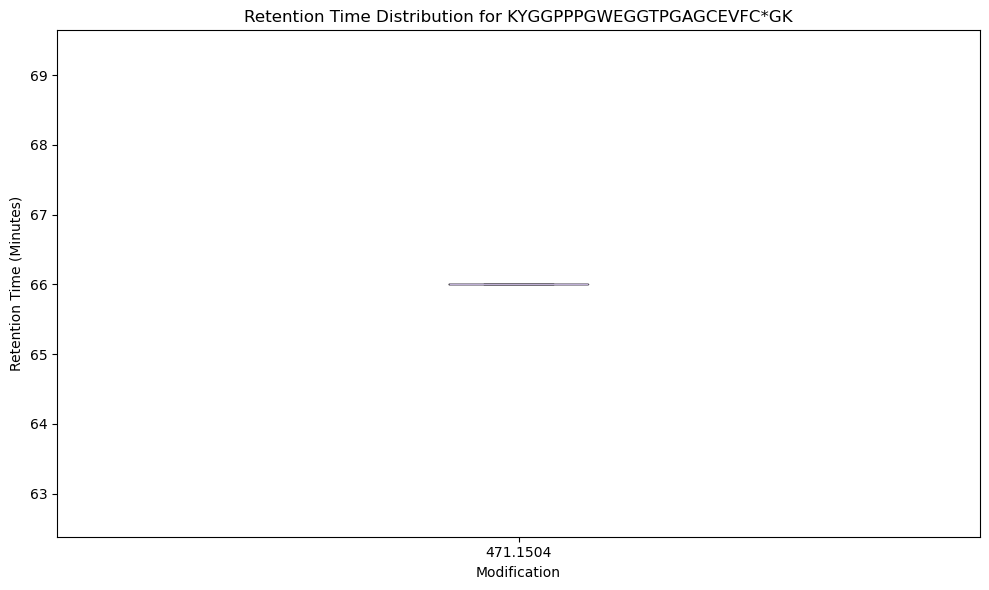

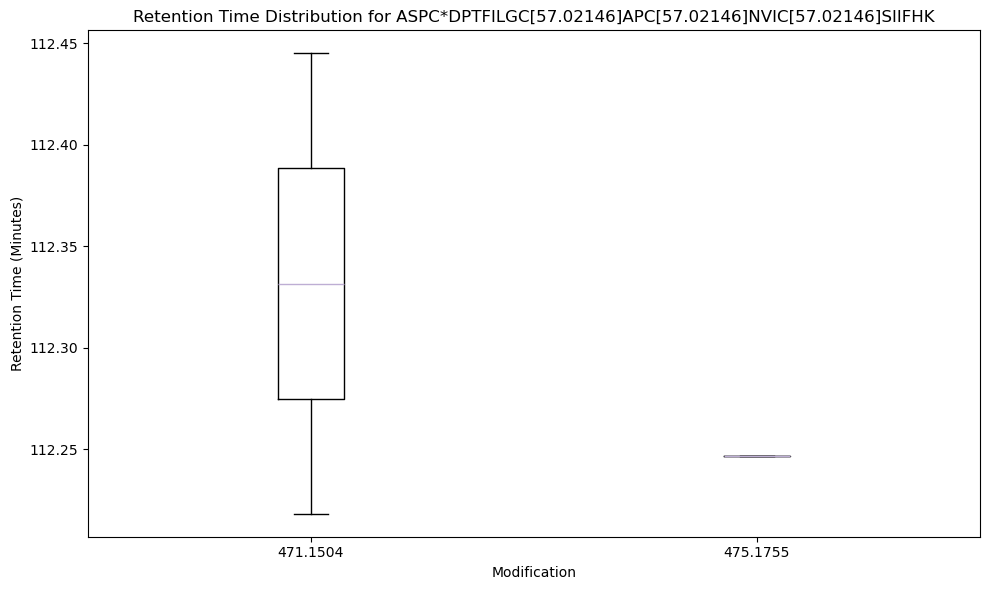

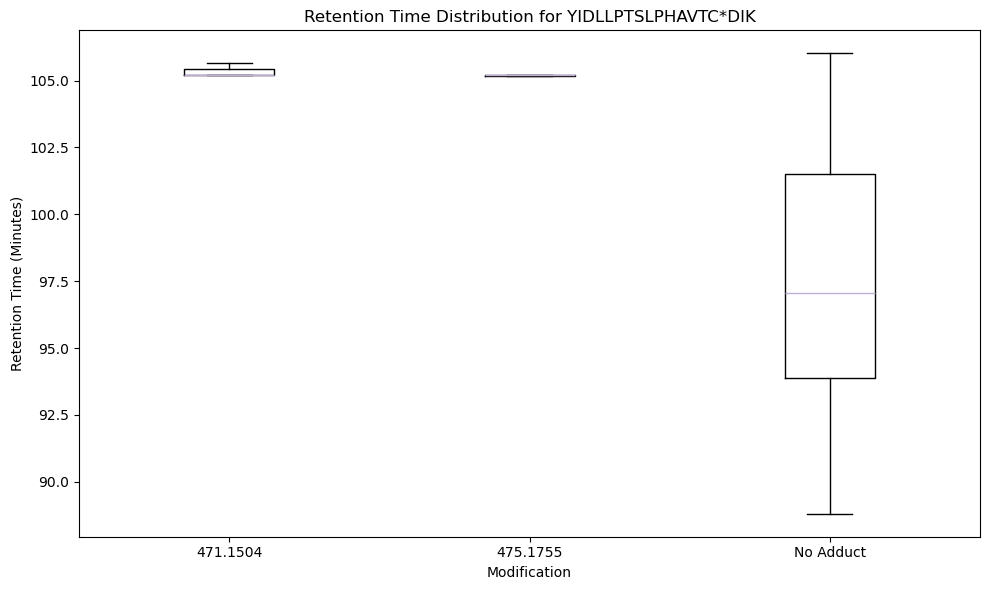

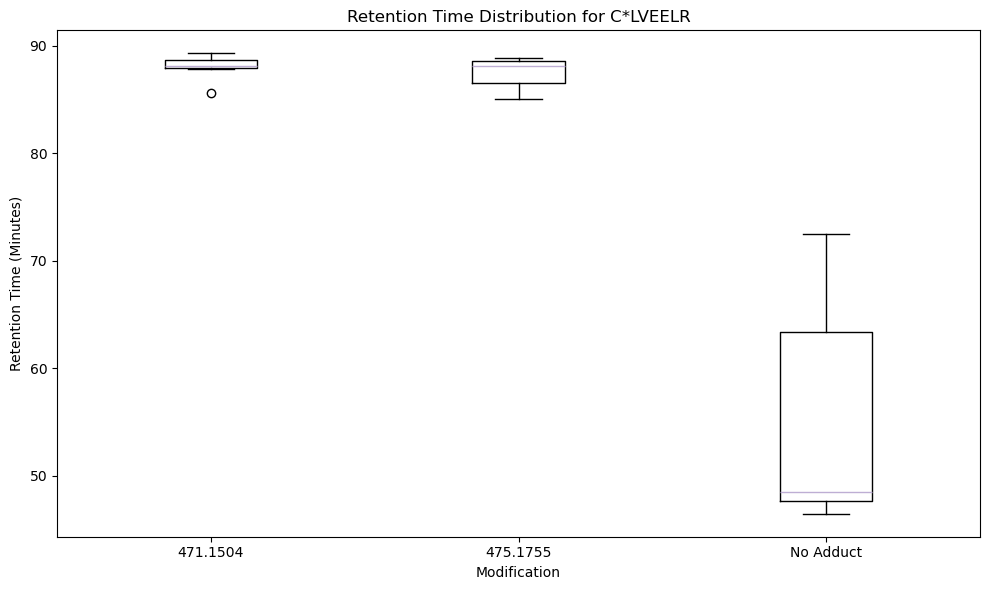

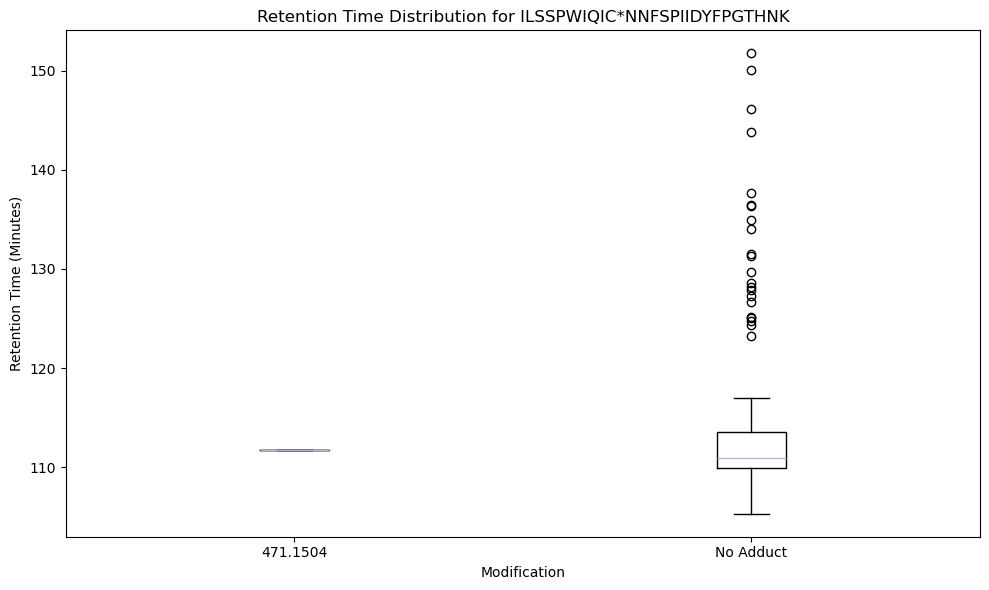

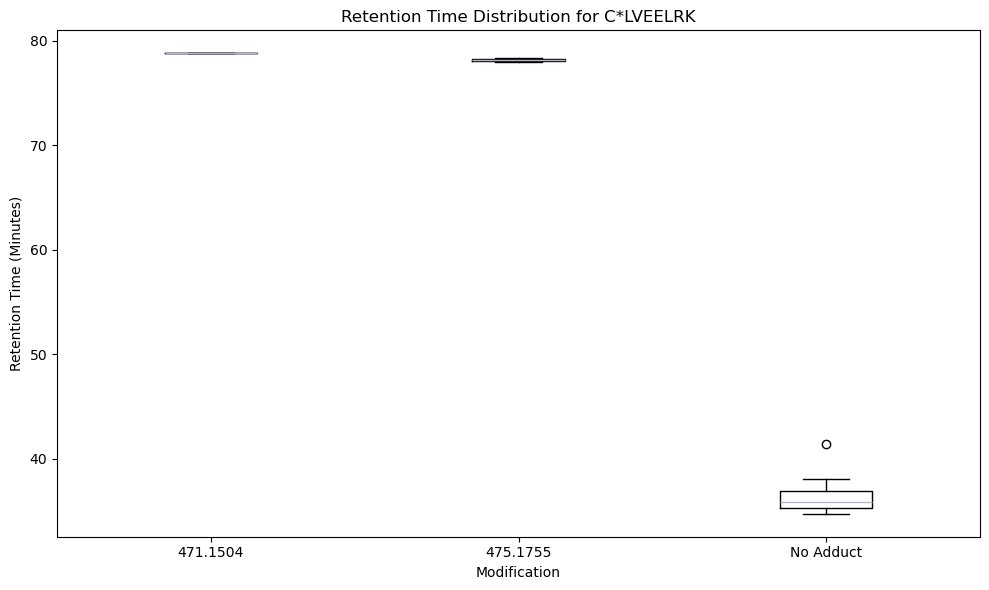

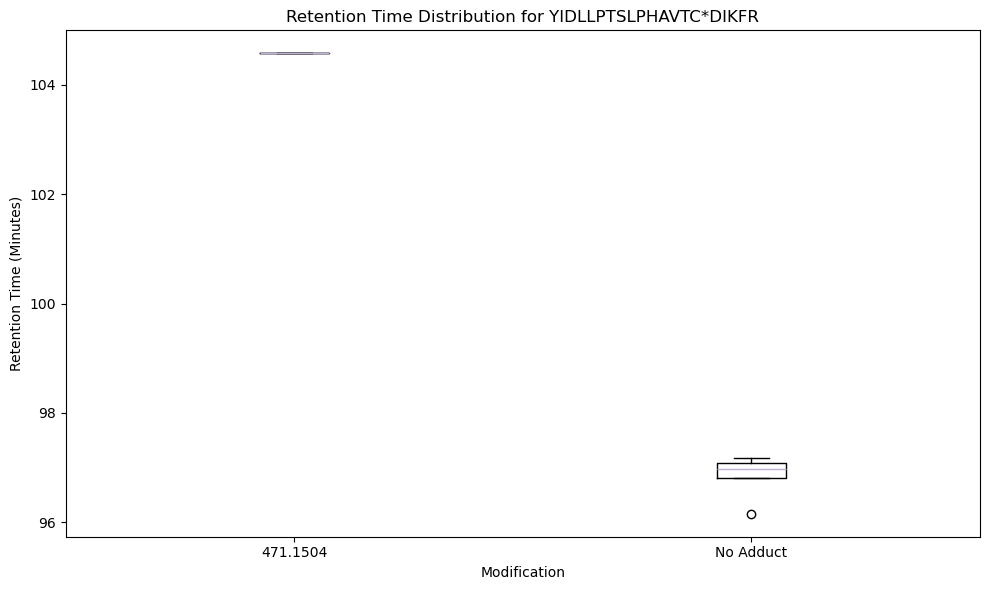

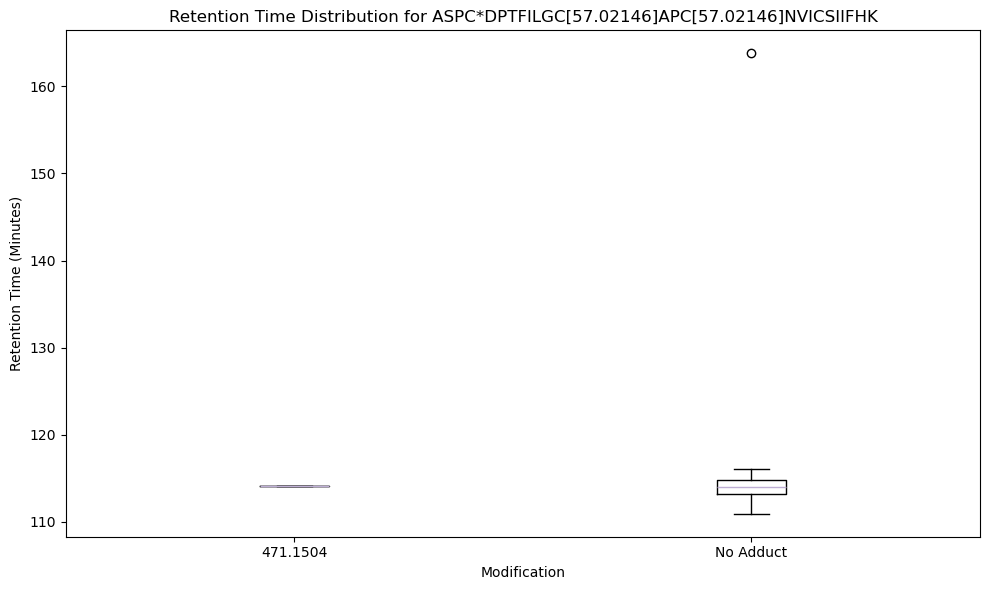

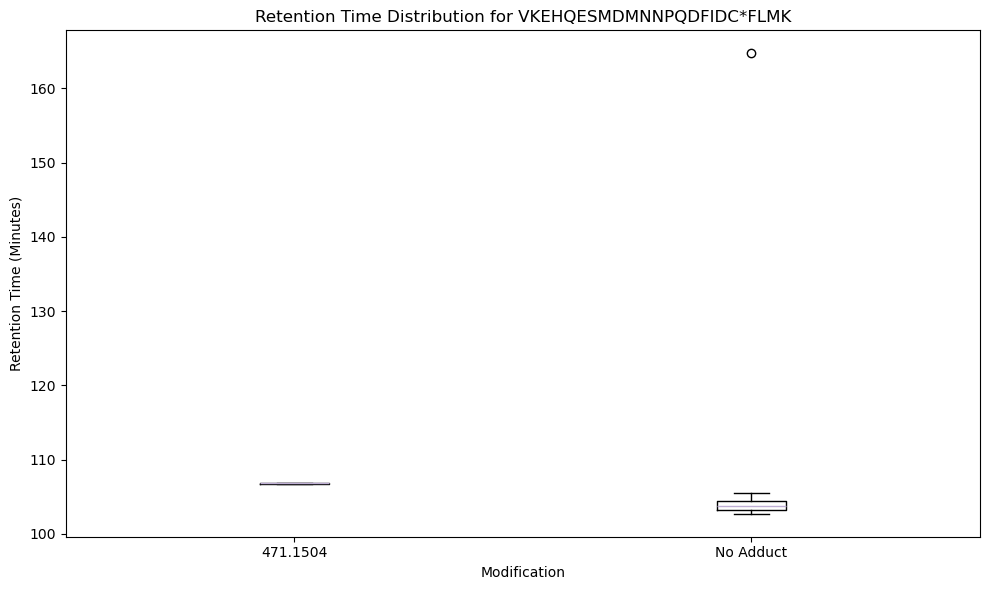

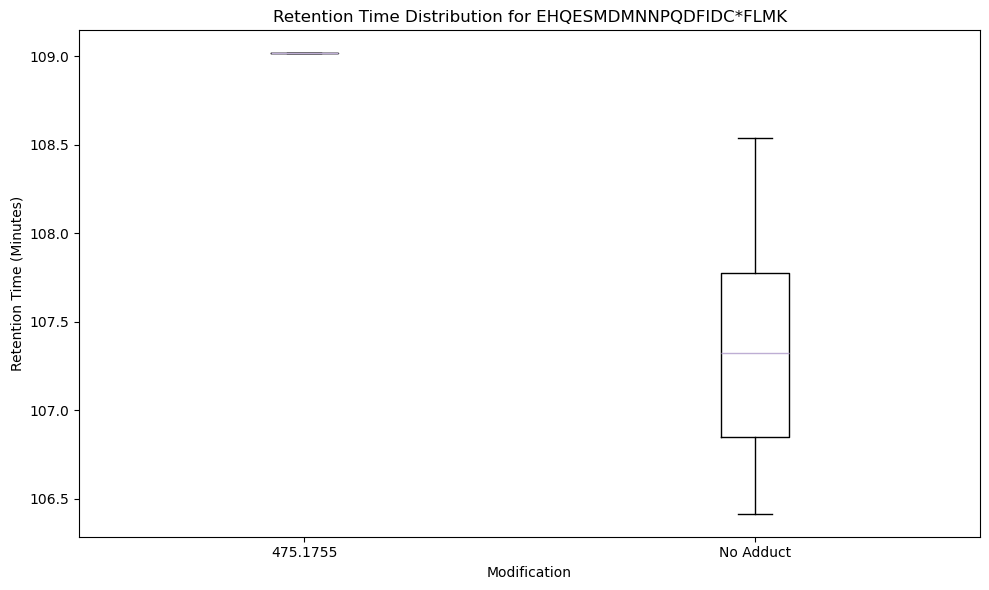

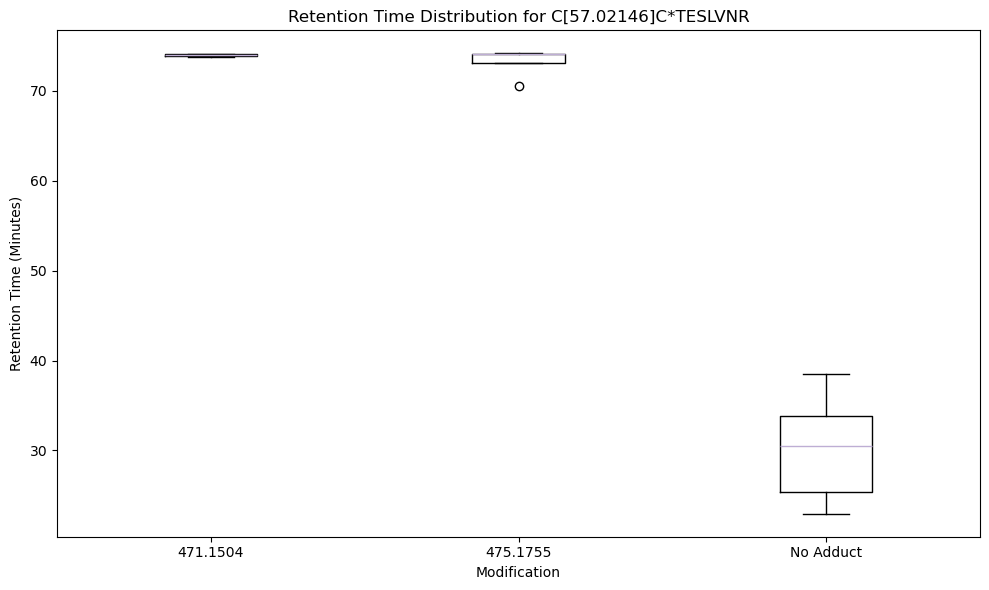

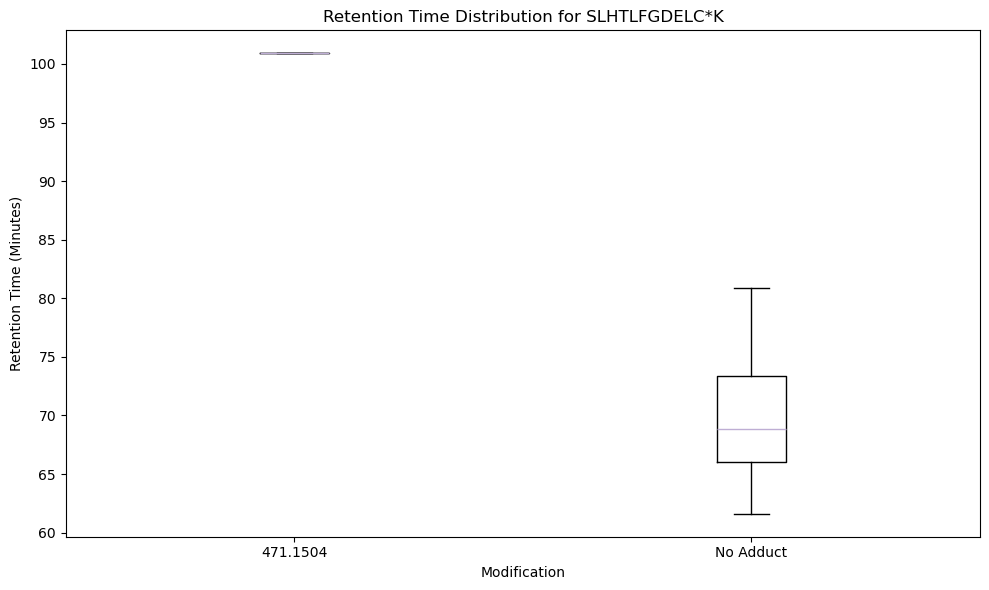

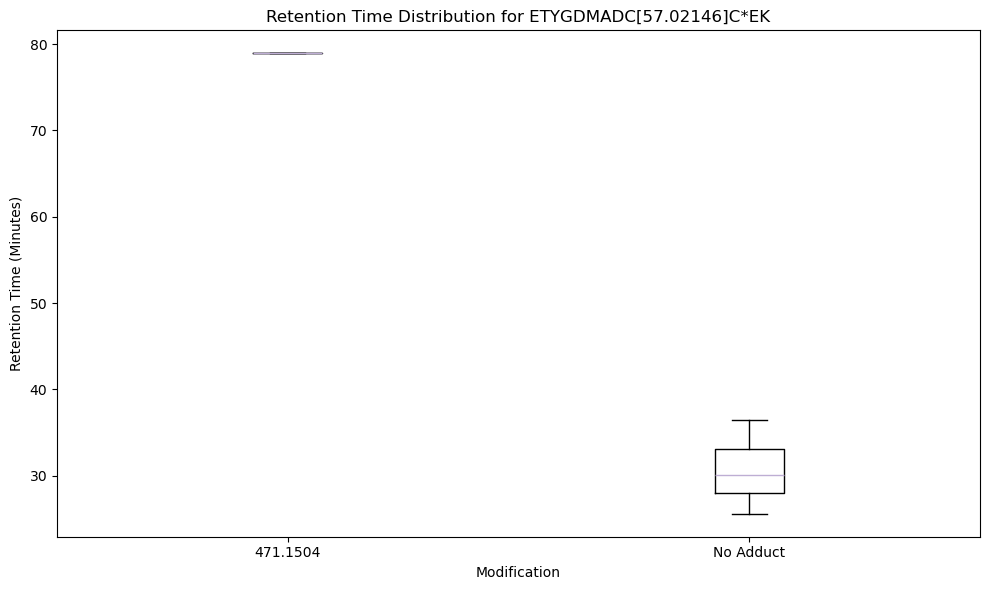

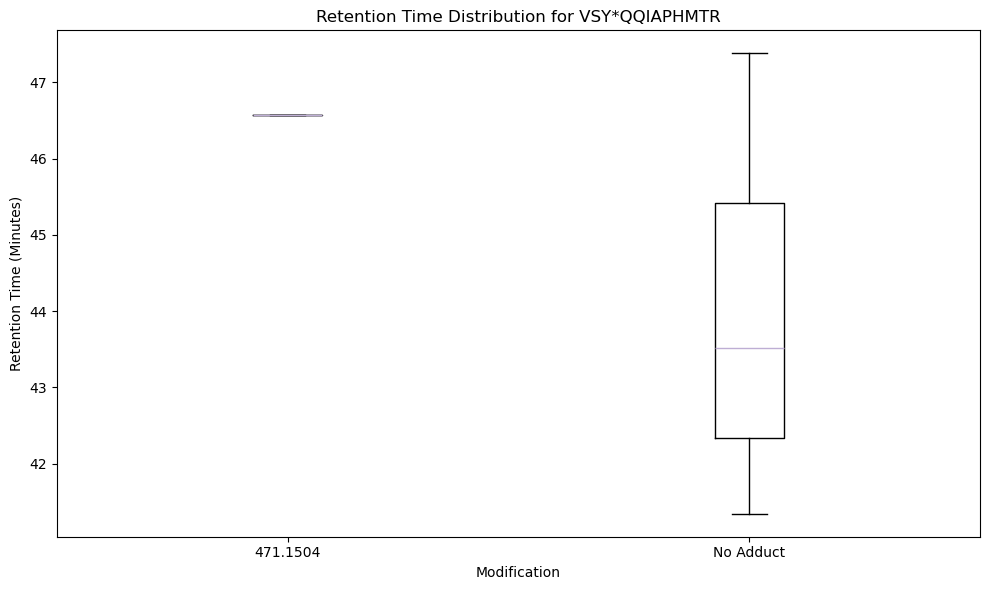

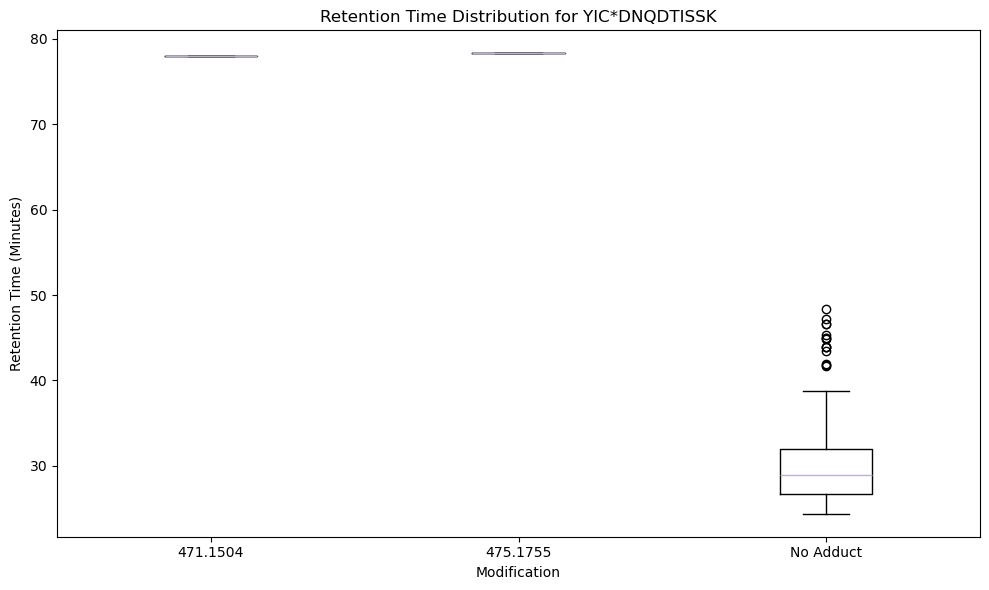

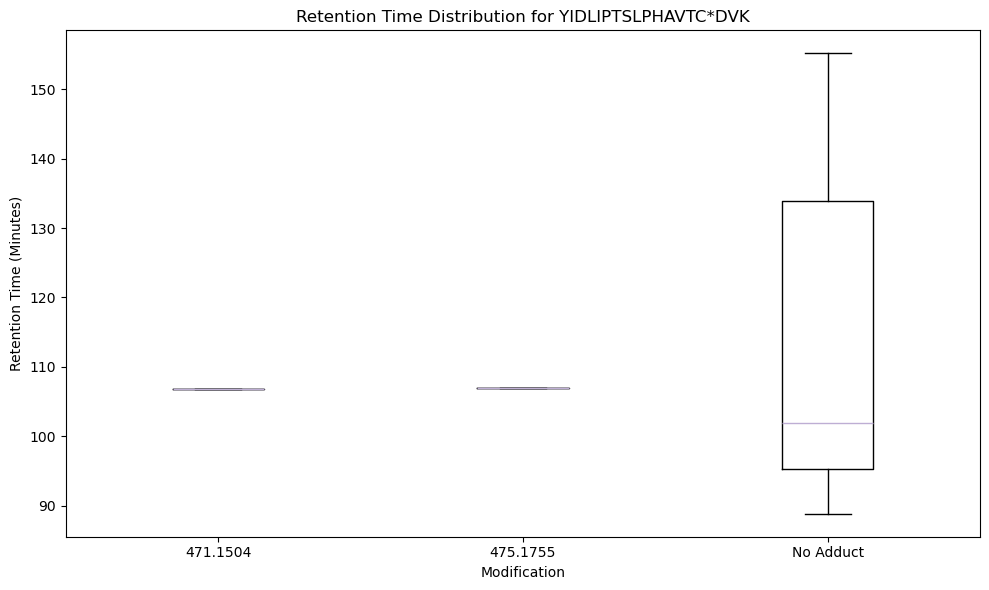

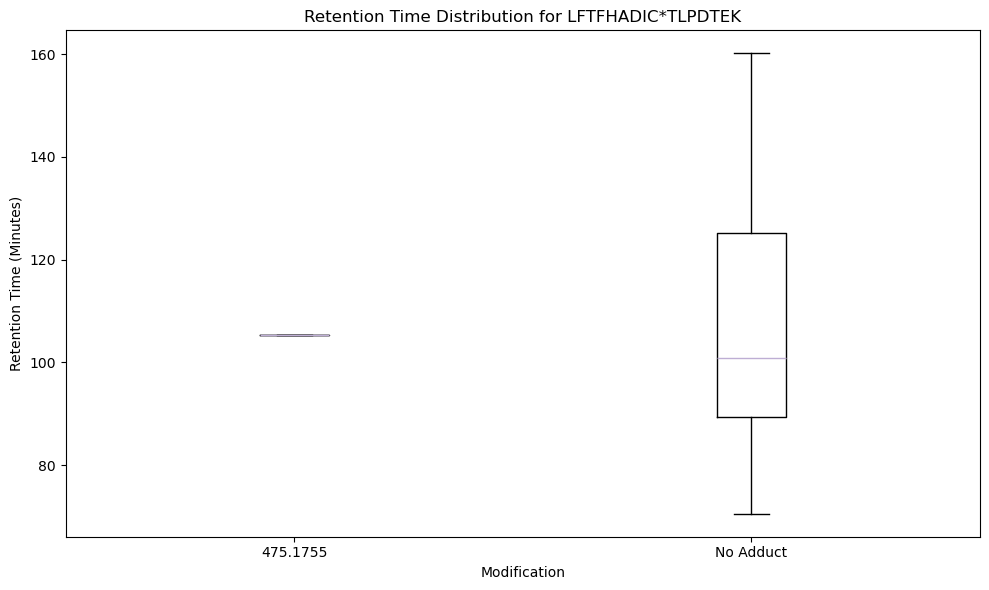

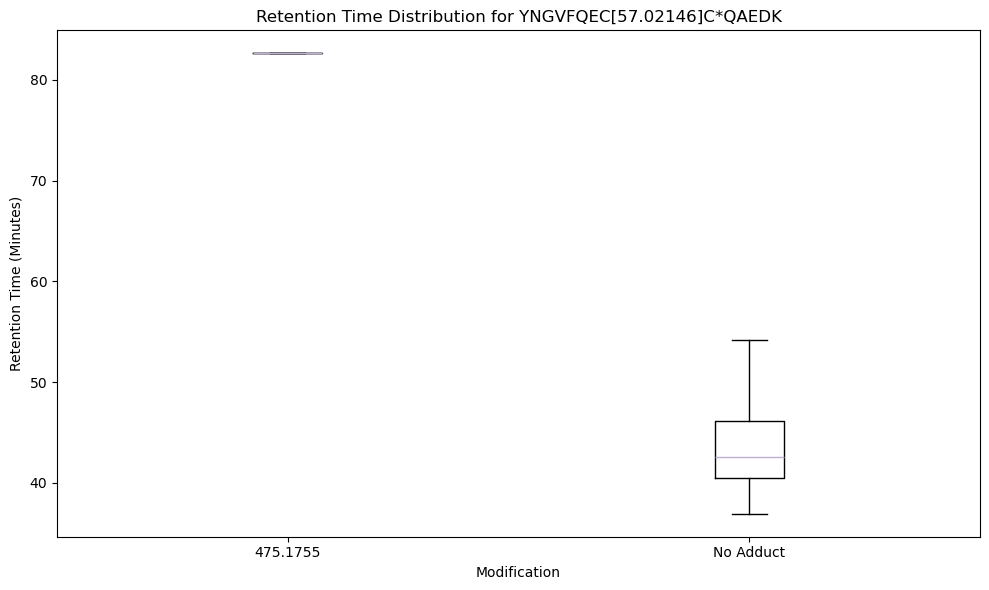

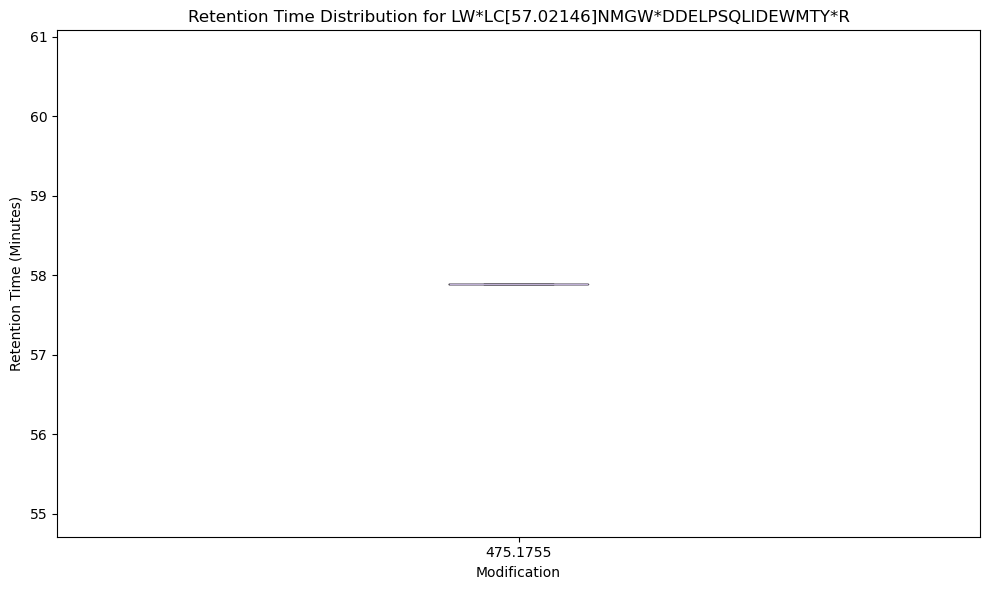

In [16]:
# Iterate over each star_mod_peptide in collected_rows
for star_mod_peptide, mod_dict in collected_rows.items():
    # Initialize empty DataFrames for each modification
    df_471 = pd.DataFrame()
    df_475 = pd.DataFrame()
    df_nomod = pd.DataFrame()
    
    # Check if each modification key exists and assign the corresponding DataFrame
    if '471.1504' in mod_dict:
        df_471 = pd.DataFrame(mod_dict['471.1504'])
    if '475.1755' in mod_dict:
        df_475 = pd.DataFrame(mod_dict['475.1755'])
    if 'nomod' in mod_dict:
        df_nomod = pd.DataFrame(mod_dict['nomod'])
    
    # Create a figure and axis for the box plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create lists to store the retention times for each modification
    rt_471 = df_471['RETENTION TIME (MINUTES)'].tolist() if not df_471.empty else []
    rt_475 = df_475['RETENTION TIME (MINUTES)'].tolist() if not df_475.empty else []
    rt_nomod = df_nomod['RETENTION TIME (MINUTES)'].tolist() if not df_nomod.empty else []
    
    # Create a list of data and labels for the box plot
    data = []
    labels = []
    
    if rt_471:
        data.append(rt_471)
        labels.append('471.1504')
    if rt_475:
        data.append(rt_475)
        labels.append('475.1755')
    if rt_nomod:
        data.append(rt_nomod)
        labels.append('No Adduct')
    
    # Create the box plot
    ax.boxplot(data, labels=labels)
    
    # Add labels and title
    ax.set_xlabel('Modification')
    ax.set_ylabel('Retention Time (Minutes)')
    ax.set_title(f'Retention Time Distribution for {star_mod_peptide}')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

## Output and save meta peptide figure to disk

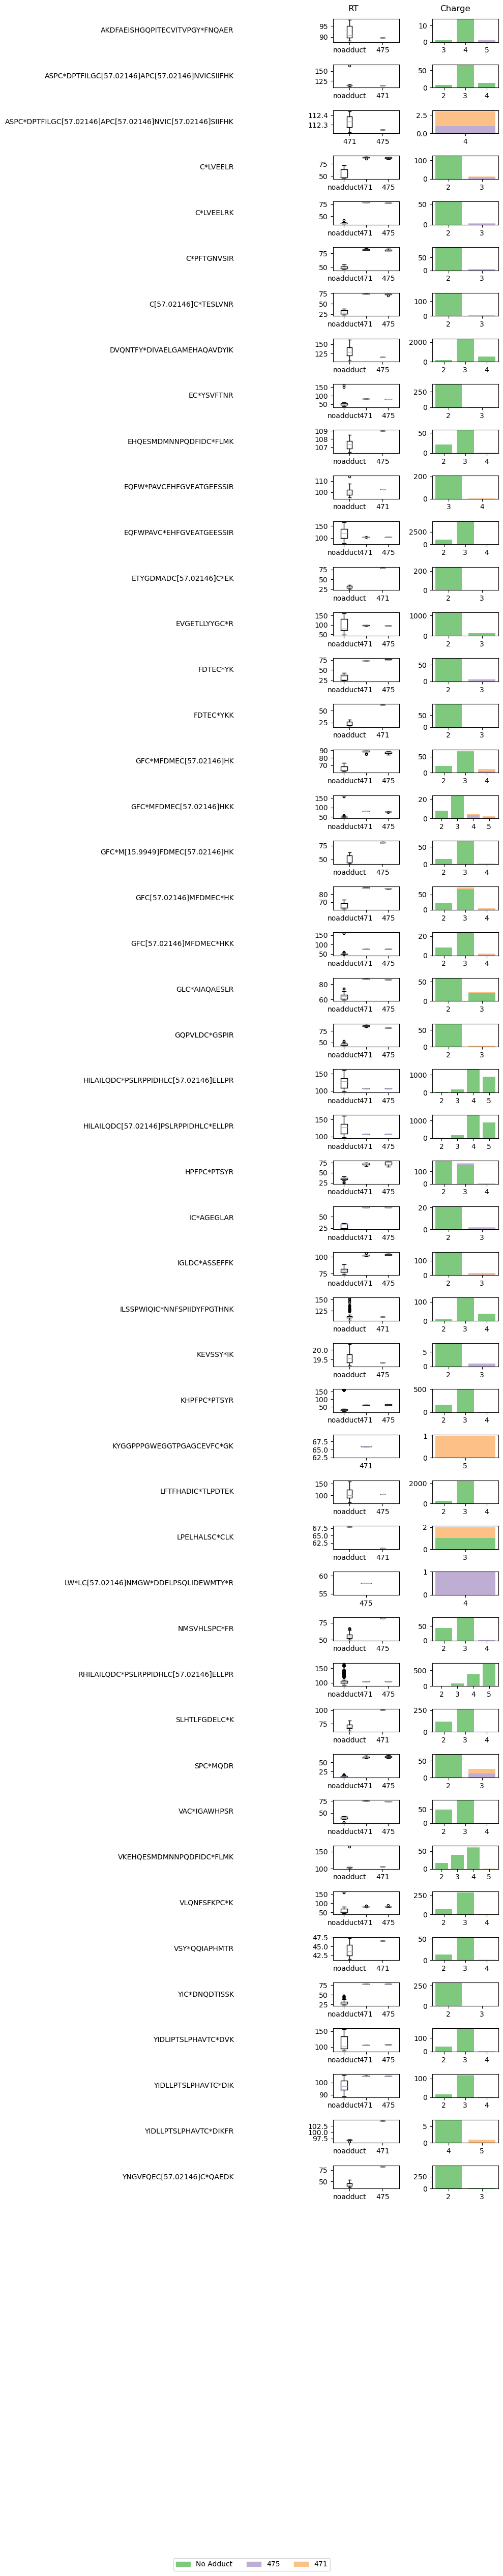

In [17]:

# Get the sorted list of star_mod_peptides
star_mod_peptides = sorted(collected_rows.keys())

# Create a figure and subplots
num_peptides = len(star_mod_peptides)
fig, axes = plt.subplots(num_peptides, 3, figsize=(10, num_peptides * 1))

# Add headers for the box plots and bar charts
fig.text(0.7, 0.95, 'RT', ha='center', fontsize=12)
fig.text(0.9, 0.95, 'Charge', ha='center', fontsize=12)

# Iterate over each star_mod_peptide and create the subplots
for i, star_mod_peptide in enumerate(star_mod_peptides):
    mod_dict = collected_rows[star_mod_peptide]
    
    # Display the star_mod_peptide string on the far left
    axes[i, 0].text(0, 0.5, star_mod_peptide, ha='right', va='center')
    axes[i, 0].axis('off')
    
    # Create box plots for retention times
    df_471 = pd.DataFrame(mod_dict['471.1504']) if '471.1504' in mod_dict else pd.DataFrame()
    df_475 = pd.DataFrame(mod_dict['475.1755']) if '475.1755' in mod_dict else pd.DataFrame()
    df_nomod = pd.DataFrame(mod_dict['nomod']) if 'nomod' in mod_dict else pd.DataFrame()
    
    rt_471 = df_471['RETENTION TIME (MINUTES)'].tolist() if not df_471.empty else []
    rt_475 = df_475['RETENTION TIME (MINUTES)'].tolist() if not df_475.empty else []
    rt_nomod = df_nomod['RETENTION TIME (MINUTES)'].tolist() if not df_nomod.empty else []
    
    data = []
    labels = []
    if rt_nomod:
        data.append(rt_nomod)
        labels.append('noadduct')
    if rt_471:
        data.append(rt_471)
        labels.append('471')
    if rt_475:
        data.append(rt_475)
        labels.append('475')
    
    # Adjust the size of outlier circles
    flierprops = dict(marker='o', markersize=3)
    
    axes[i, 1].boxplot(data, labels=labels, flierprops=flierprops)
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel('')
    
    # Create stacked bar plots for charge distribution
    charges_471 = df_471['CHARGE'].value_counts() if not df_471.empty else pd.Series()
    charges_475 = df_475['CHARGE'].value_counts() if not df_475.empty else pd.Series()
    charges_nomod = df_nomod['CHARGE'].value_counts() if not df_nomod.empty else pd.Series()
    
    unique_charges = sorted(set(charges_471.index) | set(charges_475.index) | set(charges_nomod.index))
    
    counts_471 = [charges_471.get(charge, 0) for charge in unique_charges]
    counts_475 = [charges_475.get(charge, 0) for charge in unique_charges]
    counts_nomod = [charges_nomod.get(charge, 0) for charge in unique_charges]
    
    axes[i, 2].bar(unique_charges, counts_nomod)
    axes[i, 2].bar(unique_charges, counts_475, bottom=counts_nomod)
    axes[i, 2].bar(unique_charges, counts_471, bottom=[sum(x) for x in zip(counts_nomod, counts_475)])
    axes[i, 2].set_xticks(unique_charges)
    axes[i, 2].set_xticklabels(unique_charges)
    axes[i, 2].set_xlabel('')
    axes[i, 2].set_ylabel('')

# Create a separate legend for the bar charts
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]]
labels = ['No Adduct', '475', '471']
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('peptide-meta-figure.svg', format='svg', bbox_inches='tight')

# Display the plot
plt.show()


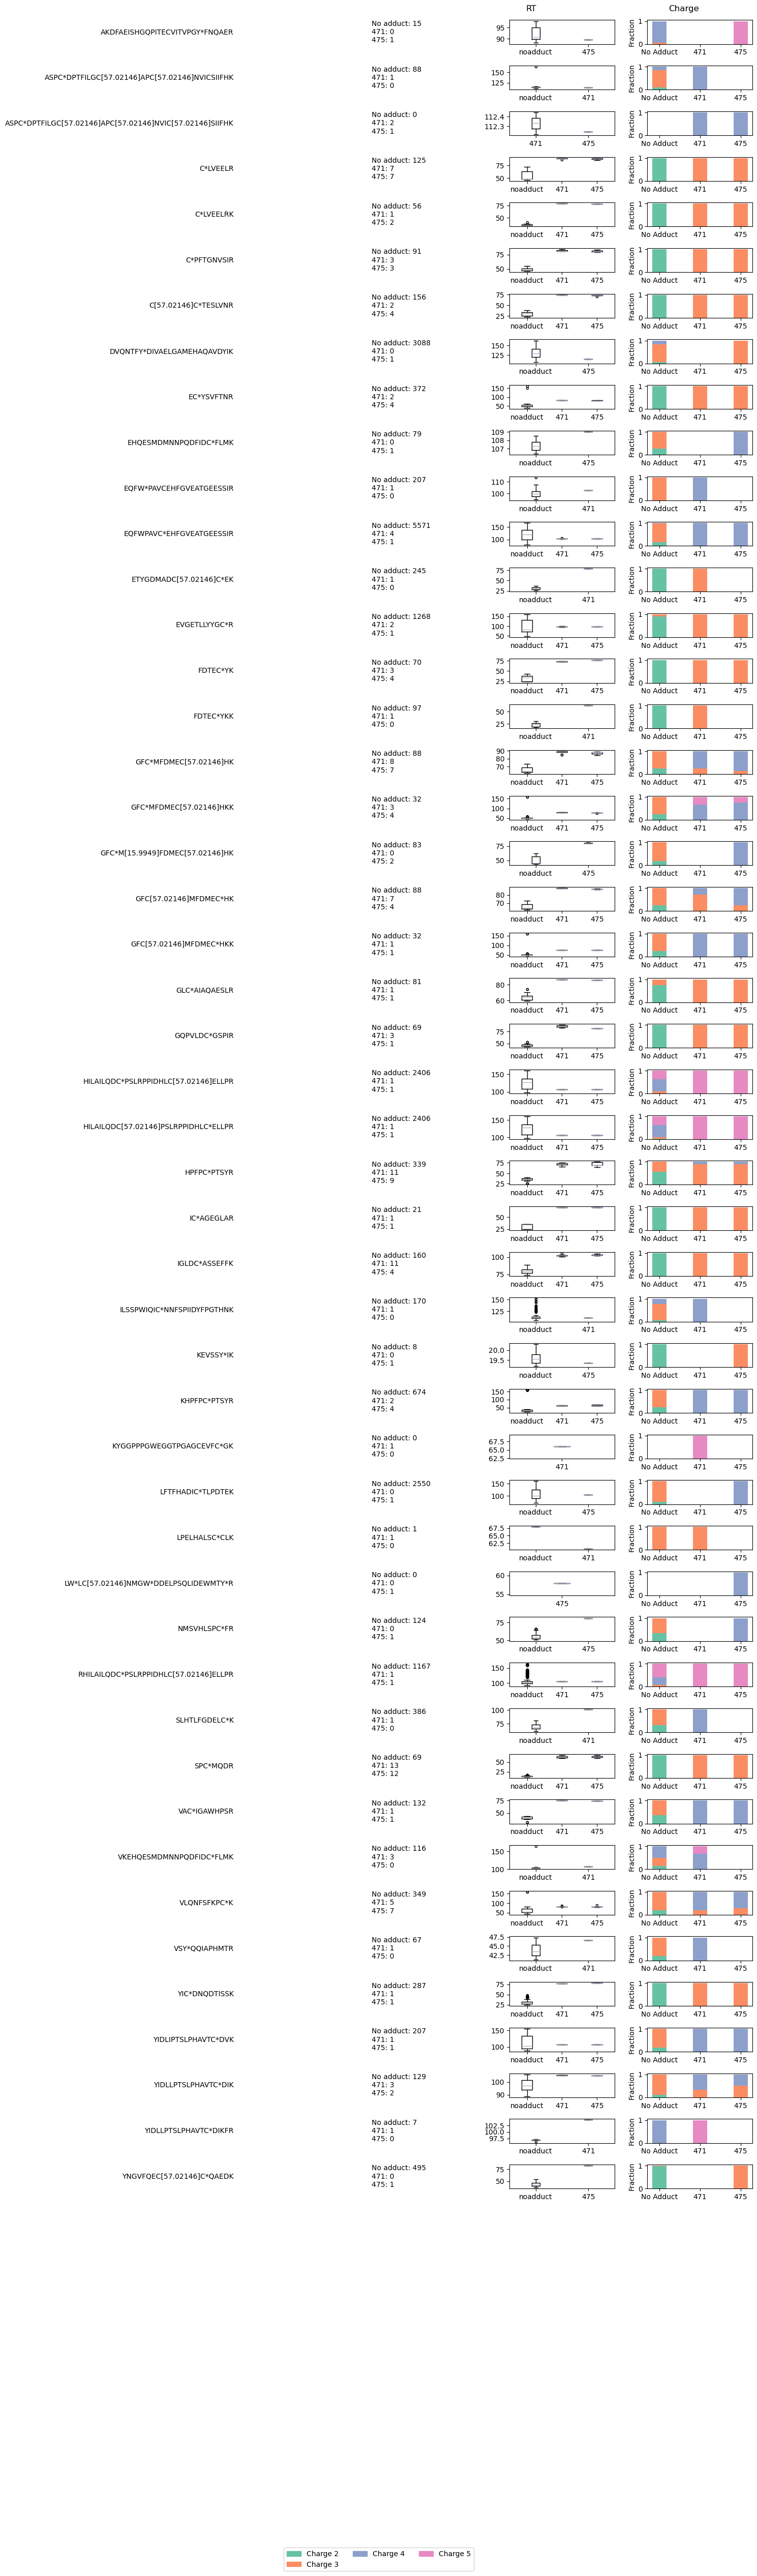

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `collected_rows` is already defined and populated with the necessary data

# Get the sorted list of star_mod_peptides
star_mod_peptides = sorted(collected_rows.keys())

# Find all unique charge states across all star_mod_peptides
all_charges_set = set()
for mod_dict in collected_rows.values():
    for df in mod_dict.values():
        if isinstance(df, list):
            df = pd.DataFrame(df)
        if 'CHARGE' in df.columns:
            all_charges_set.update(df['CHARGE'].unique())

all_charges = sorted(all_charges_set)

# Define the Set2 color palette from seaborn
palette = sns.color_palette("Set2", len(all_charges))
charge_colors = {charge: palette[i] for i, charge in enumerate(all_charges)}

# Create a figure and subplots
num_peptides = len(star_mod_peptides)
fig, axes = plt.subplots(num_peptides, 4, figsize=(15, num_peptides * 1))  # Increase figure width to accommodate additional text

# Add headers for the box plots and bar charts
fig.text(0.7, 0.95, 'RT', ha='center', fontsize=12)
fig.text(0.9, 0.95, 'Charge', ha='center', fontsize=12)

# Iterate over each star_mod_peptide and create the subplots
for i, star_mod_peptide in enumerate(star_mod_peptides):
    mod_dict = collected_rows[star_mod_peptide]
    
    # Create DataFrames for each modification
    df_471 = pd.DataFrame(mod_dict.get('471.1504', []))
    df_475 = pd.DataFrame(mod_dict.get('475.1755', []))
    df_nomod = pd.DataFrame(mod_dict.get('nomod', []))
    
    # Calculate the number of entries for each modification
    num_nomod = len(df_nomod)
    num_471 = len(df_471)
    num_475 = len(df_475)
    
    # Create the annotation text
    annotation_text = f"No adduct: {num_nomod}\n471: {num_471}\n475: {num_475}"
    
    # Display the star_mod_peptide string on the far left
    axes[i, 0].text(0, 0.5, star_mod_peptide, ha='right', va='center', fontsize=10)
    axes[i, 0].axis('off')
    
    # Display the annotation text to the right of the star_mod_peptide string
    axes[i, 1].text(0, 0.5, annotation_text, ha='left', va='center', fontsize=10)
    axes[i, 1].axis('off')
    
    # Create box plots for retention times
    rt_471 = df_471['RETENTION TIME (MINUTES)'].tolist() if not df_471.empty else []
    rt_475 = df_475['RETENTION TIME (MINUTES)'].tolist() if not df_475.empty else []
    rt_nomod = df_nomod['RETENTION TIME (MINUTES)'].tolist() if not df_nomod.empty else []
    
    data = []
    labels = []
    if rt_nomod:
        data.append(rt_nomod)
        labels.append('noadduct')
    if rt_471:
        data.append(rt_471)
        labels.append('471')
    if rt_475:
        data.append(rt_475)
        labels.append('475')
    
    # Adjust the size of outlier circles
    flierprops = dict(marker='o', markersize=3)
    
    axes[i, 2].boxplot(data, labels=labels, flierprops=flierprops)
    axes[i, 2].set_xlabel('')
    axes[i, 2].set_ylabel('')
    
    # Create the new stacked bar chart for charge fractions
    def calculate_fractions(df):
        if df.empty or 'CHARGE' not in df.columns:
            return {}
        charge_counts = df['CHARGE'].value_counts(normalize=True)
        return charge_counts.to_dict()

    fractions_nomod = calculate_fractions(df_nomod)
    fractions_471 = calculate_fractions(df_471)
    fractions_475 = calculate_fractions(df_475)
    
    def get_fractions(fractions, all_charges):
        return [fractions.get(charge, 0) for charge in all_charges]

    counts_nomod = get_fractions(fractions_nomod, all_charges)
    counts_471 = get_fractions(fractions_471, all_charges)
    counts_475 = get_fractions(fractions_475, all_charges)
    
    bar_width = 0.35
    bar_positions = [0, 1, 2]  # Always reserve positions for 'No Adduct', '471', and '475'
    bar_labels = ['No Adduct', '471', '475']

    # Plot the bars in the correct order, adding invisible bars if necessary
    for pos, counts, num_entries in zip(bar_positions, [counts_nomod, counts_471, counts_475], [num_nomod, num_471, num_475]):
        if num_entries > 0:
            bottom = 0
            for j, charge in enumerate(all_charges):
                fraction = counts[j]
                if fraction > 0:
                    axes[i, 3].bar(pos, fraction, bar_width, bottom=bottom, color=charge_colors[charge], label=f'Charge {charge}' if i == 0 else "")
                    bottom += fraction
        else:
            # Add an invisible bar to maintain spacing
            axes[i, 3].bar(pos, 1, bar_width, color='white', edgecolor='white')

    axes[i, 3].set_xticks(bar_positions)
    axes[i, 3].set_xticklabels(bar_labels)
    axes[i, 3].set_xlabel('')
    axes[i, 3].set_ylabel('Fraction')
    
# Create a separate legend for the charge states
handles = [plt.Rectangle((0, 0), 1, 1, color=charge_colors[charge]) for charge in all_charges]
labels = [f'Charge {charge}' for charge in all_charges]
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1))

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0.05, 1, 0.95])

plt.savefig('peptide-meta-figure.svg', format='svg', bbox_inches='tight')

# Display the plot
plt.show()


C:\Users\mriffle\AppData\Local\Temp\ipykernel_24908\1571898800.py:18: UserWarning: No entries found in 'nomod' for star_mod_peptide: KYGGPPPGWEGGTPGAGCEVFC*GK. Skipping.
  warnings.warn(f"No entries found in 'nomod' for star_mod_peptide: {star_mod_peptide}. Skipping.")
C:\Users\mriffle\AppData\Local\Temp\ipykernel_24908\1571898800.py:18: UserWarning: No entries found in 'nomod' for star_mod_peptide: ASPC*DPTFILGC[57.02146]APC[57.02146]NVIC[57.02146]SIIFHK. Skipping.
  warnings.warn(f"No entries found in 'nomod' for star_mod_peptide: {star_mod_peptide}. Skipping.")
C:\Users\mriffle\AppData\Local\Temp\ipykernel_24908\1571898800.py:18: UserWarning: No entries found in 'nomod' for star_mod_peptide: LW*LC[57.02146]NMGW*DDELPSQLIDEWMTY*R. Skipping.
  warnings.warn(f"No entries found in 'nomod' for star_mod_peptide: {star_mod_peptide}. Skipping.")


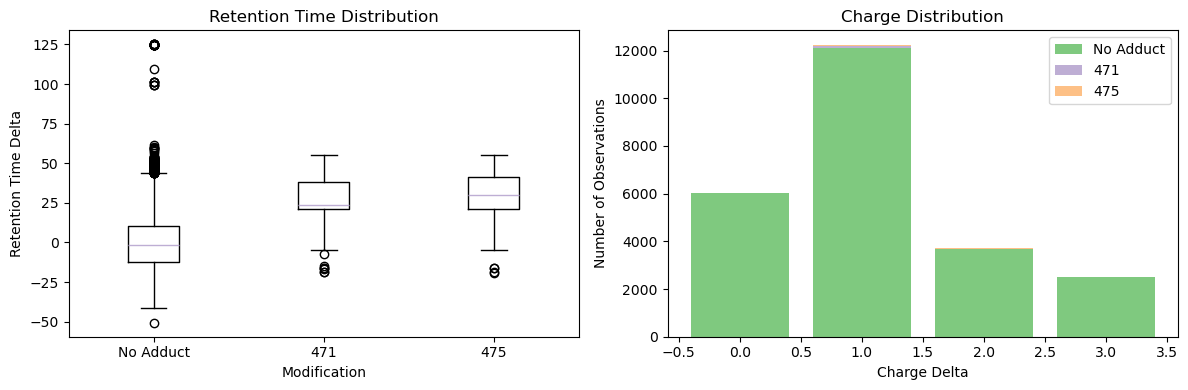

In [19]:

# Initialize lists to store retention times and charges for each modification type
rt_nomod = []
rt_471 = []
rt_475 = []
charges_nomod = []
charges_471 = []
charges_475 = []

# Iterate over each star_mod_peptide in collected_rows
for star_mod_peptide, mod_dict in collected_rows.items():
    # Check if the "nomod" entry exists for the current star_mod_peptide
    if 'nomod' not in mod_dict:
        warnings.warn(f"No 'nomod' entry found for star_mod_peptide: {star_mod_peptide}. Skipping.")
        continue

    # Check if there are any entries in the "nomod" entry
    if len(mod_dict['nomod']) == 0:
        warnings.warn(f"No entries found in 'nomod' for star_mod_peptide: {star_mod_peptide}. Skipping.")
        continue

    # Calculate the baseline retention time for the current star_mod_peptide
    baseline_rt = sum(entry['RETENTION TIME (MINUTES)'] for entry in mod_dict['nomod']) / len(mod_dict['nomod'])

    # Calculate the baseline charge for the current star_mod_peptide
    baseline_charge = min(entry['CHARGE'] for entry_type in mod_dict.values() for entry in entry_type)

    # Collect retention times and charges for each modification type
    if '471.1504' in mod_dict:
        rt_471.extend(entry['RETENTION TIME (MINUTES)'] - baseline_rt for entry in mod_dict['471.1504'])
        charges_471.extend(entry['CHARGE'] - baseline_charge for entry in mod_dict['471.1504'])
    if '475.1755' in mod_dict:
        rt_475.extend(entry['RETENTION TIME (MINUTES)'] - baseline_rt for entry in mod_dict['475.1755'])
        charges_475.extend(entry['CHARGE'] - baseline_charge for entry in mod_dict['475.1755'])
    if 'nomod' in mod_dict:
        rt_nomod.extend(entry['RETENTION TIME (MINUTES)'] - baseline_rt for entry in mod_dict['nomod'])
        charges_nomod.extend(entry['CHARGE'] - baseline_charge for entry in mod_dict['nomod'])

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Create box plots for retention times
data = [rt_nomod, rt_471, rt_475]
labels = ['No Adduct', '471', '475']
ax1.boxplot(data, labels=labels)
ax1.set_xlabel('Modification')
ax1.set_ylabel('Retention Time Delta')
ax1.set_title('Retention Time Distribution')

# Create stacked bar charts for charge distribution
unique_charges = sorted(set(charges_nomod + charges_471 + charges_475))
counts_nomod = [charges_nomod.count(charge) for charge in unique_charges]
counts_471 = [charges_471.count(charge) for charge in unique_charges]
counts_475 = [charges_475.count(charge) for charge in unique_charges]

ax2.bar(unique_charges, counts_nomod, label='No Adduct')
ax2.bar(unique_charges, counts_471, bottom=counts_nomod, label='471')
ax2.bar(unique_charges, counts_475, bottom=[sum(x) for x in zip(counts_nomod, counts_471)], label='475')
ax2.set_xlabel('Charge Delta')
ax2.set_ylabel('Number of Observations')
ax2.set_title('Charge Distribution')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# save as svg
plt.savefig('peptide-rollup-figure.svg', format='svg', bbox_inches='tight')

# Display the plot
plt.show()

C:\Users\mriffle\AppData\Local\Temp\ipykernel_24908\3254865373.py:18: UserWarning: No entries found in 'nomod' for star_mod_peptide: KYGGPPPGWEGGTPGAGCEVFC*GK. Skipping.
  warnings.warn(f"No entries found in 'nomod' for star_mod_peptide: {star_mod_peptide}. Skipping.")
C:\Users\mriffle\AppData\Local\Temp\ipykernel_24908\3254865373.py:18: UserWarning: No entries found in 'nomod' for star_mod_peptide: ASPC*DPTFILGC[57.02146]APC[57.02146]NVIC[57.02146]SIIFHK. Skipping.
  warnings.warn(f"No entries found in 'nomod' for star_mod_peptide: {star_mod_peptide}. Skipping.")
C:\Users\mriffle\AppData\Local\Temp\ipykernel_24908\3254865373.py:18: UserWarning: No entries found in 'nomod' for star_mod_peptide: LW*LC[57.02146]NMGW*DDELPSQLIDEWMTY*R. Skipping.
  warnings.warn(f"No entries found in 'nomod' for star_mod_peptide: {star_mod_peptide}. Skipping.")


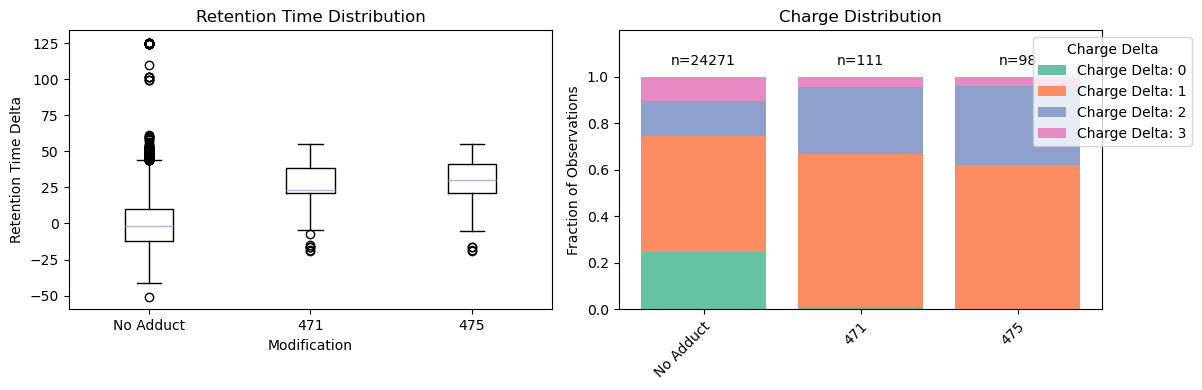

In [20]:
# Initialize lists to store retention times and charges for each modification type
rt_nomod = []
rt_471 = []
rt_475 = []
charges_nomod = []
charges_471 = []
charges_475 = []

# Iterate over each star_mod_peptide in collected_rows
for star_mod_peptide, mod_dict in collected_rows.items():
    # Check if the "nomod" entry exists for the current star_mod_peptide
    if 'nomod' not in mod_dict:
        warnings.warn(f"No 'nomod' entry found for star_mod_peptide: {star_mod_peptide}. Skipping.")
        continue

    # Check if there are any entries in the "nomod" entry
    if len(mod_dict['nomod']) == 0:
        warnings.warn(f"No entries found in 'nomod' for star_mod_peptide: {star_mod_peptide}. Skipping.")
        continue

    # Calculate the baseline retention time for the current star_mod_peptide
    baseline_rt = sum(entry['RETENTION TIME (MINUTES)'] for entry in mod_dict['nomod']) / len(mod_dict['nomod'])

    # Calculate the baseline charge for the current star_mod_peptide
    baseline_charge = min(entry['CHARGE'] for entry_type in mod_dict.values() for entry in entry_type)

    # Collect retention times and charges for each modification type
    if '471.1504' in mod_dict:
        rt_471.extend(entry['RETENTION TIME (MINUTES)'] - baseline_rt for entry in mod_dict['471.1504'])
        charges_471.extend(entry['CHARGE'] - baseline_charge for entry in mod_dict['471.1504'])
    if '475.1755' in mod_dict:
        rt_475.extend(entry['RETENTION TIME (MINUTES)'] - baseline_rt for entry in mod_dict['475.1755'])
        charges_475.extend(entry['CHARGE'] - baseline_charge for entry in mod_dict['475.1755'])
    if 'nomod' in mod_dict:
        rt_nomod.extend(entry['RETENTION TIME (MINUTES)'] - baseline_rt for entry in mod_dict['nomod'])
        charges_nomod.extend(entry['CHARGE'] - baseline_charge for entry in mod_dict['nomod'])

# Create a figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Create box plots for retention times
data = [rt_nomod, rt_471, rt_475]
labels = ['No Adduct', '471', '475']
ax1.boxplot(data, labels=labels)
ax1.set_xlabel('Modification')
ax1.set_ylabel('Retention Time Delta')
ax1.set_title('Retention Time Distribution')

# Create stacked bar charts for charge distribution
unique_charges = sorted(set(charges_nomod + charges_471 + charges_475))

# Calculate the fraction of observations for each charge delta within each modification class
fractions_nomod = [charges_nomod.count(charge) / len(charges_nomod) for charge in unique_charges]
fractions_471 = [charges_471.count(charge) / len(charges_471) for charge in unique_charges]
fractions_475 = [charges_475.count(charge) / len(charges_475) for charge in unique_charges]

# Create stacked bar charts for each modification class
bar_width = 0.8
x = np.arange(len(labels))

# Set color palette from seaborn
colors = sns.color_palette("Set2", n_colors=len(unique_charges))

for i in range(len(unique_charges)):
    if i == 0:
        ax2.bar(x, [fractions_nomod[i], fractions_471[i], fractions_475[i]], bar_width, label=f'Charge Delta: {unique_charges[i]}', color=colors[i])
    else:
        ax2.bar(x, [fractions_nomod[i], fractions_471[i], fractions_475[i]], bar_width, bottom=[sum(fractions_nomod[:i]), sum(fractions_471[:i]), sum(fractions_475[:i])], label=f'Charge Delta: {unique_charges[i]}', color=colors[i])

# Set x-tick labels and rotate them
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

ax2.set_ylabel('Fraction of Observations')
ax2.set_title('Charge Distribution')

# Set y-axis range from 0 to 1.2 and set tick marks
ax2.set_ylim(0, 1.2)
ax2.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

ax2.legend(title='Charge Delta', loc='upper right', bbox_to_anchor=(1.2, 1))

# Add total observations for each modification class above the bars
total_nomod = len(charges_nomod)
total_471 = len(charges_471)
total_475 = len(charges_475)
ax2.text(x[0], 1.05, f'n={total_nomod}', ha='center')
ax2.text(x[1], 1.05, f'n={total_471}', ha='center')
ax2.text(x[2], 1.05, f'n={total_475}', ha='center')

# Adjust spacing between subplots
plt.tight_layout()

# Save as SVG
plt.savefig('peptide-rollup-figur2.svg', format='svg', bbox_inches='tight')

# Display the plot
plt.show()

## Save simple report of parsed data to disk

In [21]:
# Initialize an empty list to store the data
data = []

# Iterate over each star_mod_peptide in collected_rows
for star_mod_peptide, mod_dict in collected_rows.items():
    # Process entries from the "471.1504" key
    if '471.1504' in mod_dict:
        for entry in mod_dict['471.1504']:
            data.append([
                star_mod_peptide,
                1,
                entry['RETENTION TIME (MINUTES)'],
                entry['CHARGE']
            ])
    
    # Process entries from the "475.1755" key
    if '475.1755' in mod_dict:
        for entry in mod_dict['475.1755']:
            data.append([
                star_mod_peptide,
                1,
                entry['RETENTION TIME (MINUTES)'],
                entry['CHARGE']
            ])
    
    # Process entries from the "nomod" key
    if 'nomod' in mod_dict:
        for entry in mod_dict['nomod']:
            data.append([
                star_mod_peptide,
                0,
                entry['RETENTION TIME (MINUTES)'],
                entry['CHARGE']
            ])

# Create the dataframe
df = pd.DataFrame(data, columns=['star_mod_peptide', 'modified', 'retention_time', 'charge'])

# Save the dataframe as a tab-delimited text file
df.to_csv('peptide_data_report.txt', sep='\t', index=False)

In [22]:
import numpy as np

# 1. Count the number of distinct star_mod_peptides
num_distinct_peptides = len(collected_rows)
print(f"Number of distinct star_mod_peptides: {num_distinct_peptides}")

# Initialize variables for summing entries
sum_471 = 0
sum_475 = 0
sum_nomod = 0
count_smaller_mean_rt = 0
delta_charges_nomod = []
delta_charges_modified = []
adjusted_rt_nomod = []
adjusted_rt_modified = []

# Iterate over each star_mod_peptide
for star_mod_peptide, mod_dict in collected_rows.items():
    # 2. Sum entries in each group
    sum_471 += len(mod_dict.get('471.1504', []))
    sum_475 += len(mod_dict.get('475.1755', []))
    sum_nomod += len(mod_dict.get('nomod', []))

    # Calculate mean retention times
    mean_rt_nomod = np.mean([entry['RETENTION TIME (MINUTES)'] for entry in mod_dict.get('nomod', [])]) if 'nomod' in mod_dict else np.nan
    modified_entries = mod_dict.get('471.1504', []) + mod_dict.get('475.1755', [])
    mean_rt_modified = np.mean([entry['RETENTION TIME (MINUTES)'] for entry in modified_entries]) if modified_entries else np.nan

    # 3. Compare mean retention times
    if not np.isnan(mean_rt_nomod) and not np.isnan(mean_rt_modified) and mean_rt_nomod < mean_rt_modified:
        count_smaller_mean_rt += 1

    # Calculate minimum charge for the current star_mod_peptide
    min_charge = min(entry['CHARGE'] for entry_list in mod_dict.values() for entry in entry_list)

    # 4. Calculate delta charges
    delta_charges_nomod.extend([entry['CHARGE'] - min_charge for entry in mod_dict.get('nomod', [])])
    delta_charges_modified.extend([entry['CHARGE'] - min_charge for entry in modified_entries])

    # 5. Calculate adjusted retention times
    if 'nomod' in mod_dict and mod_dict['nomod']:
        baseline_rt = np.mean([entry['RETENTION TIME (MINUTES)'] for entry in mod_dict['nomod']])
        adjusted_rt_nomod.extend([entry['RETENTION TIME (MINUTES)'] - baseline_rt for entry in mod_dict['nomod']])
        if modified_entries:
            adjusted_rt_modified.extend([entry['RETENTION TIME (MINUTES)'] - baseline_rt for entry in modified_entries])

# Print the summed entries for each group
print(f"Total entries in '471.1504': {sum_471}")
print(f"Total entries in '475.1755': {sum_475}")
print(f"Total entries in 'nomod': {sum_nomod}")

# Print the count of star_mod_peptides with smaller mean retention time in 'nomod'
print(f"Number of star_mod_peptides with smaller mean RT in 'nomod': {count_smaller_mean_rt}")

# Calculate and print the mean delta charges
mean_delta_charge_nomod = np.mean(delta_charges_nomod) if delta_charges_nomod else np.nan
mean_delta_charge_modified = np.mean(delta_charges_modified) if delta_charges_modified else np.nan
print(f"Mean delta charge for 'nomod' entries: {mean_delta_charge_nomod:.2f}")
print(f"Mean delta charge for '471.1504' and '475.1755' entries: {mean_delta_charge_modified:.2f}")

# Calculate and print the mean adjusted retention times
mean_adjusted_rt_nomod = np.mean(adjusted_rt_nomod) if adjusted_rt_nomod else np.nan
mean_adjusted_rt_modified = np.mean(adjusted_rt_modified) if adjusted_rt_modified else np.nan
print(f"Mean adjusted retention time for 'nomod' entries: {mean_adjusted_rt_nomod:.2f}")
print(f"Mean adjusted retention time for '471.1504' and '475.1755' entries: {mean_adjusted_rt_modified:.2f}")

Number of distinct star_mod_peptides: 48
Total entries in '471.1504': 114
Total entries in '475.1755': 100
Total entries in 'nomod': 24271
Number of star_mod_peptides with smaller mean RT in 'nomod': 32
Mean delta charge for 'nomod' entries: 1.11
Mean delta charge for '471.1504' and '475.1755' entries: 1.36
Mean adjusted retention time for 'nomod' entries: 0.00
Mean adjusted retention time for '471.1504' and '475.1755' entries: 26.73


D:\Users\mriffle\anaconda3\envs\proteomics\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
D:\Users\mriffle\anaconda3\envs\proteomics\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
